##Dataset

### Imports & Settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import lightgbm as lgb
import xgboost as xgb

import random
#from skopt import gp_minimize
from functools import partial

#from catboost import CatBoost, Pool
from sklearn.preprocessing import LabelBinarizer


In [ ]:
#!pip install ydata_profiling --upgrade
#from ydata_profiling import ProfileReport

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install torch==2.0.1+cpu torchvision==0.15.2+cpu --index-url https://download.pytorch.org/whl/cpu
#!pip install autogluon

In [ ]:
#from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
from skopt import gp_minimize

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoost, Pool

### Loading the data

In [ ]:
#Load raw dataset
df = pd.read_excel('/content/drive/MyDrive/TFM/data_final_limpio.xlsx')

### Initial inspection

In [ ]:
#View columns
list(df.columns)

['Date',
 'Open_USDMX',
 'Open_Oil',
 'Open_Gold',
 'Open_SP500',
 'Open_1_year_MX',
 'Open_5_year_MX',
 'Open_10_year_MX',
 'Open_1_year_US',
 'Open_5_year_US',
 'Open_10_year_US',
 'UnemploymentRate_US',
 'M2_SA_US',
 'CPI_US',
 'GastoPublico_MX',
 'FFER_US',
 'Expected_Inflation_US',
 'Inflacion_mensual',
 'Inflacion_general_acumulada',
 'Inflacion_general_anual',
 'Inflacion_subyacente_mensual',
 'Inflacion_subyacente_acumulada',
 'Inflacion_subyacente_anual',
 'GDP_US',
 'PIB_MX',
 'Gasto_publico_US',
 'Deuda_PIB_US']

In [ ]:
print(f"The original dataframe has: {df.shape[0]} rows and {df.shape[1]} columns")

The original dataframe has: 9716 rows and 27 columns


In [ ]:
#Add new column to identify week days and year
df["Day"]=df["Date"].dt.day_of_week
df["Year"]=df["Date"].dt.year

In [ ]:
list(df.columns)

['Date',
 'Open_USDMX',
 'Open_Oil',
 'Open_Gold',
 'Open_SP500',
 'Open_1_year_MX',
 'Open_5_year_MX',
 'Open_10_year_MX',
 'Open_1_year_US',
 'Open_5_year_US',
 'Open_10_year_US',
 'UnemploymentRate_US',
 'M2_SA_US',
 'CPI_US',
 'GastoPublico_MX',
 'FFER_US',
 'Expected_Inflation_US',
 'Inflacion_mensual',
 'Inflacion_general_acumulada',
 'Inflacion_general_anual',
 'Inflacion_subyacente_mensual',
 'Inflacion_subyacente_acumulada',
 'Inflacion_subyacente_anual',
 'GDP_US',
 'PIB_MX',
 'Gasto_publico_US',
 'Deuda_PIB_US',
 'Day',
 'Year']

In [ ]:
df.dtypes

Date                              datetime64[ns]
Open_USDMX                               float64
Open_Oil                                 float64
Open_Gold                                float64
Open_SP500                               float64
Open_1_year_MX                           float64
Open_5_year_MX                           float64
Open_10_year_MX                          float64
Open_1_year_US                           float64
Open_5_year_US                           float64
Open_10_year_US                          float64
UnemploymentRate_US                      float64
M2_SA_US                                 float64
CPI_US                                   float64
GastoPublico_MX                          float64
FFER_US                                  float64
Expected_Inflation_US                    float64
Inflacion_mensual                        float64
Inflacion_general_acumulada              float64
Inflacion_general_anual                  float64
Inflacion_subyacente

### Data cleaning

In [ ]:
#Identify and handle missing values
df.isnull().sum()

Date                              0
Open_USDMX                        0
Open_Oil                          0
Open_Gold                         0
Open_SP500                        0
Open_1_year_MX                    0
Open_5_year_MX                    0
Open_10_year_MX                   0
Open_1_year_US                    0
Open_5_year_US                    0
Open_10_year_US                   0
UnemploymentRate_US               0
M2_SA_US                          0
CPI_US                            0
GastoPublico_MX                   0
FFER_US                           0
Expected_Inflation_US             0
Inflacion_mensual                 0
Inflacion_general_acumulada       0
Inflacion_general_anual           0
Inflacion_subyacente_mensual      0
Inflacion_subyacente_acumulada    0
Inflacion_subyacente_anual        0
GDP_US                            0
PIB_MX                            0
Gasto_publico_US                  0
Deuda_PIB_US                      0
Day                         

In [ ]:
#Data per Year
print(df['Year'].value_counts().sort_index())

Year
1946      1
1947      4
1948     12
1949     12
1950     12
       ... 
2020    265
2021    265
2022    263
2023    263
2024     51
Name: count, Length: 79, dtype: int64


In [ ]:
df.head(10)

Date  Open_USDMX   Open_Oil   Open_Gold  Open_SP500  Open_1_year_MX  \
0 1946-12-31     11.1776  31.950001  273.899994  353.399994            4.58   
1 1947-03-31     11.1776  31.950001  273.899994  353.399994            4.58   
2 1947-06-30     11.1776  31.950001  273.899994  353.399994            4.58   
3 1947-09-30     11.1776  31.950001  273.899994  353.399994            4.58   
4 1947-12-31     11.1776  31.950001  273.899994  353.399994            4.58   
5 1948-01-31     11.1776  31.950001  273.899994  353.399994            4.58   
6 1948-02-29     11.1776  31.950001  273.899994  353.399994            4.58   
7 1948-03-31     11.1776  31.950001  273.899994  353.399994            4.58   
8 1948-04-30     11.1776  31.950001  273.899994  353.399994            4.58   
9 1948-05-31     11.1776  31.950001  273.899994  353.399994            4.58   

   Open_5_year_MX  Open_10_year_MX  Open_1_year_US  Open_5_year_US  ...  \
0            5.76             6.65           0.245            3.55  ...   
1            5.76             6.65           0.245            3.55  ...   
2            5.76             6.65           0.245            3.55  ...   
3            5.76             6.65           0.245            3.55  ...   
4            5.76             6.65           0.245            3.55  ...   
5            5.76             6.65           0.245            3.55  ...   
6            5.76             6.65           0.245            3.55  ...   
7            5.76             6.65           0.245            3.55  ...   
8            5.76             6.65           0.245            3.55  ...   
9            5.76             6.65           0.245            3.55  ...   

   Inflacion_general_anual  Inflacion_subyacente_mensual  \
0                    11.02                          1.29   
1                    11.02                          1.29   
2                    11.02                          1.29   
3                    11.02                          1.29   
4                    11.02                          1.29   
5                    11.02                          1.29   
6                    11.02                          1.29   
7                    11.02                          1.29   
8                    11.02                          1.29   
9                    11.02                          1.29   

   Inflacion_subyacente_acumulada  Inflacion_subyacente_anual   GDP_US  \
0                            1.29                       13.17  243.164   
1                            1.29                       13.17  245.968   
2                            1.29                       13.17  249.585   
3                            1.29                       13.17  259.745   
4                            1.29                       13.17  265.742   
5                            1.29                       13.17  272.567   
6                            1.29                       13.17  272.567   
7                            1.29                       13.17  272.567   
8                            1.29                       13.17  279.196   
9                            1.29                       13.17  279.196   

         PIB_MX  Gasto_publico_US  Deuda_PIB_US  Day  Year  
0  1.375905e+07            40.902      40.33999    1  1946  
1  1.375905e+07            40.346      40.33999    0  1947  
2  1.375905e+07            82.353      40.33999    0  1947  
3  1.375905e+07           120.502      40.33999    1  1947  
4  1.375905e+07           159.417      40.33999    2  1947  
5  1.375905e+07            39.904      40.33999    5  1948  
6  1.375905e+07            39.904      40.33999    6  1948  
7  1.375905e+07            39.904      40.33999    2  1948  
8  1.375905e+07            82.643      40.33999    4  1948  
9  1.375905e+07            82.643      40.33999    0  1948  

[10 rows x 29 columns]

In [ ]:
#Filtering data from 2011 to build our model
df=df[df["Year"]>2010]
df=df.reset_index()

In [ ]:
#Data per year
print(df['Year'].value_counts().sort_index())

Year
2011    263
2012    296
2013    311
2014    321
2015    318
2016    315
2017    292
2018    284
2019    265
2020    265
2021    265
2022    263
2023    263
2024     51
Name: count, dtype: int64


In [ ]:
print(f"Considering only data from 2011, the dataset has: {df.shape[0]} rows and {df.shape[1]} columns")

Considering only data from 2011, the dataset has: 3772 rows and 30 columns


In [ ]:
#Check for weekends
df['Day'].value_counts().sort_index()

Day
0    689
1    688
2    688
3    688
4    688
5    257
6     74
Name: count, dtype: int64

In [ ]:
#Clear weekends and confirm
df=df[df["Day"]<5]
df['Day'].value_counts().sort_index()

Day
0    689
1    688
2    688
3    688
4    688
Name: count, dtype: int64

In [ ]:
print(f"Dataframe without weekends and from 2011 has: {df.shape[0]} rows and {df.shape[1]} columns")

Dataframe without weekends and from 2011 has: 3441 rows and 30 columns


### Supporting columns

#### Calculate duration

In [ ]:
#Calculates the difference in days between each date and X days in the future, according to the period 1,3,6 and 12 months.
df["1m_days_shift"]=(df["Date"].shift(-22)-df["Date"]).dt.days
df["3m_days_shift"]=(df["Date"].shift(-64)-df["Date"]).dt.days
df["6m_days_shift"]=(df["Date"].shift(-128)-df["Date"]).dt.days
df["12m_days_shift"]=(df["Date"].shift(-260)-df["Date"]).dt.days

In [ ]:
# df["1m_days_shift"]

# Define the pattern: access three values, skip two values
pattern_mask = [True, True, True, False, False]  # Repeat this pattern as needed
pattern_mask2 = [False, False, False, True, True]  # Repeat this pattern as needed

# Extend the pattern to cover the length of the DataFrame
extended_mask = pattern_mask * (len(df) // len(pattern_mask)) + pattern_mask[:len(df) % len(pattern_mask)]
extended_mask2 = pattern_mask2 * (len(df) // len(pattern_mask2)) + pattern_mask2[:len(df) % len(pattern_mask2)]

# Use the boolean mask to select the desired rows
df["1m_days_shift"]=pd.concat([df[extended_mask][["1m_days_shift"]].fillna(30), df[extended_mask2][["1m_days_shift"]].fillna(32)]).sort_index()

In [ ]:
# df["3m_days_shift"]

# Define the pattern: access three values, skip two values
pattern_mask = [True, False, False, False,False]  # Repeat this pattern as needed
pattern_mask2 = [False, True, True, True, True]  # Repeat this pattern as needed

# Extend the pattern to cover the length of the DataFrame
extended_mask = pattern_mask * (len(df) // len(pattern_mask)) + pattern_mask[:len(df) % len(pattern_mask)]
extended_mask2 = pattern_mask2 * (len(df) // len(pattern_mask2)) + pattern_mask2[:len(df) % len(pattern_mask2)]

# Use the boolean mask to select the desired rows
df["3m_days_shift"]=pd.concat([df[extended_mask][["3m_days_shift"]].fillna(88), df[extended_mask2][["3m_days_shift"]].fillna(90)]).sort_index()

In [ ]:
# df["6m_days_shift"]

# Define the pattern: access three values, skip two values
pattern_mask = [True, True, False, False,False]  # Repeat this pattern as needed
pattern_mask2 = [False, False, True, True, True]  # Repeat this pattern as needed

# Extend the pattern to cover the length of the DataFrame
extended_mask = pattern_mask * (len(df) // len(pattern_mask)) + pattern_mask[:len(df) % len(pattern_mask)]
extended_mask2 = pattern_mask2 * (len(df) // len(pattern_mask2)) + pattern_mask2[:len(df) % len(pattern_mask2)]

# Use the boolean mask to select the desired rows
df["6m_days_shift"]=pd.concat([df[extended_mask][["6m_days_shift"]].fillna(178), df[extended_mask2][["6m_days_shift"]].fillna(180)]).sort_index()

In [ ]:
# df["12m_days_shift"]
df["12m_days_shift"]=df[["12m_days_shift"]].fillna(364)

In [ ]:
df=df.drop(columns="index")

#### Calculate Forward Price

In [ ]:
#Calculate forward price
df["f_1m"]=df["Open_USDMX"]*((1+((df["Open_1_year_MX"]/100)*(df["1m_days_shift"]/360)))/((1+((df["Open_1_year_US"]/100)*(df["1m_days_shift"]/360)))))
df["f_3m"]=df["Open_USDMX"]*((1+((df["Open_1_year_MX"]/100)*(df["3m_days_shift"]/360)))/((1+((df["Open_1_year_US"]/100)*(df["3m_days_shift"]/360)))))
df["f_6m"]=df["Open_USDMX"]*((1+((df["Open_1_year_MX"]/100)*(df["6m_days_shift"]/360)))/((1+((df["Open_1_year_US"]/100)*(df["6m_days_shift"]/360)))))
df["f_12m"]=df["Open_USDMX"]*((1+((df["Open_1_year_MX"]/100)*(df["12m_days_shift"]/360)))/((1+((df["Open_1_year_US"]/100)*(df["12m_days_shift"]/360)))))

In [ ]:
df.head(5)

Date  Open_USDMX   Open_Oil    Open_Gold   Open_SP500  Open_1_year_MX  \
0 2011-01-03    12.34010  91.309998  1415.599976  1257.619995            4.79   
1 2011-01-04    12.24274  91.500000  1409.599976  1272.949951            4.78   
2 2011-01-05    12.23700  89.290001  1383.400024  1268.780029            4.76   
3 2011-01-06    12.18500  90.470001  1374.800049  1276.290039            4.74   
4 2011-01-07    12.22300  88.180000  1372.699951  1274.410034            4.78   

   Open_5_year_MX  Open_10_year_MX  Open_1_year_US  Open_5_year_US  ...  Day  \
0            6.10             5.95           0.226           3.654  ...    0   
1            6.18             5.97           0.206           3.708  ...    1   
2            6.20             5.88           0.196           3.724  ...    2   
3            6.16             5.93           0.201           3.743  ...    3   
4            6.11             5.96           0.201           3.687  ...    4   

   Year  1m_days_shift  3m_days_shift  6m_days_shift  12m_days_shift  \
0  2011           30.0           88.0          178.0           364.0   
1  2011           30.0           90.0          178.0           364.0   
2  2011           30.0           90.0          180.0           364.0   
3  2011           32.0           90.0          180.0           364.0   
4  2011           32.0           90.0          180.0           364.0   

        f_1m       f_3m       f_6m      f_12m  
0  12.387025  12.477696  12.618262  12.908262  
1  12.289397  12.382663  12.519338  12.807768  
2  12.283534  12.376556  12.515975  12.800586  
3  12.234154  12.323200  12.461261  12.743089  
4  12.272741  12.362852  12.502564  12.787762  

[5 rows x 37 columns]

#### Calculate Profit/Loss of each operation

In [ ]:
#Calculate Profit/Loss in percentage
df["ProfitLoss1m"]=((df["f_1m"].shift(22) - df["Open_USDMX"])/df["Open_USDMX"]).shift(-22)
df["ProfitLoss3m"]=((df["f_3m"].shift(64) - df["Open_USDMX"])/df["Open_USDMX"]).shift(-64)
df["ProfitLoss6m"]=((df["f_6m"].shift(128) - df["Open_USDMX"])/df["Open_USDMX"]).shift(-128)
df["ProfitLoss12m"]=((df["f_12m"].shift(260) - df["Open_USDMX"])/df["Open_USDMX"]).shift(-260)

In [ ]:
df.head(10)

Date  Open_USDMX   Open_Oil    Open_Gold   Open_SP500  Open_1_year_MX  \
0 2011-01-03    12.34010  91.309998  1415.599976  1257.619995            4.79   
1 2011-01-04    12.24274  91.500000  1409.599976  1272.949951            4.78   
2 2011-01-05    12.23700  89.290001  1383.400024  1268.780029            4.76   
3 2011-01-06    12.18500  90.470001  1374.800049  1276.290039            4.74   
4 2011-01-07    12.22300  88.180000  1372.699951  1274.410034            4.78   
5 2011-01-10    12.22400  89.000000  1369.000000  1270.839966            4.74   
6 2011-01-11    12.21800  89.309998  1375.400024  1272.579956            4.78   
7 2011-01-12    12.12800  91.180000  1382.599976  1275.650024            4.78   
8 2011-01-13    12.07060  92.000000  1386.099976  1285.780029            4.73   
9 2011-01-14    12.13000  90.989998  1375.000000  1282.900024            4.78   

   Open_5_year_MX  Open_10_year_MX  Open_1_year_US  Open_5_year_US  ...  \
0            6.10             5.95           0.226           3.654  ...   
1            6.18             5.97           0.206           3.708  ...   
2            6.20             5.88           0.196           3.724  ...   
3            6.16             5.93           0.201           3.743  ...   
4            6.11             5.96           0.201           3.687  ...   
5            6.34             5.96           0.208           3.700  ...   
6            6.39             6.07           0.208           3.705  ...   
7            6.40             6.21           0.216           3.728  ...   
8            6.41             6.26           0.216           3.757  ...   
9            6.41             6.22           0.221           3.682  ...   

   6m_days_shift  12m_days_shift       f_1m       f_3m       f_6m      f_12m  \
0          178.0           364.0  12.387025  12.477696  12.618262  12.908262   
1          178.0           364.0  12.289397  12.382663  12.519338  12.807768   
2          180.0           364.0  12.283534  12.376556  12.515975  12.800586   
3          180.0           364.0  12.234154  12.323200  12.461261  12.743089   
4          180.0           364.0  12.272741  12.362852  12.502564  12.787762   
5          178.0           364.0  12.270158  12.359351  12.497637  12.782972   
6          178.0           364.0  12.264543  12.357580  12.493917  12.781629   
7          180.0           364.0  12.174119  12.266306  12.404463  12.686453   
8          180.0           364.0  12.119023  12.206743  12.342739  12.620320   
9          180.0           364.0  12.179147  12.268175  12.406198  12.687905   

   ProfitLoss1m  ProfitLoss3m  ProfitLoss6m  ProfitLoss12m  
0      0.032252      0.049251      0.073392      -0.072836  
1      0.022855      0.046363      0.069115      -0.078206  
2      0.023884      0.045167      0.077941      -0.061541  
3      0.021897      0.043782      0.076474      -0.068828  
4      0.022217      0.047699      0.075101      -0.069778  
5      0.020727      0.050697      0.075806      -0.069991  
6      0.015865      0.054311      0.083033      -0.066353  
7      0.008125      0.043408      0.067418      -0.069458  
8      0.008742      0.032283      0.050312      -0.071489  
9      0.010709      0.042166      0.052532      -0.061775  

[10 rows x 41 columns]

In [ ]:
#df.to_excel("df_profitloss_construido.xlsx")

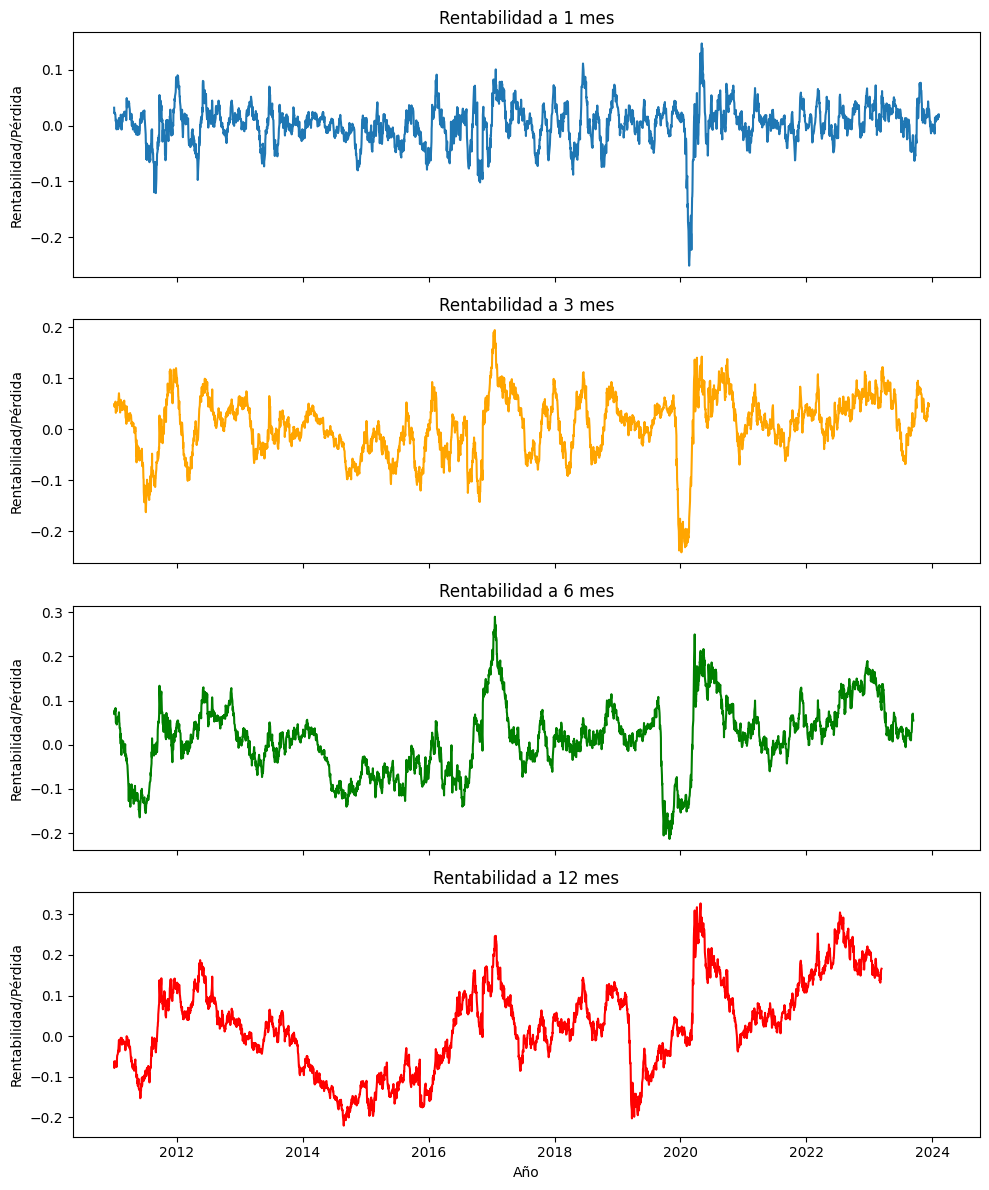

In [ ]:
# Set up the figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot each ProfitLoss series in its own subplot
axs[0].plot(df['Date'], df['ProfitLoss1m'], label='ProfitLoss1m')
axs[0].set_title('Rentabilidad a 1 mes')
axs[0].set_ylabel('Rentabilidad/Pérdida')
#axs[0].legend()

axs[1].plot(df['Date'], df['ProfitLoss3m'], label='ProfitLoss3m', color='orange')
axs[1].set_title('Rentabilidad a 3 mes')
axs[1].set_ylabel('Rentabilidad/Pérdida')
#axs[1].legend()

axs[2].plot(df['Date'], df['ProfitLoss6m'], label='ProfitLoss6m', color='green')
axs[2].set_title('Rentabilidad a 6 mes')
axs[2].set_ylabel('Rentabilidad/Pérdida')
#axs[2].legend()

axs[3].plot(df['Date'], df['ProfitLoss12m'], label='ProfitLoss12m', color='red')
axs[3].set_title('Rentabilidad a 12 mes')
axs[3].set_ylabel('Rentabilidad/Pérdida')
#axs[3].legend()

# Add a common x-axis label
plt.xlabel('Año')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Buckets Target

In [ ]:
def create_target(x):
  if x>(0.12):
    return 4
  elif (0.12)>x>(0.07):
    return 3
  elif (0.07)>x>(0.02):
    return 2
  elif (0.02)>x>(-.03):
    return 1
  else:
    return 0

In [ ]:
df["multi_tag_1m"]=df["ProfitLoss1m"].apply(lambda x: create_target(x))
df["multi_tag_3m"]=df["ProfitLoss3m"].apply(lambda x: create_target(x))
df["multi_tag_6m"]=df["ProfitLoss6m"].apply(lambda x: create_target(x))
df["multi_tag_12m"]=df["ProfitLoss12m"].apply(lambda x: create_target(x))

In [ ]:
#Descriptive statistics
df.describe().T

count                           mean  \
Date                              3441  2017-08-06 04:48:20.087184128   
Open_USDMX                      3441.0                      17.166819   
Open_Oil                        3441.0                      71.207393   
Open_Gold                       3441.0                    1512.254723   
Open_SP500                      3441.0                    2675.706459   
Open_1_year_MX                  3441.0                       6.147533   
Open_5_year_MX                  3441.0                       6.734907   
Open_10_year_MX                 3441.0                       7.062733   
Open_1_year_US                  3441.0                       1.318253   
Open_5_year_US                  3441.0                       2.251704   
Open_10_year_US                 3441.0                       2.912206   
UnemploymentRate_US             3441.0                       5.611421   
M2_SA_US                        3441.0                   14664.386545   
CPI_US                          3441.0                     253.164993   
GastoPublico_MX                 3441.0                 2184543.703284   
FFER_US                         3441.0                       1.073226   
Expected_Inflation_US           3441.0                       1.864687   
Inflacion_mensual               3441.0                       0.373272   
Inflacion_general_acumulada     3441.0                       2.064728   
Inflacion_general_anual         3441.0                       4.467425   
Inflacion_subyacente_mensual    3441.0                       0.336303   
Inflacion_subyacente_acumulada  3441.0                       2.292845   
Inflacion_subyacente_anual      3441.0                       4.075031   
GDP_US                          3441.0                    20603.05913   
PIB_MX                          3441.0                 23042896.55455   
Gasto_publico_US                3441.0                   12318.946654   
Deuda_PIB_US                    3441.0                     107.838979   
Day                             3441.0                       1.999419   
Year                            3441.0                    2017.103168   
1m_days_shift                   3441.0                      30.799768   
3m_days_shift                   3441.0                      89.599535   
6m_days_shift                   3441.0                     179.199651   
12m_days_shift                  3441.0                          364.0   
f_1m                            3441.0                      17.239329   
f_3m                            3441.0                      17.377198   
f_6m                            3441.0                      17.585886   
f_12m                           3441.0                      18.011147   
ProfitLoss1m                    3419.0                       0.002575   
ProfitLoss3m                    3377.0                       0.007054   
ProfitLoss6m                    3313.0                       0.011819   
ProfitLoss12m                   3181.0                       0.024383   
multi_tag_1m                    3441.0                       1.147632   
multi_tag_3m                    3441.0                       1.323452   
multi_tag_6m                    3441.0                       1.431851   
multi_tag_12m                   3441.0                       1.628596   

                                                min                  25%  \
Date                            2011-01-03 00:00:00  2014-04-21 00:00:00   
Open_USDMX                                   11.498              13.4029   
Open_Oil                                      -14.0            51.990002   
Open_Gold                               1053.699951          1268.900024   
Open_SP500                              1097.420044          1871.439941   
Open_1_year_MX                                 2.78                 4.21   
Open_5_year_MX                                 4.03                5.208   
Open_10_year_MX                                4.47               

In [ ]:
df['multi_tag_1m'].value_counts()

multi_tag_1m
1    1997
2     854
0     510
3      76
4       4
Name: count, dtype: int64

In [ ]:
stats = df[features].describe().T[['mean', 'min', 'max']]
stats_rounded = stats
# Configurar pandas para mostrar números sin notación exponencial
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Ahora muestra las estadísticas redondeadas
display(stats_rounded)

NameError: name 'features' is not defined

## Normalize Features

In [ ]:
norm_columns=['Open_USDMX', 'Open_Oil', 'Open_Gold',
       'Open_SP500', 'Open_1_year_MX', 'Open_5_year_MX', 'Open_10_year_MX',
       'Open_1_year_US', 'Open_5_year_US', 'Open_10_year_US',
       'UnemploymentRate_US', 'M2_SA_US', 'CPI_US', 'GastoPublico_MX',
       'FFER_US', 'Expected_Inflation_US', 'Inflacion_mensual',
       'Inflacion_general_acumulada', 'Inflacion_general_anual',
       'Inflacion_subyacente_mensual', 'Inflacion_subyacente_acumulada',
       'Inflacion_subyacente_anual', 'GDP_US', 'PIB_MX', 'Gasto_publico_US',
       'Deuda_PIB_US']

In [ ]:
df_normal = df.copy()
for column in norm_columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

## Feature Quality Analysis

In [ ]:
#List of columns
list(df_normal.columns)

['Date',
 'Open_USDMX',
 'Open_Oil',
 'Open_Gold',
 'Open_SP500',
 'Open_1_year_MX',
 'Open_5_year_MX',
 'Open_10_year_MX',
 'Open_1_year_US',
 'Open_5_year_US',
 'Open_10_year_US',
 'UnemploymentRate_US',
 'M2_SA_US',
 'CPI_US',
 'GastoPublico_MX',
 'FFER_US',
 'Expected_Inflation_US',
 'Inflacion_mensual',
 'Inflacion_general_acumulada',
 'Inflacion_general_anual',
 'Inflacion_subyacente_mensual',
 'Inflacion_subyacente_acumulada',
 'Inflacion_subyacente_anual',
 'GDP_US',
 'PIB_MX',
 'Gasto_publico_US',
 'Deuda_PIB_US',
 'Day',
 'Year',
 '1m_days_shift',
 '3m_days_shift',
 '6m_days_shift',
 '12m_days_shift',
 'f_1m',
 'f_3m',
 'f_6m',
 'f_12m',
 'ProfitLoss1m',
 'ProfitLoss3m',
 'ProfitLoss6m',
 'ProfitLoss12m',
 'multi_tag_1m',
 'multi_tag_3m',
 'multi_tag_6m',
 'multi_tag_12m']

In [ ]:
#Drop columns that can't be used for modeling purposes
drop = ['Date',             #Date
        'Day',              #Part of target definition
        'Year',             #Raw date
        '1m_days_shift',    #Part of target definition
        '3m_days_shift',    #Part of target definition
        '6m_days_shift',    #Part of target definition
        '12m_days_shift',   #Part of target definition
        'f_1m',             #Part of target definition
        'f_3m',             #Part of target definition
        'f_6m',             #Part of target definition
        'f_12m',            #Part of target definition
        'ProfitLoss1m',     #Part of target definition
        'ProfitLoss3m',     #Part of target definition
        'ProfitLoss6m',     #Part of target definition
        'ProfitLoss12m',    #Part of target definition
        'multi_tag_1m',     #Part of target definition
        'multi_tag_3m',     #Part of target definition
        'multi_tag_6m',     #Part of target definition
        'multi_tag_12m'     #Part of target definition
        ]

In [ ]:
features = [c for c in df.columns if c not in drop]
df_normal[features].columns

Index(['Open_USDMX', 'Open_Oil', 'Open_Gold', 'Open_SP500', 'Open_1_year_MX',
       'Open_5_year_MX', 'Open_10_year_MX', 'Open_1_year_US', 'Open_5_year_US',
       'Open_10_year_US', 'UnemploymentRate_US', 'M2_SA_US', 'CPI_US',
       'GastoPublico_MX', 'FFER_US', 'Expected_Inflation_US',
       'Inflacion_mensual', 'Inflacion_general_acumulada',
       'Inflacion_general_anual', 'Inflacion_subyacente_mensual',
       'Inflacion_subyacente_acumulada', 'Inflacion_subyacente_anual',
       'GDP_US', 'PIB_MX', 'Gasto_publico_US', 'Deuda_PIB_US'],
      dtype='object')

In [ ]:
df_normal[features].dtypes

Open_USDMX                        float64
Open_Oil                          float64
Open_Gold                         float64
Open_SP500                        float64
Open_1_year_MX                    float64
Open_5_year_MX                    float64
Open_10_year_MX                   float64
Open_1_year_US                    float64
Open_5_year_US                    float64
Open_10_year_US                   float64
UnemploymentRate_US               float64
M2_SA_US                          float64
CPI_US                            float64
GastoPublico_MX                   float64
FFER_US                           float64
Expected_Inflation_US             float64
Inflacion_mensual                 float64
Inflacion_general_acumulada       float64
Inflacion_general_anual           float64
Inflacion_subyacente_mensual      float64
Inflacion_subyacente_acumulada    float64
Inflacion_subyacente_anual        float64
GDP_US                            float64
PIB_MX                            

In [ ]:
#features_report = ['Open_USDMX','Open_Oil','Open_Gold','Open_SP500','Open_1_year_MX','Open_10_year_MX','Open_1_year_US',
#                   'Open_10_year_US','UnemploymentRate_US','GastoPublico_MX','Expected_Inflation_US','Inflacion_mensual',
#                   'Inflacion_general_anual','GDP_US','PIB_MX','Gasto_publico_US','Deuda_PIB_US']
#profile = ProfileReport(df_normal[features_report])
#profile

## Visualization - Charts

In [ ]:
df_normal_graficos = df_normal.dropna()

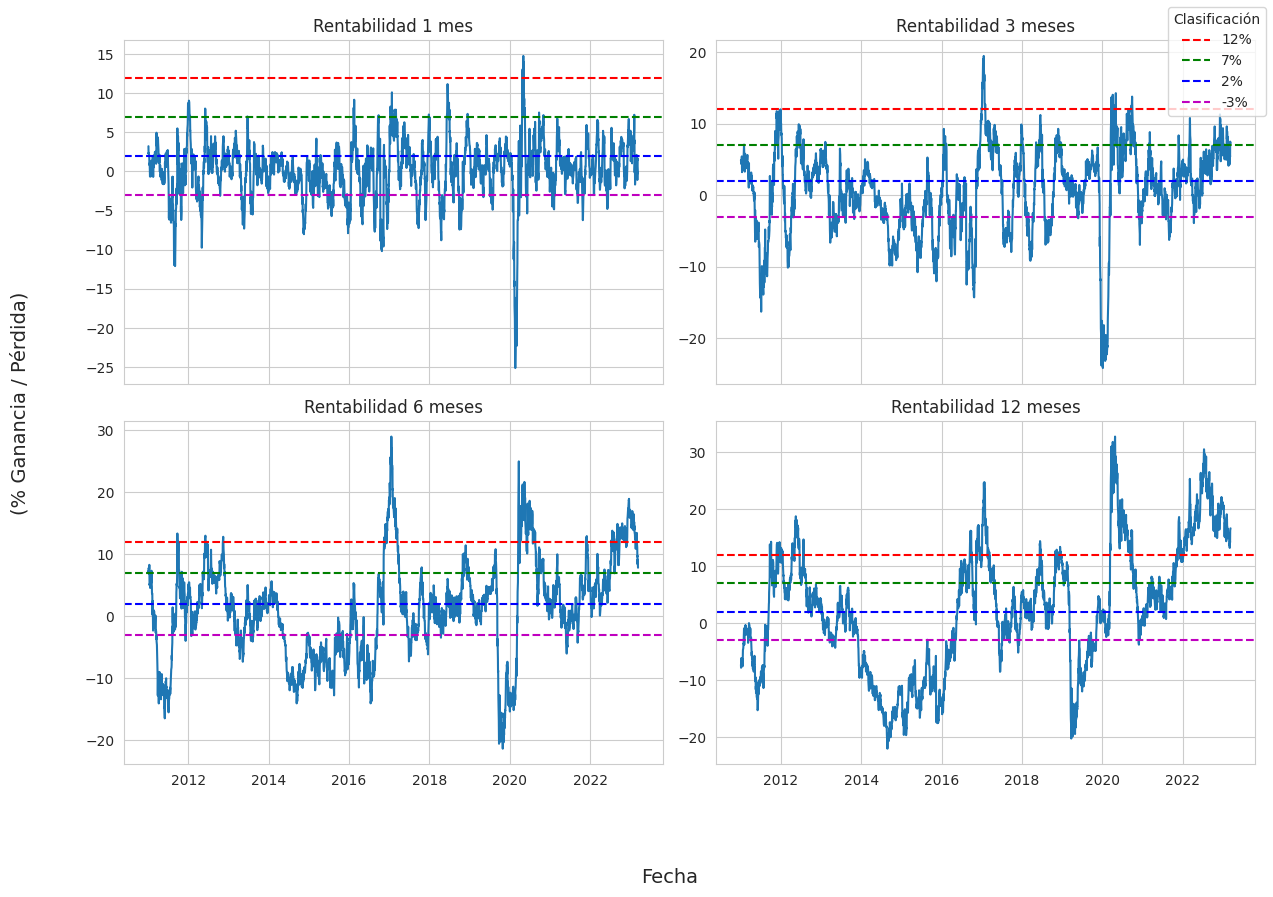

In [ ]:
# Set the style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot each column on a separate graph
sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss1m']*100, data=df_normal_graficos, ax=axes[0, 0])
axes[0, 0].set_title('Rentabilidad 1 mes')
axes[0, 0].set_ylabel('')
axes[0, 0].set_xlabel('')
axes[0, 0].axhline(y=12, color='r', linestyle='--')
axes[0, 0].axhline(y=7, color='g', linestyle='--')
axes[0, 0].axhline(y=2, color='b', linestyle='--')
axes[0, 0].axhline(y=-3, color='m', linestyle='--')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss3m']*100, data=df_normal_graficos , ax=axes[0, 1])
axes[0, 1].set_title('Rentabilidad 3 meses')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].axhline(y=12, color='r', linestyle='--', label='12%')
axes[0, 1].axhline(y=7, color='g', linestyle='--', label='7%')
axes[0, 1].axhline(y=2, color='b', linestyle='--', label='2%')
axes[0, 1].axhline(y=-3, color='m', linestyle='--', label='-3%')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss6m']*100, data=df_normal_graficos , ax=axes[1, 0])
axes[1, 0].set_title('Rentabilidad 6 meses')
axes[1, 0].set_ylabel('')
axes[1, 0].set_xlabel('')
axes[1, 0].axhline(y=12, color='r', linestyle='--')
axes[1, 0].axhline(y=7, color='g', linestyle='--')
axes[1, 0].axhline(y=2, color='b', linestyle='--')
axes[1, 0].axhline(y=-3, color='m', linestyle='--')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss12m']*100, data=df_normal_graficos , ax=axes[1, 1])
axes[1, 1].set_title('Rentabilidad 12 meses')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].axhline(y=12, color='r', linestyle='--')
axes[1, 1].axhline(y=7, color='g', linestyle='--')
axes[1, 1].axhline(y=2, color='b', linestyle='--')
axes[1, 1].axhline(y=-3, color='m', linestyle='--')

# Set Y-axis label for leftmost and bottom subplots
fig.text(-0.05, 0.5, '(% Ganancia / Pérdida)', va='center', rotation='vertical', fontsize=14)

# Set a common X-axis label
fig.text(0.5, -0.1, 'Fecha', ha='center', fontsize=14)

# Add legend
fig.legend(title='Clasificación', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.savefig('Rentabilidad por estrategia.png')
plt.show()


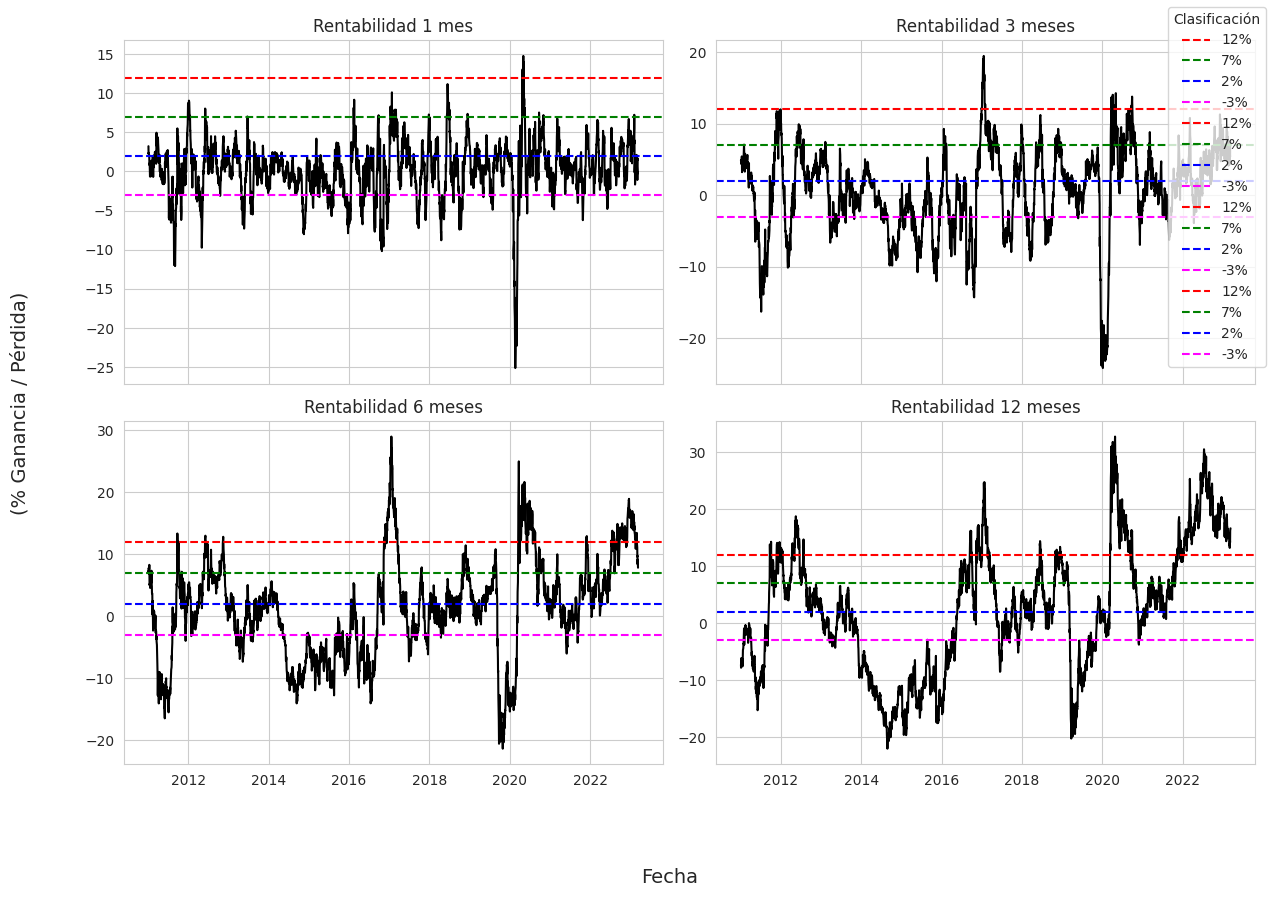

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Define colors for the horizontal lines
line_colors = {'12%': 'red', '7%': 'green', '2%': 'blue', '-3%': 'magenta'}

# Plot each column on a separate graph
sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss1m']*100, data=df_normal_graficos, ax=axes[0, 0], color='black')
axes[0, 0].set_title('Rentabilidad 1 mes')
axes[0, 0].set_ylabel('')
axes[0, 0].set_xlabel('')
axes[0, 0].axhline(y=12, color=line_colors['12%'], linestyle='--', label='12%')
axes[0, 0].axhline(y=7, color=line_colors['7%'], linestyle='--', label='7%')
axes[0, 0].axhline(y=2, color=line_colors['2%'], linestyle='--', label='2%')
axes[0, 0].axhline(y=-3, color=line_colors['-3%'], linestyle='--', label='-3%')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss3m']*100, data=df_normal_graficos, ax=axes[0, 1], color='black')
axes[0, 1].set_title('Rentabilidad 3 meses')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].axhline(y=12, color=line_colors['12%'], linestyle='--', label='12%')
axes[0, 1].axhline(y=7, color=line_colors['7%'], linestyle='--', label='7%')
axes[0, 1].axhline(y=2, color=line_colors['2%'], linestyle='--', label='2%')
axes[0, 1].axhline(y=-3, color=line_colors['-3%'], linestyle='--', label='-3%')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss6m']*100, data=df_normal_graficos, ax=axes[1, 0], color='black')
axes[1, 0].set_title('Rentabilidad 6 meses')
axes[1, 0].set_ylabel('')
axes[1, 0].set_xlabel('')
axes[1, 0].axhline(y=12, color=line_colors['12%'], linestyle='--', label='12%')
axes[1, 0].axhline(y=7, color=line_colors['7%'], linestyle='--', label='7%')
axes[1, 0].axhline(y=2, color=line_colors['2%'], linestyle='--', label='2%')
axes[1, 0].axhline(y=-3, color=line_colors['-3%'], linestyle='--', label='-3%')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss12m']*100, data=df_normal_graficos, ax=axes[1, 1], color='black')
axes[1, 1].set_title('Rentabilidad 12 meses')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].axhline(y=12, color=line_colors['12%'], linestyle='--', label='12%')
axes[1, 1].axhline(y=7, color=line_colors['7%'], linestyle='--', label='7%')
axes[1, 1].axhline(y=2, color=line_colors['2%'], linestyle='--', label='2%')
axes[1, 1].axhline(y=-3, color=line_colors['-3%'], linestyle='--', label='-3%')

# Set Y-axis label for leftmost and bottom subplots
fig.text(-0.05, 0.5, '(% Ganancia / Pérdida)', va='center', rotation='vertical', fontsize=14)

# Set a common X-axis label
fig.text(0.5, -0.1, 'Fecha', ha='center', fontsize=14)

# Add legend
fig.legend(title='Clasificación', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.savefig('Rentabilidad por estrategia.png')
plt.show()



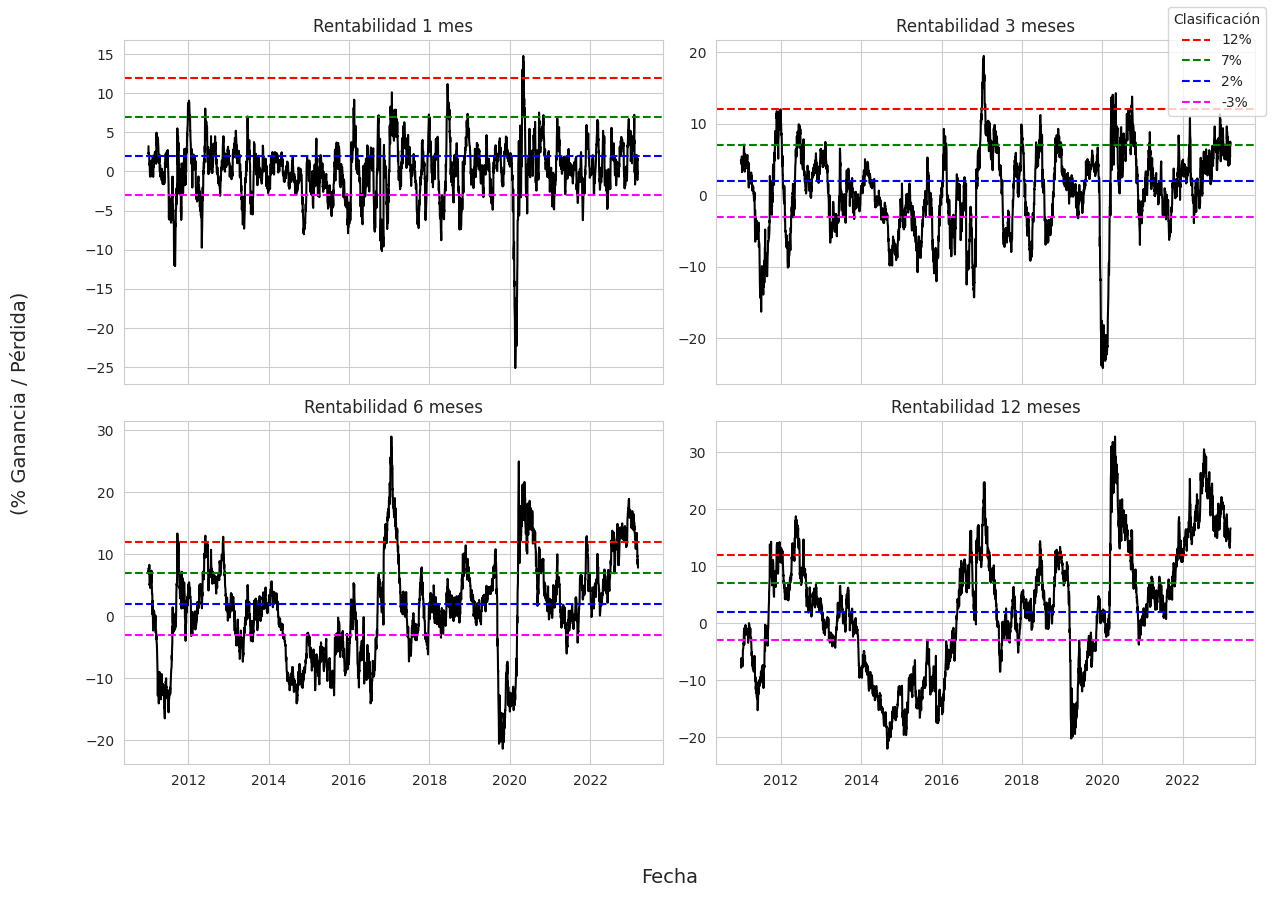

In [ ]:
# Set the style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Define colors for the horizontal lines
line_colors = {'12%': 'red', '7%': 'green', '2%': 'blue', '-3%': 'magenta'}

# Plot each column on a separate graph
sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss1m']*100, data=df_normal_graficos, ax=axes[0, 0], color='black')
axes[0, 0].set_title('Rentabilidad 1 mes')
axes[0, 0].set_ylabel('')
axes[0, 0].set_xlabel('')
axes[0, 0].axhline(y=12, color=line_colors['12%'], linestyle='--')
axes[0, 0].axhline(y=7, color=line_colors['7%'], linestyle='--')
axes[0, 0].axhline(y=2, color=line_colors['2%'], linestyle='--')
axes[0, 0].axhline(y=-3, color=line_colors['-3%'], linestyle='--')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss3m']*100, data=df_normal_graficos, ax=axes[0, 1], color='black')
axes[0, 1].set_title('Rentabilidad 3 meses')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].axhline(y=12, color=line_colors['12%'], linestyle='--')
axes[0, 1].axhline(y=7, color=line_colors['7%'], linestyle='--')
axes[0, 1].axhline(y=2, color=line_colors['2%'], linestyle='--')
axes[0, 1].axhline(y=-3, color=line_colors['-3%'], linestyle='--')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss6m']*100, data=df_normal_graficos, ax=axes[1, 0], color='black')
axes[1, 0].set_title('Rentabilidad 6 meses')
axes[1, 0].set_ylabel('')
axes[1, 0].set_xlabel('')
axes[1, 0].axhline(y=12, color=line_colors['12%'], linestyle='--')
axes[1, 0].axhline(y=7, color=line_colors['7%'], linestyle='--')
axes[1, 0].axhline(y=2, color=line_colors['2%'], linestyle='--')
axes[1, 0].axhline(y=-3, color=line_colors['-3%'], linestyle='--')

sns.lineplot(x='Date', y=df_normal_graficos['ProfitLoss12m']*100, data=df_normal_graficos, ax=axes[1, 1], color='black')
axes[1, 1].set_title('Rentabilidad 12 meses')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].axhline(y=12, color=line_colors['12%'], linestyle='--')
axes[1, 1].axhline(y=7, color=line_colors['7%'], linestyle='--')
axes[1, 1].axhline(y=2, color=line_colors['2%'], linestyle='--')
axes[1, 1].axhline(y=-3, color=line_colors['-3%'], linestyle='--')

# Create custom legend
handles = [
    plt.Line2D([0], [0], color=line_colors['12%'], linestyle='--', label='12%'),
    plt.Line2D([0], [0], color=line_colors['7%'], linestyle='--', label='7%'),
    plt.Line2D([0], [0], color=line_colors['2%'], linestyle='--', label='2%'),
    plt.Line2D([0], [0], color=line_colors['-3%'], linestyle='--', label='-3%'),
]

# Set Y-axis label for leftmost and bottom subplots
fig.text(-0.05, 0.5, '(% Ganancia / Pérdida)', va='center', rotation='vertical', fontsize=14)

# Set a common X-axis label
fig.text(0.5, -0.1, 'Fecha', ha='center', fontsize=14)

# Add custom legend
fig.legend(handles=handles, title='Clasificación', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.savefig('Rentabilidad por estrategia.png')
plt.show()


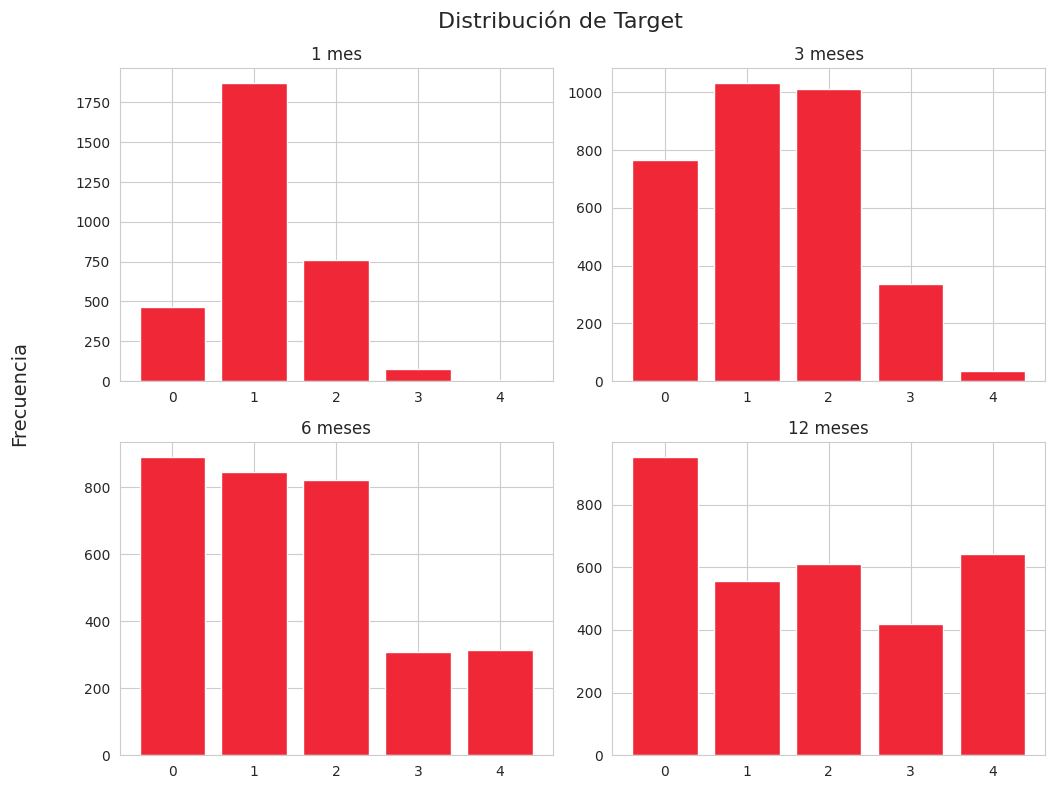

In [ ]:
target_cols = ["multi_tag_1m", "multi_tag_3m", "multi_tag_6m", "multi_tag_12m"]
labels = ["1 mes", "3 meses", "6 meses", "12 meses"]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate through each target column and corresponding subplot
for i, col in enumerate(target_cols):
    # Calculate subplot index
    row = i // 2
    col = target_cols[i]  # Use the column name directly
    # Group data by the current column
    grouped_data = df_normal_graficos .groupby(col).count().reset_index()
    # Plot histogram on the corresponding subplot
    axs[row, i % 2].bar(grouped_data[col], grouped_data["ProfitLoss1m"], color='#EF2737')
    axs[row, i % 2].set_title(labels[i])

# Set a single title for all subplots
fig.suptitle("Distribución de Target", fontsize=16)

# Set Y-axis label for leftmost and bottom subplots
fig.text(-0.05, 0.5, 'Frecuencia', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig('Distribución de Target.png')
plt.show()

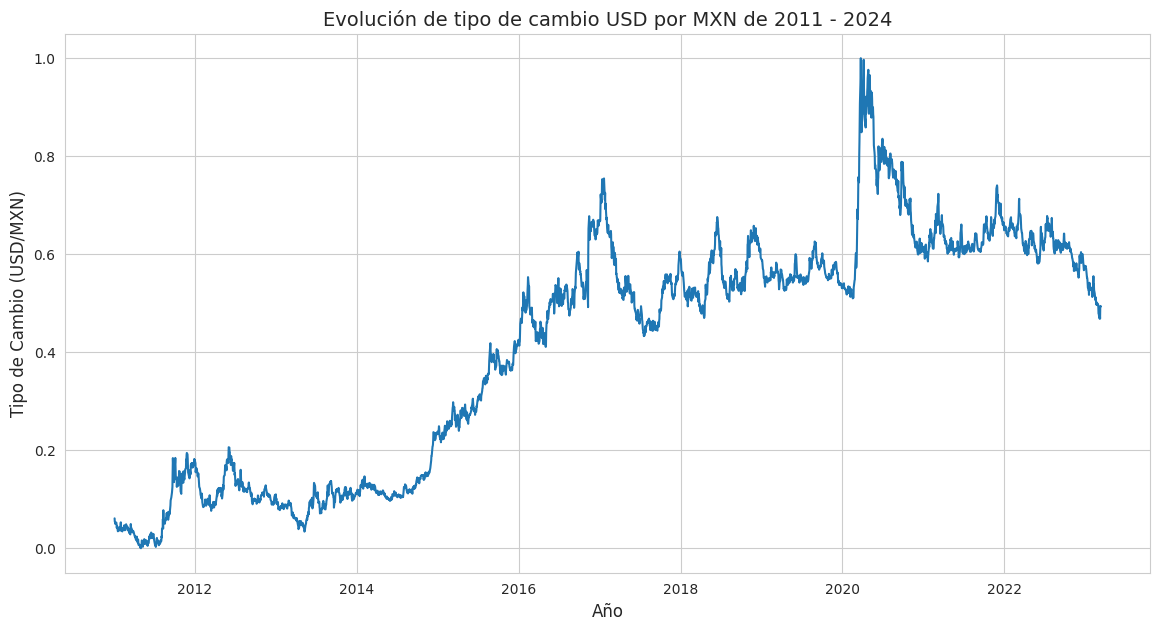

In [ ]:
#Plot MXNUSD
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y=df_normal_graficos ['Open_USDMX'], data=df_normal)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Tipo de Cambio (USD/MXN)", fontsize=12)
# Set title
plt.title("Evolución de tipo de cambio USD por MXN de 2011 - 2024", fontsize=14)
plt.show()

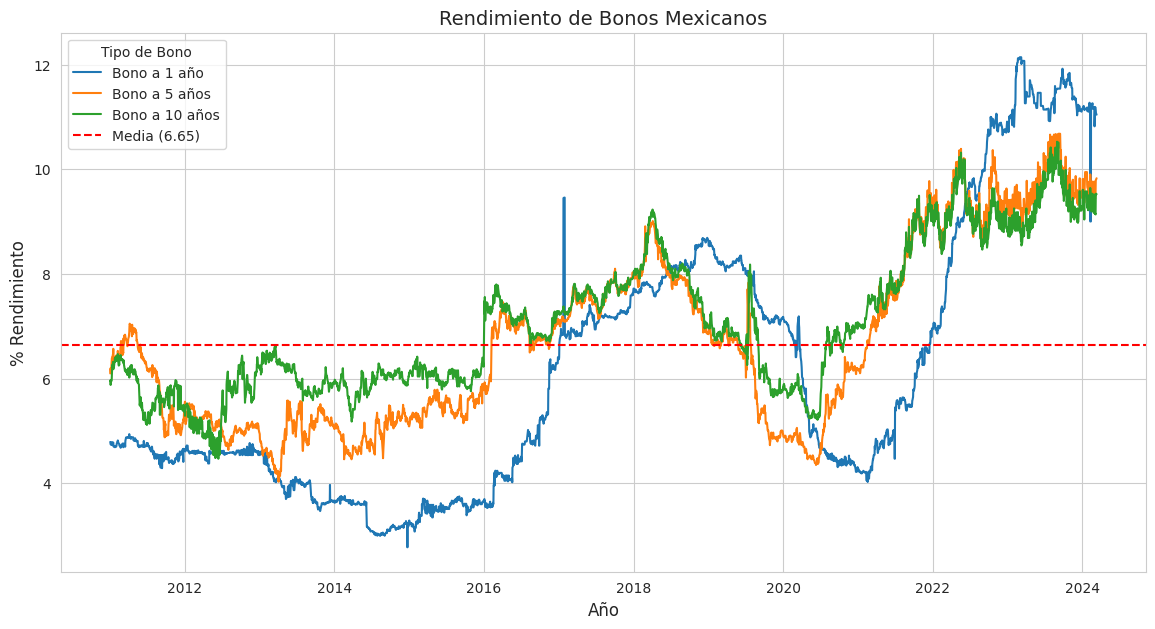

In [ ]:

# Calcular la media de las tres series
mean_1_year = df['Open_1_year_MX'].mean()
mean_5_year = df['Open_5_year_MX'].mean()
mean_10_year = df['Open_10_year_MX'].mean()
overall_mean = (mean_1_year + mean_5_year + mean_10_year) / 3

# Plot bonos
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Open_1_year_MX', label='Bono a 1 año')
sns.lineplot(data=df, x='Date', y='Open_5_year_MX', label='Bono a 5 años')
sns.lineplot(data=df, x='Date', y='Open_10_year_MX', label='Bono a 10 años')

# Agregar línea horizontal con la media de las tres series
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Media ({overall_mean:.2f})')

plt.xlabel("Año", fontsize=12)
plt.ylabel("% Rendimiento", fontsize=12)
plt.title("Rendimiento de Bonos Mexicanos", fontsize=14)
plt.legend(title='Tipo de Bono')
plt.show()


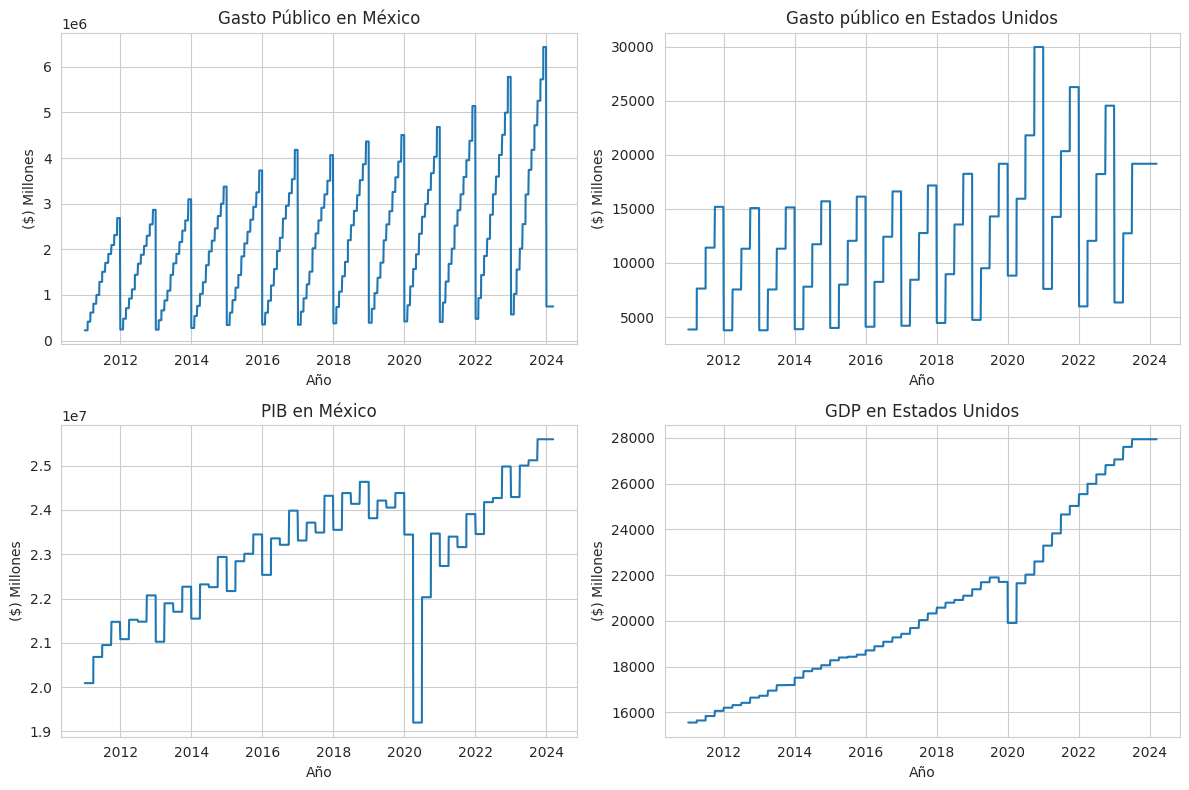

In [ ]:
variables = ['GastoPublico_MX', 'Gasto_publico_US', 'PIB_MX', 'GDP_US']
titulos = ['Gasto Público en México', 'Gasto público en Estados Unidos', 'PIB en México', 'GDP en Estados Unidos']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    axs[row, col].plot(df['Date'], df[var], label=var)
    axs[row, col].set_title(titulos[i])
    axs[row, col].set_xlabel('Año')
    axs[row, col].set_ylabel('($) Millones')

plt.tight_layout()

plt.show()


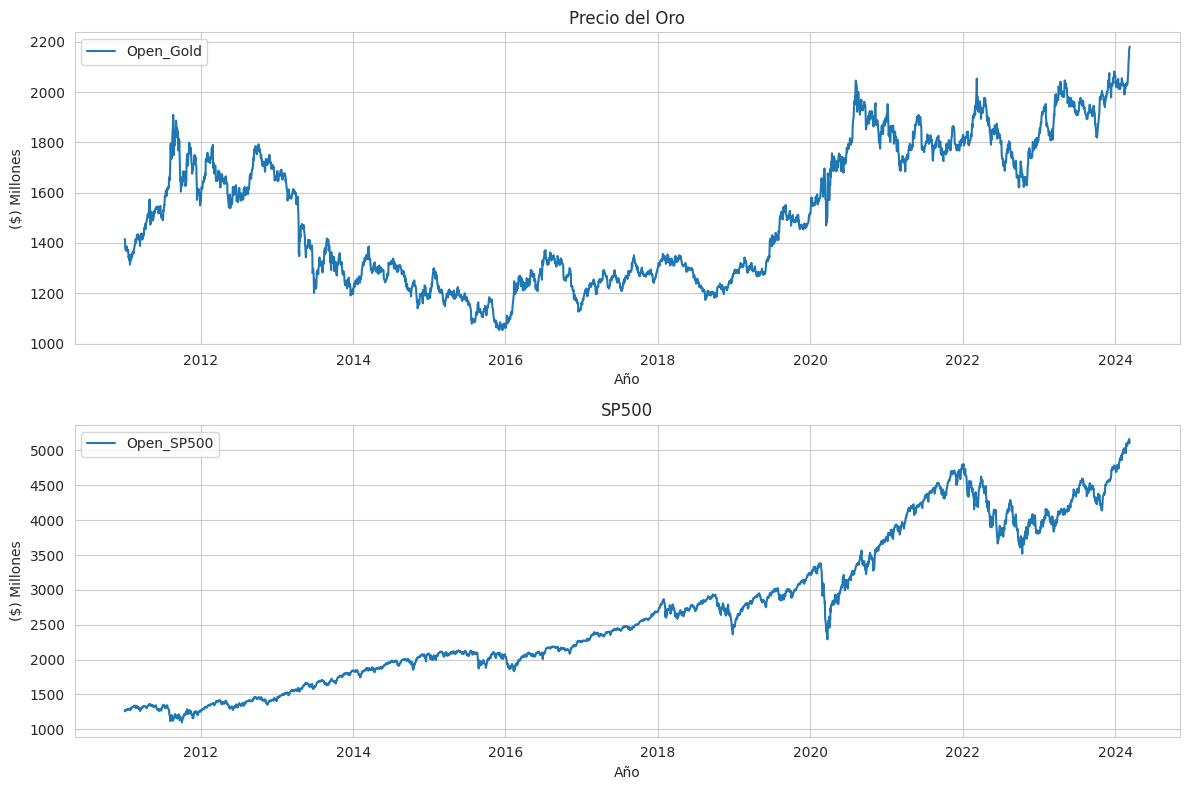

In [ ]:
import matplotlib.pyplot as plt
# Definir los datos para las subtramas
variables = ['Open_Gold', 'Open_SP500']
titulos = ['Precio del Oro', 'Indice SP500']

fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

# Iterar sobre cada variable y graficarla en una subtrama
for i, var in enumerate(variables):
    axs[i].plot(df['Date'], df[var], label=var)
    axs[i].set_title(titulos[i])
    axs[i].set_xlabel('Año')
    axs[i].set_ylabel('($) ')
plt.tight_layout()


plt.show()


In [ ]:
df.columns

Index(['Date', 'Open_USDMX', 'Open_Oil', 'Open_Gold', 'Open_SP500',
       'Open_1_year_MX', 'Open_5_year_MX', 'Open_10_year_MX', 'Open_1_year_US',
       'Open_5_year_US', 'Open_10_year_US', 'UnemploymentRate_US', 'M2_SA_US',
       'CPI_US', 'GastoPublico_MX', 'FFER_US', 'Expected_Inflation_US',
       'Inflacion_mensual', 'Inflacion_general_acumulada',
       'Inflacion_general_anual', 'Inflacion_subyacente_mensual',
       'Inflacion_subyacente_acumulada', 'Inflacion_subyacente_anual',
       'GDP_US', 'PIB_MX', 'Gasto_publico_US', 'Deuda_PIB_US', 'Day', 'Year',
       '1m_days_shift', '3m_days_shift', '6m_days_shift', '12m_days_shift',
       'f_1m', 'f_3m', 'f_6m', 'f_12m', 'ProfitLoss1m', 'ProfitLoss3m',
       'ProfitLoss6m', 'ProfitLoss12m', 'multi_tag_1m', 'multi_tag_3m',
       'multi_tag_6m', 'multi_tag_12m'],
      dtype='object')

## Feature Selection

### Information Value (IV)

In [ ]:
df['target_1m']=np.where((df['multi_tag_1m']>1),1,0)
df['target_3m']=np.where((df['multi_tag_3m']>1),1,0)
df['target_6m']=np.where((df['multi_tag_6m']>1),1,0)
df['target_12m']=np.where((df['multi_tag_12m']>2),1,0)

In [ ]:
def calculate_iv(df, feature, target):
    """
    Calcula el Information Value (IV) de una variable para una columna objetivo.

    Args:
    - df: DataFrame que contiene las variables y la columna objetivo.
    - feature: Nombre de la variable a calcular el IV.
    - target: Nombre de la columna objetivo.

    Returns:
    - iv: Valor del Information Value (IV) de la variable.
    """
    grouped = df.groupby(pd.qcut(df[feature], q=10, duplicates='drop'))[target]
    profit_rate = grouped.mean()
    loss_rate = 1 - profit_rate
    epsilon = 1e-8
    profit_dist = grouped.sum() / df[target].sum() + epsilon
    loss_dist = (grouped.count() - grouped.sum()) / (len(df) - df[target].sum() + epsilon)
    iv = np.sum((profit_dist - loss_dist) * np.log(profit_dist / loss_dist))
    return iv

def calculate_iv_for_specific_features(df, features, targets):
    """
    Calcula el Information Value (IV) de features específicas para múltiples columnas objetivo.

    Args:
    - df: DataFrame que contiene las variables y las columnas objetivo.
    - features: Lista de nombres de las features para las cuales calcular el IV.
    - targets: Lista de nombres de las columnas objetivo.

    Returns:
    - iv_dict: Diccionario que contiene el IV de features específicas para cada columna objetivo.
    """
    iv_dict = {}
    for target in targets:
        iv_dict[target] = {}
        for feature in features:
            iv = calculate_iv(df, feature, target)
            iv_dict[target][feature] = iv
    return iv_dict


features_of_interest = ['Open_USDMX', 'Open_Oil', 'Open_Gold', 'Open_SP500', 'Open_1_year_MX',
                        'Open_5_year_MX', 'Open_10_year_MX', 'Open_1_year_US', 'Open_5_year_US',
                        'Open_10_year_US', 'UnemploymentRate_US', 'M2_SA_US', 'CPI_US',
                        'GastoPublico_MX', 'FFER_US', 'Expected_Inflation_US',
                        'Inflacion_mensual', 'Inflacion_general_acumulada',
                        'Inflacion_general_anual', 'Inflacion_subyacente_mensual',
                        'Inflacion_subyacente_acumulada', 'Inflacion_subyacente_anual',
                        'GDP_US', 'PIB_MX', 'Gasto_publico_US', 'Deuda_PIB_US']
targets = ['target_1m', 'target_3m', 'target_6m', 'target_12m']
iv_results = calculate_iv_for_specific_features(df.dropna(), features_of_interest, targets)

for target, ivs in iv_results.items():
    print(f"Target: {target}")
    ivs_list=[]
    for feature, iv in ivs.items():
        display(f"IV'{feature}': {round(iv,4)}")
    print("\n")

Target: target_1m


"IV'Open_USDMX': 0.3762"

"IV'Open_Oil': 0.0874"

"IV'Open_Gold': 0.1945"

"IV'Open_SP500': 0.3351"

"IV'Open_1_year_MX': 0.4356"

"IV'Open_5_year_MX': 0.1383"

"IV'Open_10_year_MX': 0.18"

"IV'Open_1_year_US': 0.1473"

"IV'Open_5_year_US': 0.2463"

"IV'Open_10_year_US': 0.199"

"IV'UnemploymentRate_US': 0.4797"

"IV'M2_SA_US': 0.3905"

"IV'CPI_US': 0.1966"

"IV'GastoPublico_MX': 0.1844"

"IV'FFER_US': 0.2028"

"IV'Expected_Inflation_US': 0.1843"

"IV'Inflacion_mensual': 0.2425"

"IV'Inflacion_general_acumulada': 0.2276"

"IV'Inflacion_general_anual': 0.239"

"IV'Inflacion_subyacente_mensual': 0.2606"

"IV'Inflacion_subyacente_acumulada': 0.0823"

"IV'Inflacion_subyacente_anual': 0.2909"

"IV'GDP_US': 0.4187"

"IV'PIB_MX': 0.2786"

"IV'Gasto_publico_US': 0.3358"

"IV'Deuda_PIB_US': 0.1009"



Target: target_3m


"IV'Open_USDMX': 1.0128"

"IV'Open_Oil': 0.3598"

"IV'Open_Gold': 0.3972"

"IV'Open_SP500': 0.8851"

"IV'Open_1_year_MX': 1.183"

"IV'Open_5_year_MX': 0.2933"

"IV'Open_10_year_MX': 0.2245"

"IV'Open_1_year_US': 0.4231"

"IV'Open_5_year_US': 0.2768"

"IV'Open_10_year_US': 0.6567"

"IV'UnemploymentRate_US': 1.0398"

"IV'M2_SA_US': 0.9976"

"IV'CPI_US': 0.7066"

"IV'GastoPublico_MX': 0.327"

"IV'FFER_US': 0.6486"

"IV'Expected_Inflation_US': 0.1424"

"IV'Inflacion_mensual': 0.2987"

"IV'Inflacion_general_acumulada': 0.3473"

"IV'Inflacion_general_anual': 0.3867"

"IV'Inflacion_subyacente_mensual': 0.4949"

"IV'Inflacion_subyacente_acumulada': 0.2909"

"IV'Inflacion_subyacente_anual': 0.9924"

"IV'GDP_US': 0.9983"

"IV'PIB_MX': 0.8845"

"IV'Gasto_publico_US': 0.6318"

"IV'Deuda_PIB_US': 0.3299"



Target: target_6m


"IV'Open_USDMX': 2.0026"

"IV'Open_Oil': 0.3403"

"IV'Open_Gold': 0.7684"

"IV'Open_SP500': 3.6376"

"IV'Open_1_year_MX': 2.3868"

"IV'Open_5_year_MX': 0.739"

"IV'Open_10_year_MX': 0.7612"

"IV'Open_1_year_US': 0.7422"

"IV'Open_5_year_US': 0.362"

"IV'Open_10_year_US': 0.7232"

"IV'UnemploymentRate_US': 3.4426"

"IV'M2_SA_US': 4.0293"

"IV'CPI_US': 1.3964"

"IV'GastoPublico_MX': 0.2526"

"IV'FFER_US': 1.0181"

"IV'Expected_Inflation_US': 0.4585"

"IV'Inflacion_mensual': 0.6702"

"IV'Inflacion_general_acumulada': 0.4951"

"IV'Inflacion_general_anual': 1.3841"

"IV'Inflacion_subyacente_mensual': 0.8491"

"IV'Inflacion_subyacente_acumulada': 0.3845"

"IV'Inflacion_subyacente_anual': 1.5797"

"IV'GDP_US': 4.1145"

"IV'PIB_MX': 1.0116"

"IV'Gasto_publico_US': 0.8458"

"IV'Deuda_PIB_US': 0.64"



Target: target_12m


"IV'Open_USDMX': 2.0612"

"IV'Open_Oil': 0.427"

"IV'Open_Gold': 1.1227"

"IV'Open_SP500': 3.2758"

"IV'Open_1_year_MX': 7.8301"

"IV'Open_5_year_MX': 1.5231"

"IV'Open_10_year_MX': 1.7341"

"IV'Open_1_year_US': 1.511"

"IV'Open_5_year_US': 3.0246"

"IV'Open_10_year_US': 2.7912"

"IV'UnemploymentRate_US': 1.6533"

"IV'M2_SA_US': inf"

"IV'CPI_US': inf"

"IV'GastoPublico_MX': 0.2788"

"IV'FFER_US': 1.1924"

"IV'Expected_Inflation_US': 0.7622"

"IV'Inflacion_mensual': 0.6131"

"IV'Inflacion_general_acumulada': 0.6138"

"IV'Inflacion_general_anual': inf"

"IV'Inflacion_subyacente_mensual': 1.3465"

"IV'Inflacion_subyacente_acumulada': 0.4515"

"IV'Inflacion_subyacente_anual': inf"

"IV'GDP_US': inf"

"IV'PIB_MX': 0.9601"

"IV'Gasto_publico_US': 1.2265"

"IV'Deuda_PIB_US': 0.7713"

In [ ]:
#IV Daframe by target (1, 3, 6, 12 months)
for target, ivs in iv_results.items():
    ivs_list=[]
    lista=[]
    feat_name=[]
    print (f"\n")
    print(target)
    for feature, iv in ivs.items():
      if iv>0:
        feat_name.append(feature)
        ivs_list.append(iv)
    iv_df=pd.DataFrame({"feature_name":feat_name,"iv_power":ivs_list}).sort_values(by="iv_power",ascending=False).reset_index()
    display(iv_df)



target_1m


index                    feature_name  iv_power
0      10             UnemploymentRate_US  0.479698
1       4                  Open_1_year_MX  0.435631
2      22                          GDP_US  0.418659
3      11                        M2_SA_US  0.390508
4       0                      Open_USDMX  0.376202
5      24                Gasto_publico_US  0.335833
6       3                      Open_SP500  0.335112
7      21      Inflacion_subyacente_anual  0.290932
8      23                          PIB_MX  0.278587
9      19    Inflacion_subyacente_mensual  0.260617
10      8                  Open_5_year_US  0.246311
11     16               Inflacion_mensual  0.242514
12     18         Inflacion_general_anual  0.239028
13     17     Inflacion_general_acumulada  0.227557
14     14                         FFER_US  0.202844
15      9                 Open_10_year_US  0.198966
16     12                          CPI_US  0.196590
17      2                       Open_Gold  0.194482
18     13                 GastoPublico_MX  0.184434
19     15           Expected_Inflation_US  0.184302
20      6                 Open_10_year_MX  0.180044
21      7                  Open_1_year_US  0.147264
22      5                  Open_5_year_MX  0.138287
23     25                    Deuda_PIB_US  0.100882
24      1                        Open_Oil  0.087397
25     20  Inflacion_subyacente_acumulada  0.082267



target_3m


index                    feature_name  iv_power
0       4                  Open_1_year_MX  1.182964
1      10             UnemploymentRate_US  1.039848
2       0                      Open_USDMX  1.012756
3      22                          GDP_US  0.998265
4      11                        M2_SA_US  0.997638
5      21      Inflacion_subyacente_anual  0.992447
6       3                      Open_SP500  0.885051
7      23                          PIB_MX  0.884533
8      12                          CPI_US  0.706619
9       9                 Open_10_year_US  0.656694
10     14                         FFER_US  0.648600
11     24                Gasto_publico_US  0.631771
12     19    Inflacion_subyacente_mensual  0.494950
13      7                  Open_1_year_US  0.423083
14      2                       Open_Gold  0.397173
15     18         Inflacion_general_anual  0.386685
16      1                        Open_Oil  0.359765
17     17     Inflacion_general_acumulada  0.347265
18     25                    Deuda_PIB_US  0.329912
19     13                 GastoPublico_MX  0.326983
20     16               Inflacion_mensual  0.298722
21      5                  Open_5_year_MX  0.293340
22     20  Inflacion_subyacente_acumulada  0.290852
23      8                  Open_5_year_US  0.276753
24      6                 Open_10_year_MX  0.224466
25     15           Expected_Inflation_US  0.142437



target_6m


index                    feature_name  iv_power
0      22                          GDP_US  4.114546
1      11                        M2_SA_US  4.029252
2       3                      Open_SP500  3.637619
3      10             UnemploymentRate_US  3.442646
4       4                  Open_1_year_MX  2.386762
5       0                      Open_USDMX  2.002619
6      21      Inflacion_subyacente_anual  1.579654
7      12                          CPI_US  1.396351
8      18         Inflacion_general_anual  1.384059
9      14                         FFER_US  1.018124
10     23                          PIB_MX  1.011610
11     19    Inflacion_subyacente_mensual  0.849138
12     24                Gasto_publico_US  0.845778
13      2                       Open_Gold  0.768445
14      6                 Open_10_year_MX  0.761208
15      7                  Open_1_year_US  0.742235
16      5                  Open_5_year_MX  0.738997
17      9                 Open_10_year_US  0.723215
18     16               Inflacion_mensual  0.670202
19     25                    Deuda_PIB_US  0.640042
20     17     Inflacion_general_acumulada  0.495148
21     15           Expected_Inflation_US  0.458494
22     20  Inflacion_subyacente_acumulada  0.384542
23      8                  Open_5_year_US  0.361970
24      1                        Open_Oil  0.340263
25     13                 GastoPublico_MX  0.252613



target_12m


index                    feature_name  iv_power
0      18         Inflacion_general_anual       inf
1      21      Inflacion_subyacente_anual       inf
2      22                          GDP_US       inf
3      12                          CPI_US       inf
4      11                        M2_SA_US       inf
5       4                  Open_1_year_MX  7.830124
6       3                      Open_SP500  3.275782
7       8                  Open_5_year_US  3.024584
8       9                 Open_10_year_US  2.791195
9       0                      Open_USDMX  2.061191
10      6                 Open_10_year_MX  1.734094
11     10             UnemploymentRate_US  1.653347
12      5                  Open_5_year_MX  1.523119
13      7                  Open_1_year_US  1.510953
14     19    Inflacion_subyacente_mensual  1.346480
15     24                Gasto_publico_US  1.226531
16     14                         FFER_US  1.192374
17      2                       Open_Gold  1.122678
18     23                          PIB_MX  0.960135
19     25                    Deuda_PIB_US  0.771339
20     15           Expected_Inflation_US  0.762224
21     17     Inflacion_general_acumulada  0.613766
22     16               Inflacion_mensual  0.613075
23     20  Inflacion_subyacente_acumulada  0.451549
24      1                        Open_Oil  0.427016
25     13                 GastoPublico_MX  0.278822

In [ ]:
iv_df_list = []
for target, ivs in iv_results.items():
    ivs_list=[]
    lista=[]
    feat_name=[]
    print(target)
    for feature, iv in ivs.items():
      if iv>0:
        feat_name.append(feature)
        ivs_list.append(iv)
    iv_df=pd.DataFrame({"feature_name":feat_name,"iv_power":ivs_list}).sort_values(by="iv_power",ascending=False).reset_index()
    lista.append(feat_name)
    print(lista)
    iv_df_list.append(iv_df)

target_1m
[['Open_USDMX', 'Open_Oil', 'Open_Gold', 'Open_SP500', 'Open_1_year_MX', 'Open_5_year_MX', 'Open_10_year_MX', 'Open_1_year_US', 'Open_5_year_US', 'Open_10_year_US', 'UnemploymentRate_US', 'M2_SA_US', 'CPI_US', 'GastoPublico_MX', 'FFER_US', 'Expected_Inflation_US', 'Inflacion_mensual', 'Inflacion_general_acumulada', 'Inflacion_general_anual', 'Inflacion_subyacente_mensual', 'Inflacion_subyacente_acumulada', 'Inflacion_subyacente_anual', 'GDP_US', 'PIB_MX', 'Gasto_publico_US', 'Deuda_PIB_US']]
target_3m
[['Open_USDMX', 'Open_Oil', 'Open_Gold', 'Open_SP500', 'Open_1_year_MX', 'Open_5_year_MX', 'Open_10_year_MX', 'Open_1_year_US', 'Open_5_year_US', 'Open_10_year_US', 'UnemploymentRate_US', 'M2_SA_US', 'CPI_US', 'GastoPublico_MX', 'FFER_US', 'Expected_Inflation_US', 'Inflacion_mensual', 'Inflacion_general_acumulada', 'Inflacion_general_anual', 'Inflacion_subyacente_mensual', 'Inflacion_subyacente_acumulada', 'Inflacion_subyacente_anual', 'GDP_US', 'PIB_MX', 'Gasto_publico_US', 'De

### Correlation

[('Open_SP500',
  3,
  M2_SA_US    0.975797
  CPI_US      0.936459
  GDP_US      0.966777
  Name: Open_SP500, dtype: float64),
 ('Open_1_year_MX',
  2,
  Open_1_year_US    0.938450
  FFER_US           0.902003
  Name: Open_1_year_MX, dtype: float64),
 ('Open_5_year_MX',
  1,
  Open_10_year_MX    0.9507
  Name: Open_5_year_MX, dtype: float64),
 ('Open_10_year_MX',
  1,
  Open_5_year_MX    0.9507
  Name: Open_10_year_MX, dtype: float64),
 ('Open_1_year_US',
  2,
  Open_1_year_MX    0.938450
  FFER_US           0.918773
  Name: Open_1_year_US, dtype: float64),
 ('UnemploymentRate_US',
  1,
  PIB_MX    0.912159
  Name: UnemploymentRate_US, dtype: float64),
 ('M2_SA_US',
  3,
  Open_SP500    0.975797
  CPI_US        0.943174
  GDP_US        0.968506
  Name: M2_SA_US, dtype: float64),
 ('CPI_US',
  3,
  Open_SP500    0.936459
  M2_SA_US      0.943174
  GDP_US        0.984577
  Name: CPI_US, dtype: float64),
 ('FFER_US',
  2,
  Open_1_year_MX    0.902003
  Open_1_year_US    0.918773
  Name: F

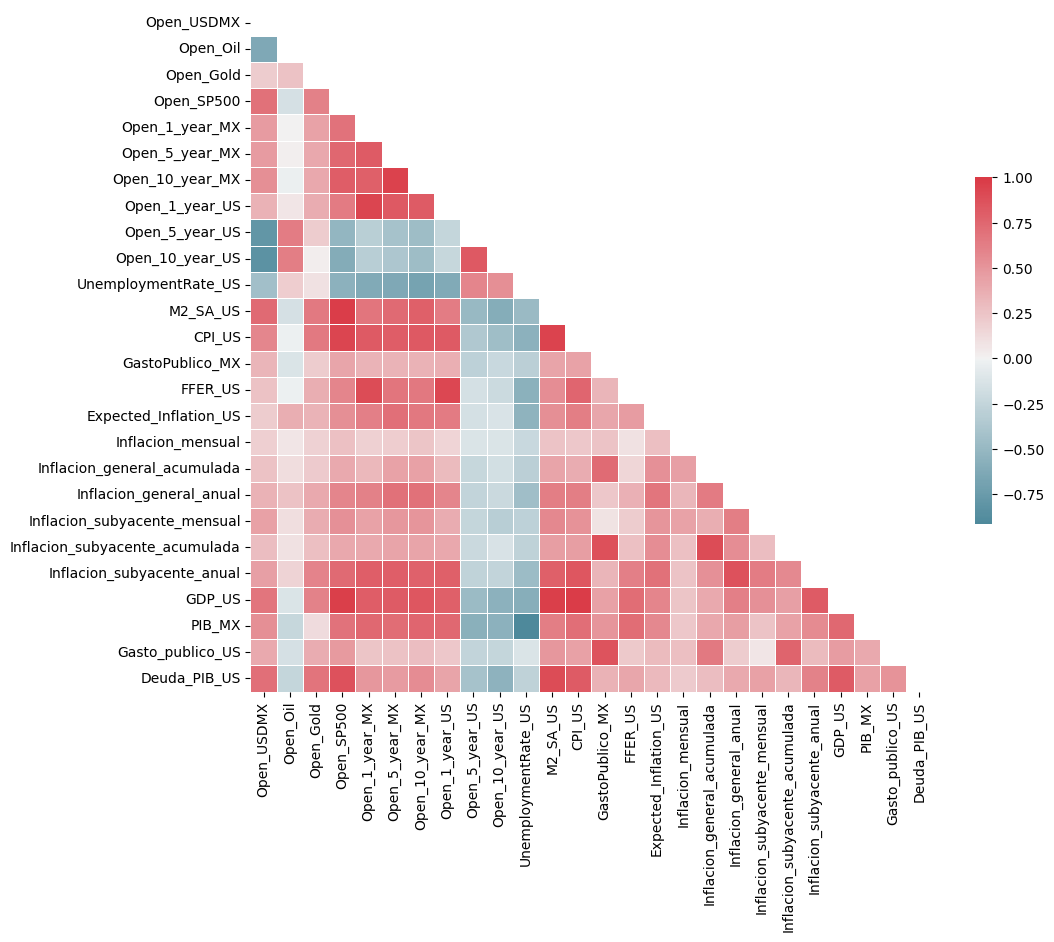

In [ ]:
# Compute the correlation matrix
corr = df_normal[features].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_TH = 0.9
n_corr_list = []
corr_feats_list = []

for f in features:
    #get correlation entries for the feature
    corr_f = corr[f][[col for col in features if col!=f]]
    #work with absolute value
    corr_f_abs = corr_f.abs()
    #get features above corr TH
    corr_ht_th = corr_f_abs[corr_f_abs>corr_TH]
    n_corr_list.append(corr_ht_th.shape[0])
    corr_feats_list.append(corr_ht_th)

corr_relations = [(feat, n, feats_corr) for n, feats_corr, feat in zip(n_corr_list, corr_feats_list, features) if n>0]
corr_relations

### Selection

In [ ]:
df_corr = df_normal[features].corr()
df_corr

Open_USDMX  Open_Oil  Open_Gold  Open_SP500  \
Open_USDMX                        1.000000 -0.631484   0.206739    0.700357   
Open_Oil                         -0.631484  1.000000   0.267697   -0.151155   
Open_Gold                         0.206739  0.267697   1.000000    0.605747   
Open_SP500                        0.700357 -0.151155   0.605747    1.000000   
Open_1_year_MX                    0.473208  0.002281   0.429355    0.687630   
Open_5_year_MX                    0.476044  0.021500   0.399146    0.750302   
Open_10_year_MX                   0.532684 -0.029707   0.401967    0.802524   
Open_1_year_US                    0.345675  0.064447   0.378091    0.641852   
Open_5_year_US                   -0.795629  0.638354   0.205328   -0.519440   
Open_10_year_US                  -0.826524  0.626432   0.027266   -0.605332   
UnemploymentRate_US              -0.439562  0.193943   0.088896   -0.555111   
M2_SA_US                          0.734827 -0.153347   0.651367    0.975797   
CPI_US                            0.578870 -0.016374   0.654659    0.936459   
GastoPublico_MX                   0.331647 -0.117869   0.204609    0.413760   
FFER_US                           0.265286 -0.018341   0.366248    0.585125   
Expected_Inflation_US             0.203934  0.367247   0.337024    0.536350   
Inflacion_mensual                 0.192067  0.067736   0.177298    0.268125   
Inflacion_general_acumulada       0.266738  0.111873   0.212989    0.388665   
Inflacion_general_anual           0.345004  0.266960   0.392854    0.585410   
Inflacion_subyacente_mensual      0.435226  0.104065   0.375634    0.524507   
Inflacion_subyacente_acumulada    0.284454  0.091602   0.277536    0.402080   
Inflacion_subyacente_anual        0.448954  0.169909   0.596462    0.731340   
GDP_US                            0.675218 -0.126714   0.601437    0.966777   
PIB_MX                            0.536389 -0.234462   0.120796    0.690881   
Gasto_publico_US                  0.388664 -0.156510   0.373946    0.484007   
Deuda_PIB_US                      0.702478 -0.243802   0.681658    0.865859   

                                Open_1_year_MX  Open_5_year_MX  \
Open_USDMX                            0.473208        0.476044   
Open_Oil                              0.002281        0.021500   
Open_Gold                             0.429355        0.399146   
Open_SP500                            0.687630        0.750302   
Open_1_year_MX                        1.000000        0.813679   
Open_5_year_MX                        0.813679        1.000000   
Open_10_year_MX                       0.787546        0.950700   
Open_1_year_US                        0.938450        0.833173   
Open_5_year_US                       -0.299821       -0.411936   
Open_10_year_US                      -0.318481       -0.376304   
UnemploymentRate_US                  -0.616915       -0.632972   
M2_SA_US                              0.672511        0.733025   
CPI_US                                0.825517        0.801856   
GastoPublico_MX                       0.339898        0.337815   
FFER_US                               0.902003        0.674010   
Expected_Inflation_US                 0.613601        0.707358   
Inflacion_mensual                     0.181082        0.198201   
Inflacion_general_acumulada           0.314905        0.429668   
Inflacion_general_anual               0.609156        0.697765   
Inflacion_subyacente_mensual          0.429863        0.498512   
Inflacion_subyacente_acumulada        0.390273        0.424637   
Inflacion_subyacente_anual            0.796418        0.792126   
GDP_US                                0.800171        0.807371   
PIB_MX                                0.741158        0.719332   
Gasto_publico_US                      0.242943        0.260595   
Deuda_PIB_US                          0.492306        0.475073   

                                Open_10_year_MX  Open_1_year_US  \
Open_USDMX                             0.532684 

In [ ]:
for x in features:
  print(f"{x}:  {df_corr[(df_corr[features]>0.90)&(df_corr[features]<0.9999)][x].count()}")

Open_USDMX:  0
Open_Oil:  0
Open_Gold:  0
Open_SP500:  3
Open_1_year_MX:  2
Open_5_year_MX:  1
Open_10_year_MX:  1
Open_1_year_US:  2
Open_5_year_US:  0
Open_10_year_US:  0
UnemploymentRate_US:  0
M2_SA_US:  3
CPI_US:  3
GastoPublico_MX:  0
FFER_US:  2
Expected_Inflation_US:  0
Inflacion_mensual:  0
Inflacion_general_acumulada:  0
Inflacion_general_anual:  0
Inflacion_subyacente_mensual:  0
Inflacion_subyacente_acumulada:  0
Inflacion_subyacente_anual:  0
GDP_US:  3
PIB_MX:  0
Gasto_publico_US:  0
Deuda_PIB_US:  0


In [ ]:
print("Open_SP500 is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["Open_SP500"].dropna(),"\n")

print("M2_SA_US is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["M2_SA_US"].dropna(),"\n")

print("CPI_US is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["CPI_US"].dropna(),"\n")

print("GDP_US is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["GDP_US"].dropna(),"\n")

print("Open_1_year_MX is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["Open_1_year_MX"].dropna(),"\n")

print("Open_5_year_MX is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["Open_5_year_MX"].dropna(),"\n")

print("GastoPublico_MX is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["GastoPublico_MX"].dropna(),"\n")

print("Inflacion_general_acumulada is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["Inflacion_general_acumulada"].dropna(),"\n")

print("Inflacion_general_anual is highly correlated with:")
print(df_corr[(df_corr[features]>0.9)&(df_corr[features]<0.9999)]["Inflacion_general_anual"].dropna(),"\n")

Open_SP500 is highly correlated with:
M2_SA_US    0.975797
CPI_US      0.936459
GDP_US      0.966777
Name: Open_SP500, dtype: float64 

M2_SA_US is highly correlated with:
Open_SP500    0.975797
CPI_US        0.943174
GDP_US        0.968506
Name: M2_SA_US, dtype: float64 

CPI_US is highly correlated with:
Open_SP500    0.936459
M2_SA_US      0.943174
GDP_US        0.984577
Name: CPI_US, dtype: float64 

GDP_US is highly correlated with:
Open_SP500    0.966777
M2_SA_US      0.968506
CPI_US        0.984577
Name: GDP_US, dtype: float64 

Open_1_year_MX is highly correlated with:
Open_1_year_US    0.938450
FFER_US           0.902003
Name: Open_1_year_MX, dtype: float64 

Open_5_year_MX is highly correlated with:
Open_10_year_MX    0.9507
Name: Open_5_year_MX, dtype: float64 

GastoPublico_MX is highly correlated with:
Series([], Name: GastoPublico_MX, dtype: float64) 

Inflacion_general_acumulada is highly correlated with:
Series([], Name: Inflacion_general_acumulada, dtype: float64) 

In

In [ ]:
high_corr = ["Open_SP500", "M2_SA_US", "CPI_US", "GDP_US","Open_1_year_MX", "Open_1_year_US","Open_5_year_MX","Open_10_year_MX", "GastoPublico_MX", "Gasto_publico_US", "Inflacion_general_acumulada" ,"Inflacion_subyacente_acumulada", "Inflacion_general_anual","Inflacion_subyacente_anual" ]
df_high_corr = df_normal[high_corr].corr().reset_index()
df_high_corr["feature_name"] = df_high_corr["index"]
df_high_corr.drop(columns="index", inplace=True)
df_high_corr

Open_SP500  M2_SA_US    CPI_US    GDP_US  Open_1_year_MX  Open_1_year_US  \
0     1.000000  0.975797  0.936459  0.966777        0.687630        0.641852   
1     0.975797  1.000000  0.943174  0.968506        0.672511        0.635949   
2     0.936459  0.943174  1.000000  0.984577        0.825517        0.824358   
3     0.966777  0.968506  0.984577  1.000000        0.800171        0.785394   
4     0.687630  0.672511  0.825517  0.800171        1.000000        0.938450   
5     0.641852  0.635949  0.824358  0.785394        0.938450        1.000000   
6     0.750302  0.733025  0.801856  0.807371        0.813679        0.833173   
7     0.802524  0.785518  0.834777  0.849169        0.787546        0.817920   
8     0.413760  0.424329  0.428741  0.446953        0.339898        0.358528   
9     0.484007  0.498532  0.439144  0.465410        0.242943        0.229061   
10    0.388665  0.418884  0.375899  0.388176        0.314905        0.303350   
11    0.402080  0.455262  0.454949  0.451602        0.390273        0.402085   
12    0.585410  0.621454  0.623458  0.614798        0.609156        0.586358   
13    0.731340  0.790265  0.843756  0.813609        0.796418        0.785460   

    Open_5_year_MX  Open_10_year_MX  GastoPublico_MX  Gasto_publico_US  \
0         0.750302         0.802524         0.413760          0.484007   
1         0.733025         0.785518         0.424329          0.498532   
2         0.801856         0.834777         0.428741          0.439144   
3         0.807371         0.849169         0.446953          0.465410   
4         0.813679         0.787546         0.339898          0.242943   
5         0.833173         0.817920         0.358528          0.229061   
6         1.000000         0.950700         0.337815          0.260595   
7         0.950700         1.000000         0.349379          0.286785   
8         0.337815         0.349379         1.000000          0.858585   
9         0.260595         0.286785         0.858585          1.000000   
10        0.429668         0.441404         0.723772          0.651625   
11        0.424637         0.419373         0.877563          0.762989   
12        0.697765         0.695697         0.227152          0.206337   
13        0.792126         0.775949         0.334145          0.300030   

    Inflacion_general_acumulada  Inflacion_subyacente_acumulada  \
0                      0.388665                        0.402080   
1                      0.418884                        0.455262   
2                      0.375899                        0.454949   
3                      0.388176                        0.451602   
4                      0.314905                        0.390273   
5                      0.303350                        0.402085   
6                      0.429668                        0.424637   
7                      0.441404                        0.419373   
8                      0.723772                        0.877563   
9                      0.651625                        0.762989   
10                     1.000000                        0.897994   
11                     0.897994                        1.000000   
12                     0.645544                        0.540958   
13                     0.523768                        0.565729   

    Inflacion_general_anual  Inflacion_subyacente_anual  \
0                  0.585410                    0.731340   
1                  0.621454                    0.790265   
2                  0.623458                    0.843756   
3                  0.614798                    0.813609   
4                  0.609156                    0.796418   
5                  0.586358                    0.785460   
6                  0.697765                    0.792126   
7                  0.695697                    0.775949   
8                  0.227152                    0.334145   
9                  0.206337                    0.300030   
10                 0.645544          

In [ ]:
#IV Power 1 month features
df_high_corr.merge(iv_df_list[0].loc[iv_df_list[0]["feature_name"].isin(high_corr)], how='inner', on='feature_name')[['feature_name','iv_power']]

feature_name  iv_power
0                       Open_SP500  0.335112
1                         M2_SA_US  0.390508
2                           CPI_US  0.196590
3                           GDP_US  0.418659
4                   Open_1_year_MX  0.435631
5                   Open_1_year_US  0.147264
6                   Open_5_year_MX  0.138287
7                  Open_10_year_MX  0.180044
8                  GastoPublico_MX  0.184434
9                 Gasto_publico_US  0.335833
10     Inflacion_general_acumulada  0.227557
11  Inflacion_subyacente_acumulada  0.082267
12         Inflacion_general_anual  0.239028
13      Inflacion_subyacente_anual  0.290932

In [ ]:
#IV Power 3 months features
df_high_corr.merge(iv_df_list[1].loc[iv_df_list[1]["feature_name"].isin(high_corr)], how='inner', on='feature_name')[['feature_name','iv_power']]

feature_name  iv_power
0                       Open_SP500  0.885051
1                         M2_SA_US  0.997638
2                           CPI_US  0.706619
3                           GDP_US  0.998265
4                   Open_1_year_MX  1.182964
5                   Open_1_year_US  0.423083
6                   Open_5_year_MX  0.293340
7                  Open_10_year_MX  0.224466
8                  GastoPublico_MX  0.326983
9                 Gasto_publico_US  0.631771
10     Inflacion_general_acumulada  0.347265
11  Inflacion_subyacente_acumulada  0.290852
12         Inflacion_general_anual  0.386685
13      Inflacion_subyacente_anual  0.992447

In [ ]:
#IV Power 6 months features
df_high_corr.merge(iv_df_list[2].loc[iv_df_list[2]["feature_name"].isin(high_corr)], how='inner', on='feature_name')[['feature_name','iv_power']]

feature_name  iv_power
0                       Open_SP500  3.637619
1                         M2_SA_US  4.029252
2                           CPI_US  1.396351
3                           GDP_US  4.114546
4                   Open_1_year_MX  2.386762
5                   Open_1_year_US  0.742235
6                   Open_5_year_MX  0.738997
7                  Open_10_year_MX  0.761208
8                  GastoPublico_MX  0.252613
9                 Gasto_publico_US  0.845778
10     Inflacion_general_acumulada  0.495148
11  Inflacion_subyacente_acumulada  0.384542
12         Inflacion_general_anual  1.384059
13      Inflacion_subyacente_anual  1.579654

In [ ]:
#IV Power 12 months features
df_high_corr.merge(iv_df_list[3].loc[iv_df_list[3]["feature_name"].isin(high_corr)], how='inner', on='feature_name')[['feature_name','iv_power']]

feature_name  iv_power
0                       Open_SP500  3.275782
1                         M2_SA_US       inf
2                           CPI_US       inf
3                           GDP_US       inf
4                   Open_1_year_MX  7.830124
5                   Open_1_year_US  1.510953
6                   Open_5_year_MX  1.523119
7                  Open_10_year_MX  1.734094
8                  GastoPublico_MX  0.278822
9                 Gasto_publico_US  1.226531
10     Inflacion_general_acumulada  0.613766
11  Inflacion_subyacente_acumulada  0.451549
12         Inflacion_general_anual       inf
13      Inflacion_subyacente_anual       inf

In [ ]:
drop_final=drop+["M2_SA_US","CPI_US","GDP_US","Open_1_year_US","Open_5_year_MX","GastoPublico_MX","Inflacion_subyacente_acumulada","Inflacion_general_anual"]
final_features = [c for c in df.columns if c not in drop_final]

#Models

In [ ]:
final_features=final_features[:-4]
final_features

['Open_USDMX',
 'Open_Oil',
 'Open_Gold',
 'Open_SP500',
 'Open_1_year_MX',
 'Open_10_year_MX',
 'Open_5_year_US',
 'Open_10_year_US',
 'UnemploymentRate_US',
 'FFER_US',
 'Expected_Inflation_US',
 'Inflacion_mensual',
 'Inflacion_general_acumulada',
 'Inflacion_subyacente_mensual',
 'Inflacion_subyacente_anual',
 'PIB_MX',
 'Gasto_publico_US',
 'Deuda_PIB_US']

In [ ]:
# Create a dictionary to store the data sets
data_sets = {}
train_dfs = {}
test_dfs = {}

for n in ['1m', '3m', '6m', '12m']:
    # Creating list of columns to select
    selected_columns = final_features + [f'ProfitLoss{n}', f'multi_tag_{n}']

    # Selecting the conlumns of the Data Set and dropping NaN Values
    df_period = df[selected_columns].dropna()
    df_period=df_period.drop(f'ProfitLoss{n}',axis=1)
    globals()[f'df_{n}'] = df_period

    # Dividing the data between train and test
    X_train, X_test, y_train, y_test = train_test_split(df_period[final_features], df_period[f'multi_tag_{n}'], test_size=0.2, shuffle=False)

    df_train = X_train.copy()
    df_train[f'multi_tag_{n}'] = y_train
    df_test = X_test.copy()
    df_test[f'multi_tag_{n}'] = y_test

    # Storing data in dictionaries
    data_sets[f'multi_tag_{n}'] = (X_train, X_test, y_train, y_test)
    train_dfs[f'df_train_{n}'] = df_train
    test_dfs[f'df_test_{n}'] = df_test

# Asign the value of datasets to individual variables
X_train_1m, X_test_1m, y_train_1m, y_test_1m = data_sets['multi_tag_1m']
X_train_3m, X_test_3m, y_train_3m, y_test_3m = data_sets['multi_tag_3m']
X_train_6m, X_test_6m, y_train_6m, y_test_6m = data_sets['multi_tag_6m']
X_train_12m, X_test_12m, y_train_12m, y_test_12m = data_sets['multi_tag_12m']

df_train_1m=train_dfs['df_train_1m']
df_train_3m=train_dfs['df_train_3m']
df_train_6m=train_dfs['df_train_6m']
df_train_12m=train_dfs['df_train_12m']
df_test_1m=test_dfs['df_test_1m']
df_test_3m=test_dfs['df_test_3m']
df_test_6m=test_dfs['df_test_6m']
df_test_12m=test_dfs['df_test_12m']

In [ ]:
print(f"Total datos: {df.shape[0]}")
print(f"Datos 1 mes: {df_1m.shape[0]}, {df.shape[0]- df_1m.shape[0]} menos")
print(f"Datos 3 meses: {df_3m.shape[0]}, {df.shape[0]- df_3m.shape[0]} menos ")
print(f"Datos 6 meses: {df_6m.shape[0]}, {df.shape[0]- df_6m.shape[0]} menos")
print(f"Datos 12 meses:{df_12m.shape[0]}, {df.shape[0]- df_12m.shape[0]} menos ")

Total datos: 3441
Datos 1 mes: 3419, 22 menos
Datos 3 meses: 3377, 64 menos 
Datos 6 meses: 3313, 128 menos
Datos 12 meses:3181, 260 menos 


##Initial models

###Logistic Regression

Puntuación F1 test del modelo multi_tag_1m es: 0.5132772533728069
Puntuación F1 train del modelo multi_tag_1m es: 0.5147855100896054
Recall del modelo multi_tag_1m es: 0.5233918128654971
Precision del modelo multi_tag_1m es: 0.5080929852844389 

Parametros del modelo {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


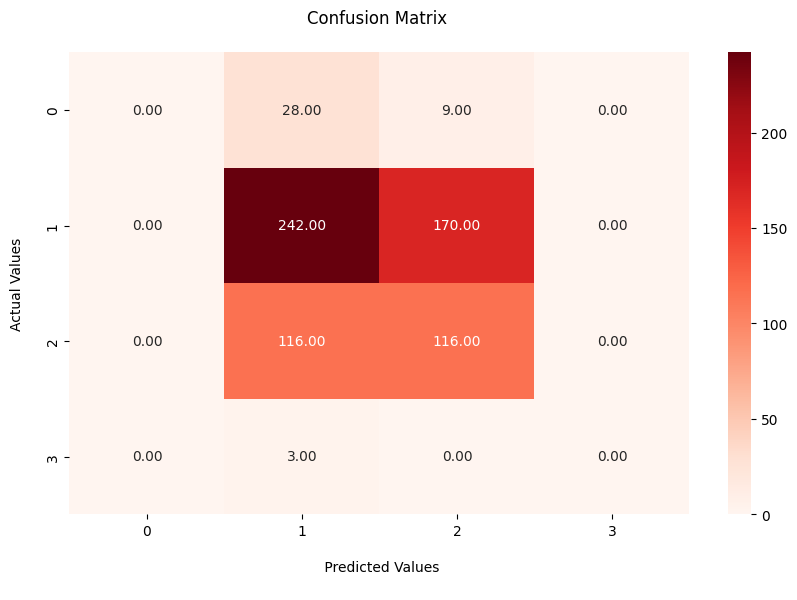

Puntuación F1 test del modelo multi_tag_3m es: 0.24023223338750133
Puntuación F1 train del modelo multi_tag_3m es: 0.5389013319818132
Recall del modelo multi_tag_3m es: 0.2618343195266272
Precision del modelo multi_tag_3m es: 0.5181220723549903 

Parametros del modelo {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


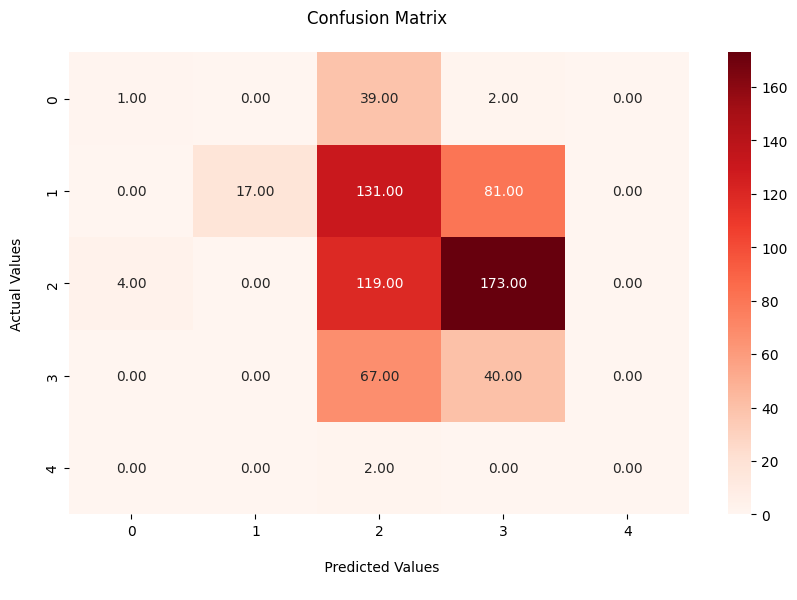

Puntuación F1 test del modelo multi_tag_6m es: 0.3952267524369079
Puntuación F1 train del modelo multi_tag_6m es: 0.6215272733420423
Recall del modelo multi_tag_6m es: 0.4947209653092006
Precision del modelo multi_tag_6m es: 0.3440520255035292 

Parametros del modelo {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


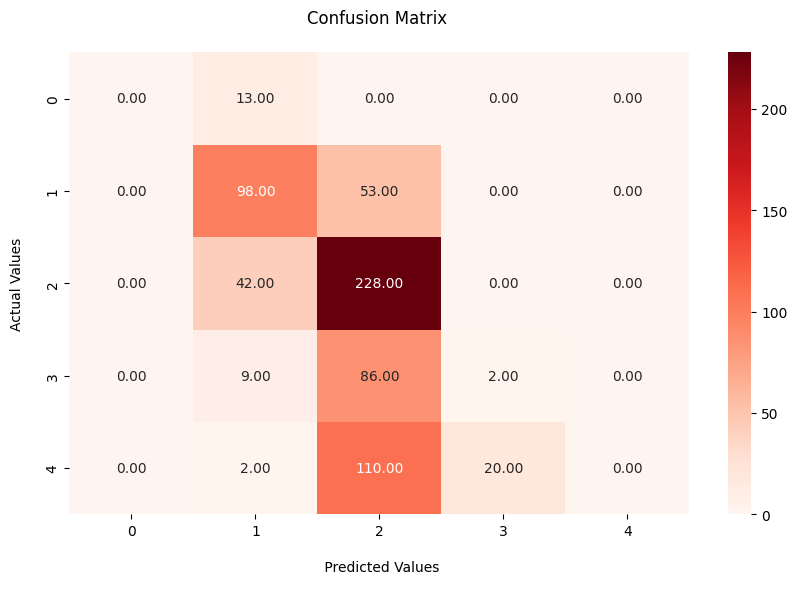

Puntuación F1 test del modelo multi_tag_12m es: 0.030646311072102656
Puntuación F1 train del modelo multi_tag_12m es: 0.6494535186621699
Recall del modelo multi_tag_12m es: 0.08634222919937205
Precision del modelo multi_tag_12m es: 0.021030060604450212 

Parametros del modelo {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


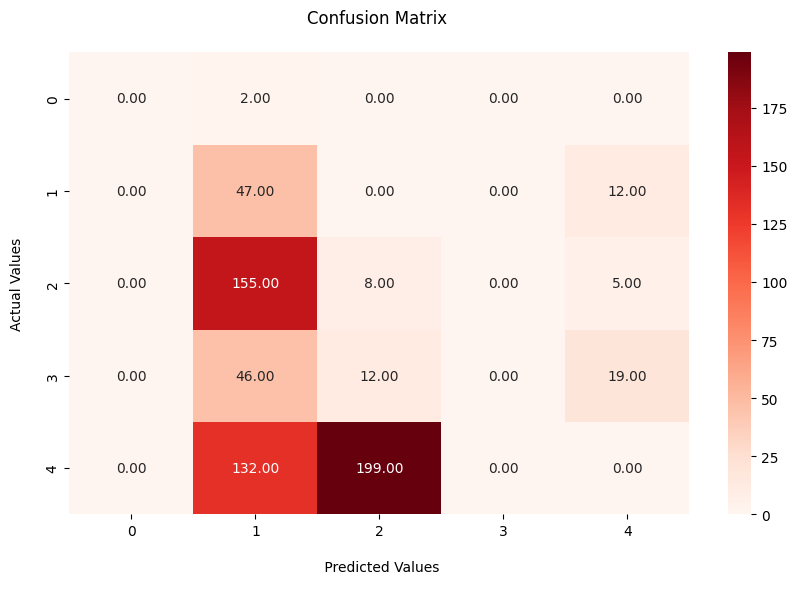

In [ ]:
#Iterate over each period
for n in ['1m', '3m', '6m', '12m']:
    # Select the dataframes
    X_train = globals()[f'X_train_{n}']
    X_test = globals()[f'X_test_{n}']
    y_train = globals()[f'y_train_{n}']
    y_test = globals()[f'y_test_{n}']

    #Iterate over each target (multi_tag_)
    for target in [f'multi_tag_{n}']:
        # Create model
        model = LogisticRegression(random_state=0)
        # Train the model
        model.fit(X_train, y_train)
        # Predict results
        predictions = model.predict(X_test)
        predictions_train = model.predict(X_train)
        # Calculate and print metrics
        f1 = f1_score(y_test, predictions, average='weighted')
        f1_train = f1_score(y_train, predictions_train, average='weighted')
        print(f"Puntuación F1 test del modelo {target} es:", f1)
        print(f"Puntuación F1 train del modelo {target} es:", f1_train)
        recall = recall_score(y_test, predictions, average='weighted')
        precision = precision_score(y_test, predictions, average='weighted')
        print(f"Recall del modelo {target} es:", recall)
        print(f"Precision del modelo {target} es:", precision, "\n")

        #Print the model parameters
        print("Parametros del modelo", model.get_params())

        #Plot confusion matrix
        plt.figure(figsize=(10,6))
        fx=sns.heatmap(confusion_matrix(y_test,predictions), annot=True, fmt=".2f",cmap="Reds")
        fx.set_title('Confusion Matrix \n');
        fx.set_xlabel('\n Predicted Values\n')
        fx.set_ylabel('Actual Values\n');

        plt.show()

###Autogluon

In [ ]:
train_data_1m = TabularDataset(df_1m)
train_data_3m = TabularDataset(df_3m)
train_data_6m = TabularDataset(df_6m)
train_data_12m = TabularDataset(df_12m)
label_1m = 'multi_tag_1m'
label_3m = 'multi_tag_3m'
label_6m = 'multi_tag_6m'
label_12m = 'multi_tag_12m'

In [ ]:
predictor_1m = TabularPredictor(label=label_1m, eval_metric='precision_macro').fit(train_data_1m,holdout_frac=0.2)

No path specified. Models will be saved in: "AutogluonModels/ag-20240520_174146"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240520_174146"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
C

In [ ]:
predictor_1m.leaderboard(TabularDataset(df_test_1m)).sort_values(by="score_val", ascending=False)

model  score_test  score_val      eval_metric  \
6   WeightedEnsemble_L2    0.989363   0.845753  precision_macro   
2              LightGBM    0.990395   0.837395  precision_macro   
3        ExtraTreesEntr    0.989958   0.832344  precision_macro   
7      RandomForestEntr    0.988798   0.830262  precision_macro   
4               XGBoost    0.989828   0.827246  precision_macro   
5      RandomForestGini    0.989390   0.826733  precision_macro   
1        ExtraTreesGini    0.990583   0.824843  precision_macro   
0              CatBoost    0.991609   0.822637  precision_macro   
8         LightGBMLarge    0.988743   0.820409  precision_macro   
9        KNeighborsDist    0.980970   0.794336  precision_macro   
13      NeuralNetFastAI    0.601393   0.785163  precision_macro   
10       KNeighborsUnif    0.655019   0.760233  precision_macro   
11       NeuralNetTorch    0.638639   0.749283  precision_macro   
12           LightGBMXT    0.613204   0.738017  precision_macro   

    pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
6         1.415095       1.627767  229.395806                 0.011969   
2         0.262704       0.453503   18.425987                 0.262704   
3         0.133046       0.122267    1.998883                 0.133046   
7         0.127748       0.135508    4.365560                 0.127748   
4         0.212865       0.127969    9.391147                 0.212865   
5         0.112313       0.133179    5.029994                 0.112313   
1         0.129297       0.134142    1.390197                 0.129297   
0         0.040706       0.019064  164.910961                 0.040706   
8         0.515075       0.393345   13.069841                 0.515075   
9         0.015317       0.020539    0.020465                 0.015317   
13        0.024687       0.120629   10.186651                 0.024687   
10        0.015302       0.020980    0.031290                 0.015302   
11        0.016807       0.020928   19.455705                 0.016807   
12        0.026932       0.070138    8.843369                 0.026932   

    pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
6                 0.004473           1.122607            2       True   
2                 0.453503          18.425987            1       True   
3                 0.122267           1.998883            1       True   
7                 0.135508           4.365560            1       True   
4                 0.127969           9.391147            1       True   
5                 0.133179           5.029994            1       True   
1                 0.134142           1.390197            1       True   
0                 0.019064         164.910961            1       True   
8                 0.393345          13.069841            1       True   
9                 0.020539           0.020465            1       True   
13                0.120629          10.186651            1       True   
10                0.020980           0.031290            1       True   
11                0.020928          19.455705            1       True   
12                0.070138           8.843369            1       True   

    fit_order  
6          14  
2           5  
3          10  
7           7  
4          11  
5           6  
1           9  
0           8  
8          13  
9           2  
13          3  
10          1  
11         12  
12          4

In [ ]:
leaderboard_1m = predictor_1m.leaderboard(extra_info=True)
display(leaderboard_1m.sort_values(by="score_val", ascending=False))

model  score_val      eval_metric  pred_time_val  \
0   WeightedEnsemble_L2   0.845753  precision_macro       1.627767   
1              LightGBM   0.837395  precision_macro       0.453503   
2        ExtraTreesEntr   0.832344  precision_macro       0.122267   
3      RandomForestEntr   0.830262  precision_macro       0.135508   
4               XGBoost   0.827246  precision_macro       0.127969   
5      RandomForestGini   0.826733  precision_macro       0.133179   
6        ExtraTreesGini   0.824843  precision_macro       0.134142   
7              CatBoost   0.822637  precision_macro       0.019064   
8         LightGBMLarge   0.820409  precision_macro       0.393345   
9        KNeighborsDist   0.794336  precision_macro       0.020539   
10      NeuralNetFastAI   0.785163  precision_macro       0.120629   
11       KNeighborsUnif   0.760233  precision_macro       0.020980   
12       NeuralNetTorch   0.749283  precision_macro       0.020928   
13           LightGBMXT   0.738017  precision_macro       0.070138   

      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   229.395806                0.004473           1.122607            2   
1    18.425987                0.453503          18.425987            1   
2     1.998883                0.122267           1.998883            1   
3     4.365560                0.135508           4.365560            1   
4     9.391147                0.127969           9.391147            1   
5     5.029994                0.133179           5.029994            1   
6     1.390197                0.134142           1.390197            1   
7   164.910961                0.019064         164.910961            1   
8    13.069841                0.393345          13.069841            1   
9     0.020465                0.020539           0.020465            1   
10   10.186651                0.120629          10.186651            1   
11    0.031290                0.020980           0.031290            1   
12   19.455705                0.020928          19.455705            1   
13    8.843369                0.070138           8.843369            1   

    can_infer  fit_order  ...  \
0        True         14  ...   
1        True          5  ...   
2        True         10  ...   
3        True          7  ...   
4        True         11  ...   
5        True          6  ...   
6        True          9  ...   
7        True          8  ...   
8        True         13  ...   
9        True          2  ...   
10       True          3  ...   
11       True          1  ...   
12       True         12  ...   
13       True          4  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    hyperparameters  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}   
1                                                                                                                                                                                                                                                                 

Chosen model: CatBoost, with weighted avarage of 0.985
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.99      0.99      0.99       412
           2       0.98      0.98      0.98       232
           3       1.00      0.67      0.80         3

    accuracy                           0.99       684
   macro avg       0.99      0.90      0.94       684
weighted avg       0.99      0.99      0.99       684



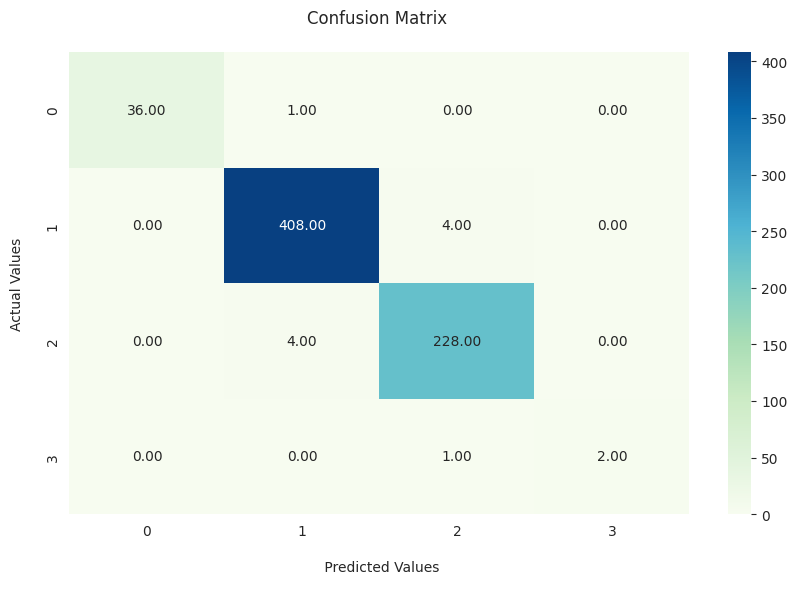

In [ ]:
best=0
name=None
y_test=df_test_1m["multi_tag_1m"]
for x in predictor_1m.model_names():
  y_pred=predictor_1m.predict(df_test_1m,model=x)
  score=classification_report(y_test, y_pred, output_dict=True)['weighted avg']["precision"]
  if score>best:
    best=score
    name=x
print(f"Chosen model: {name}, with weighted avarage of {round(best,3)}")
y_pred=predictor_1m.predict(df_test_1m,model=name)
y_test=df_test_1m["multi_tag_1m"]

print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

plt.show()

In [ ]:
predictor_3m = TabularPredictor(label=label_3m, eval_metric='precision_macro').fit(train_data_3m,holdout_frac=0.2)

No path specified. Models will be saved in: "AutogluonModels/ag-20240520_174623"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240520_174623"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
C

In [ ]:
predictor_3m.leaderboard(TabularDataset(df_test_3m)).sort_values(by="score_val", ascending=False)

model  score_test  score_val      eval_metric  \
6   WeightedEnsemble_L2    0.971941   0.900784  precision_macro   
9       NeuralNetFastAI    0.669016   0.865233  precision_macro   
7               XGBoost    0.948831   0.861768  precision_macro   
1      RandomForestGini    0.980750   0.846249  precision_macro   
0              CatBoost    0.982545   0.844310  precision_macro   
10       NeuralNetTorch    0.629873   0.844121  precision_macro   
4      RandomForestEntr    0.978166   0.843905  precision_macro   
3        ExtraTreesEntr    0.979930   0.842188  precision_macro   
2        ExtraTreesGini    0.980750   0.840336  precision_macro   
5        KNeighborsDist    0.975689   0.818535  precision_macro   
8        KNeighborsUnif    0.705361   0.805311  precision_macro   
13           LightGBMXT    0.272703   0.608195  precision_macro   
11        LightGBMLarge    0.295583   0.247275  precision_macro   
12             LightGBM    0.274008   0.213354  precision_macro   

    pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
6         0.184689       0.178437  103.819259                 0.005119   
9         0.023491       0.046871   10.294532                 0.023491   
7         0.058535       0.014094    5.995454                 0.058535   
1         0.122149       0.101835    2.969818                 0.122149   
0         0.029809       0.015551   79.425758                 0.029809   
10        0.018953       0.014924   15.020913                 0.018953   
4         0.128952       0.137734    2.429540                 0.128952   
3         0.140186       0.121189    1.484785                 0.140186   
2         0.136649       0.101621    1.144058                 0.136649   
5         0.016593       0.046274    0.043183                 0.016593   
8         0.019794       0.039785    0.035659                 0.019794   
13        0.003030       0.007447    3.623880                 0.003030   
11        0.002497       0.004062    6.373349                 0.002497   
12        0.001624       0.005801    4.059041                 0.001624   

    pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
6                 0.004316           0.696762            2       True   
9                 0.046871          10.294532            1       True   
7                 0.014094           5.995454            1       True   
1                 0.101835           2.969818            1       True   
0                 0.015551          79.425758            1       True   
10                0.014924          15.020913            1       True   
4                 0.137734           2.429540            1       True   
3                 0.121189           1.484785            1       True   
2                 0.101621           1.144058            1       True   
5                 0.046274           0.043183            1       True   
8                 0.039785           0.035659            1       True   
13                0.007447           3.623880            1       True   
11                0.004062           6.373349            1       True   
12                0.005801           4.059041            1       True   

    fit_order  
6          14  
9           3  
7          11  
1           6  
0           8  
10         12  
4           7  
3          10  
2           9  
5           2  
8           1  
13          4  
11         13  
12          5

In [ ]:
predictor_3m.model_names()

['KNeighborsUnif',
 'KNeighborsDist',
 'NeuralNetFastAI',
 'LightGBMXT',
 'LightGBM',
 'RandomForestGini',
 'RandomForestEntr',
 'CatBoost',
 'ExtraTreesGini',
 'ExtraTreesEntr',
 'XGBoost',
 'NeuralNetTorch',
 'LightGBMLarge',
 'WeightedEnsemble_L2']

In [ ]:
leaderboard_3m = predictor_3m.leaderboard(extra_info=True)
display(leaderboard_3m.sort_values(by="score_val", ascending=False))

model  score_val      eval_metric  pred_time_val  \
0   WeightedEnsemble_L2   0.900784  precision_macro       0.178437   
1       NeuralNetFastAI   0.865233  precision_macro       0.046871   
2               XGBoost   0.861768  precision_macro       0.014094   
3      RandomForestGini   0.846249  precision_macro       0.101835   
4              CatBoost   0.844310  precision_macro       0.015551   
5        NeuralNetTorch   0.844121  precision_macro       0.014924   
6      RandomForestEntr   0.843905  precision_macro       0.137734   
7        ExtraTreesEntr   0.842188  precision_macro       0.121189   
8        ExtraTreesGini   0.840336  precision_macro       0.101621   
9        KNeighborsDist   0.818535  precision_macro       0.046274   
10       KNeighborsUnif   0.805311  precision_macro       0.039785   
11           LightGBMXT   0.608195  precision_macro       0.007447   
12        LightGBMLarge   0.247275  precision_macro       0.004062   
13             LightGBM   0.213354  precision_macro       0.005801   

      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   103.819259                0.004316           0.696762            2   
1    10.294532                0.046871          10.294532            1   
2     5.995454                0.014094           5.995454            1   
3     2.969818                0.101835           2.969818            1   
4    79.425758                0.015551          79.425758            1   
5    15.020913                0.014924          15.020913            1   
6     2.429540                0.137734           2.429540            1   
7     1.484785                0.121189           1.484785            1   
8     1.144058                0.101621           1.144058            1   
9     0.043183                0.046274           0.043183            1   
10    0.035659                0.039785           0.035659            1   
11    3.623880                0.007447           3.623880            1   
12    6.373349                0.004062           6.373349            1   
13    4.059041                0.005801           4.059041            1   

    can_infer  fit_order  ...  \
0        True         14  ...   
1        True          3  ...   
2        True         11  ...   
3        True          6  ...   
4        True          8  ...   
5        True         12  ...   
6        True          7  ...   
7        True         10  ...   
8        True          9  ...   
9        True          2  ...   
10       True          1  ...   
11       True          4  ...   
12       True         13  ...   
13       True          5  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    hyperparameters  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}   
1                                                                                                                                                                                                                                                                 

Chosen model: CatBoost, with weighted avarage of 0.974
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.96      0.99      0.97       229
           2       0.98      0.97      0.98       296
           3       0.97      0.98      0.98       107
           4       1.00      1.00      1.00         2

    accuracy                           0.97       676
   macro avg       0.98      0.97      0.97       676
weighted avg       0.97      0.97      0.97       676



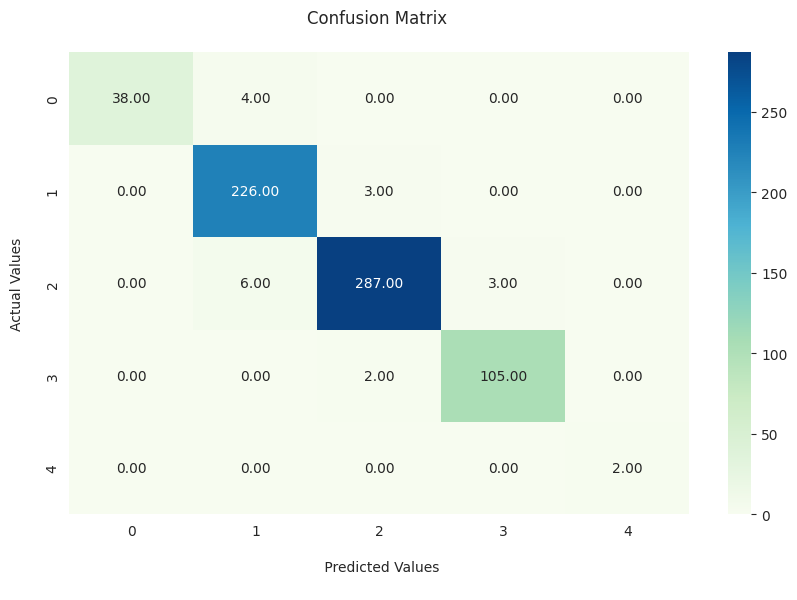

In [ ]:
best=0
name=None
y_test=df_test_3m["multi_tag_3m"]
for x in predictor_3m.model_names():
  y_pred=predictor_3m.predict(df_test_3m,model=x)
  score=classification_report(y_test, y_pred, output_dict=True)['weighted avg']["precision"]
  if score>best:
    best=score
    name=x
print(f"Chosen model: {name}, with weighted avarage of {round(best,3)}")
y_pred=predictor_3m.predict(df_test_3m,model=name)
y_test=df_test_3m["multi_tag_3m"]

print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

plt.show()

In [ ]:
predictor_6m = TabularPredictor(label=label_6m, eval_metric='precision_macro').fit(train_data_6m,holdout_frac=0.2)

No path specified. Models will be saved in: "AutogluonModels/ag-20240521_151507"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240521_151507"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
C

In [ ]:
predictor_6m.leaderboard(TabularDataset(df_test_6m)).sort_values(by="score_val", ascending=False)

model  score_test  score_val      eval_metric  \
6   WeightedEnsemble_L2    0.967748   0.880973  precision_macro   
7               XGBoost    0.965000   0.870012  precision_macro   
3      RandomForestGini    0.968165   0.867460  precision_macro   
2        KNeighborsDist    0.968568   0.865533  precision_macro   
9              CatBoost    0.956044   0.864159  precision_macro   
0        ExtraTreesGini    0.969938   0.863708  precision_macro   
1         LightGBMLarge    0.969063   0.862409  precision_macro   
5              LightGBM    0.967804   0.861992  precision_macro   
4        ExtraTreesEntr    0.968131   0.861602  precision_macro   
8      RandomForestEntr    0.963709   0.861374  precision_macro   
10       KNeighborsUnif    0.893893   0.855911  precision_macro   
12       NeuralNetTorch    0.818196   0.839265  precision_macro   
11      NeuralNetFastAI    0.840464   0.835932  precision_macro   
13           LightGBMXT    0.241474   0.376276  precision_macro   

    pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
6         0.721751       0.347986  114.765119                 0.011032   
7         0.260485       0.078005    6.771492                 0.260485   
3         0.161685       0.101566    2.338645                 0.161685   
2         0.021409       0.026295    0.016263                 0.021409   
9         0.073924       0.030107   97.950288                 0.073924   
0         0.188195       0.100637    2.092380                 0.188195   
1         0.520768       0.348325   11.050450                 0.520768   
5         0.316133       0.223708    8.577697                 0.316133   
4         0.278059       0.107940    1.219691                 0.278059   
8         0.189914       0.102289    2.607609                 0.189914   
10        0.023505       0.101646    4.454521                 0.023505   
12        0.029180       0.018499   20.969489                 0.029180   
11        0.045310       0.021571    5.996040                 0.045310   
13        0.003302       0.004560    3.814055                 0.003302   

    pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
6                 0.005162           1.266767            2       True   
7                 0.078005           6.771492            1       True   
3                 0.101566           2.338645            1       True   
2                 0.026295           0.016263            1       True   
9                 0.030107          97.950288            1       True   
0                 0.100637           2.092380            1       True   
1                 0.348325          11.050450            1       True   
5                 0.223708           8.577697            1       True   
4                 0.107940           1.219691            1       True   
8                 0.102289           2.607609            1       True   
10                0.101646           4.454521            1       True   
12                0.018499          20.969489            1       True   
11                0.021571           5.996040            1       True   
13                0.004560           3.814055            1       True   

    fit_order  
6          14  
7          11  
3           6  
2           2  
9           8  
0           9  
1          13  
5           5  
4          10  
8           7  
10          1  
12         12  
11          3  
13          4

In [ ]:
leaderboard_6m = predictor_6m.leaderboard(extra_info=True)
display(leaderboard_6m.sort_values(by="score_val", ascending=False))

model  score_val      eval_metric  pred_time_val   fit_time  \
0   WeightedEnsemble_L2   0.880224  precision_macro       0.996255  50.626809   
1               XGBoost   0.865625  precision_macro       0.240715  10.907825   
2        KNeighborsDist   0.865533  precision_macro       0.022737   0.020327   
3        ExtraTreesGini   0.864988  precision_macro       0.172549   2.071320   
4      RandomForestEntr   0.863567  precision_macro       0.110569   2.299586   
5              CatBoost   0.861966  precision_macro       0.031251  92.657197   
6      RandomForestGini   0.861611  precision_macro       0.102306   1.851755   
7        ExtraTreesEntr   0.860717  precision_macro       0.157569   2.516883   
8              LightGBM   0.857945  precision_macro       0.305681   9.994721   
9        KNeighborsUnif   0.855911  precision_macro       0.044145   0.018334   
10        LightGBMLarge   0.854925  precision_macro       0.037244   9.474343   
11      NeuralNetFastAI   0.841398  precision_macro       0.020931   4.718134   
12       NeuralNetTorch   0.822161  precision_macro       0.015049  12.837863   
13           LightGBMXT   0.801598  precision_macro       0.020108   2.668692   

    pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                 0.004386           0.723505            2       True   
1                 0.240715          10.907825            1       True   
2                 0.022737           0.020327            1       True   
3                 0.172549           2.071320            1       True   
4                 0.110569           2.299586            1       True   
5                 0.031251          92.657197            1       True   
6                 0.102306           1.851755            1       True   
7                 0.157569           2.516883            1       True   
8                 0.305681           9.994721            1       True   
9                 0.044145           0.018334            1       True   
10                0.037244           9.474343            1       True   
11                0.020931           4.718134            1       True   
12                0.015049          12.837863            1       True   
13                0.020108           2.668692            1       True   

    fit_order  ...  \
0          14  ...   
1          11  ...   
2           2  ...   
3           9  ...   
4           7  ...   
5           8  ...   
6           6  ...   
7          10  ...   
8           5  ...   
9           1  ...   
10         13  ...   
11          3  ...   
12         12  ...   
13          4  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    hyperparameters  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}   
1                                                                                                                                                                                                                                                                                

In [ ]:
predictor_6m.set_model_best("CatBoost")

In [ ]:
predictor_6m.model_best

'CatBoost'

Chosen model: ExtraTreesGini, with weighted avarage of 0.97
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.98      0.97      0.98       151
           2       0.98      0.99      0.98       270
           3       0.91      0.96      0.93        97
           4       0.98      0.94      0.96       132

    accuracy                           0.97       663
   macro avg       0.97      0.97      0.97       663
weighted avg       0.97      0.97      0.97       663



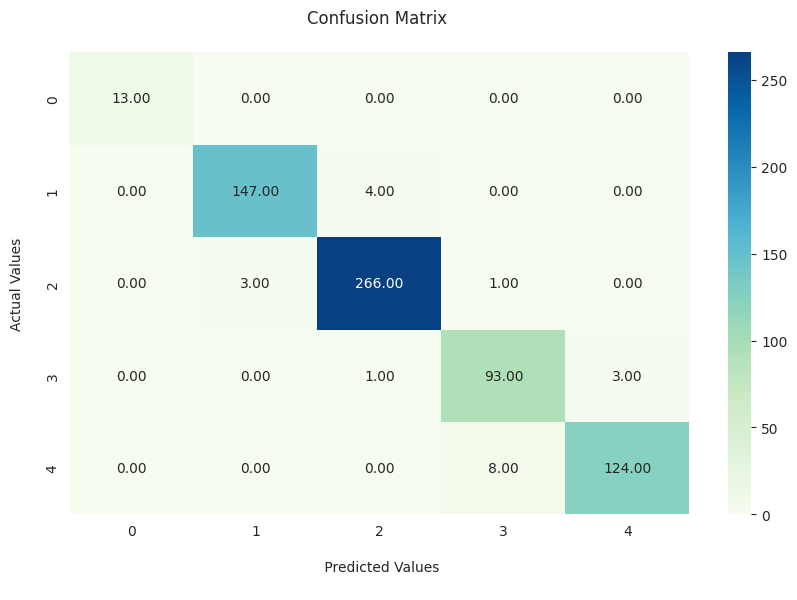

In [ ]:
best=0
name=None
y_test=df_test_6m["multi_tag_6m"]
for x in predictor_6m.model_names():
  y_pred=predictor_6m.predict(df_test_6m,model=x)
  score=classification_report(y_test, y_pred, output_dict=True)['weighted avg']["precision"]
  if score>best:
    best=score
    name=x
print(f"Chosen model: {name}, with weighted avarage of {round(best,3)}")
y_pred=predictor_6m.predict(df_test_6m,model=name)
y_test=df_test_6m["multi_tag_6m"]


print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="Reds")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

plt.show()

In [ ]:
predictor_12m = TabularPredictor(label=label_12m, eval_metric='precision_macro').fit(train_data_12m,holdout_frac=0.2)


No path specified. Models will be saved in: "AutogluonModels/ag-20240520_175136"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240520_175136"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
C

In [ ]:
predictor_12m.leaderboard(TabularDataset(df_test_12m)).sort_values(by="score_test", ascending=False)

model  score_test  score_val      eval_metric  \
0               XGBoost    0.992655   0.916291  precision_macro   
1              CatBoost    0.992023   0.926361  precision_macro   
2      RandomForestGini    0.992023   0.912006  precision_macro   
3      RandomForestEntr    0.992023   0.928180  precision_macro   
4   WeightedEnsemble_L2    0.992023   0.931976  precision_macro   
5        KNeighborsDist    0.991393   0.900832  precision_macro   
6        ExtraTreesEntr    0.988493   0.912286  precision_macro   
7        ExtraTreesGini    0.988493   0.907155  precision_macro   
8              LightGBM    0.987864   0.908812  precision_macro   
9            LightGBMXT    0.987864   0.918668  precision_macro   
10        LightGBMLarge    0.984455   0.915800  precision_macro   
11       NeuralNetTorch    0.835243   0.885661  precision_macro   
12       KNeighborsUnif    0.736236   0.895684  precision_macro   
13      NeuralNetFastAI    0.715182   0.891993  precision_macro   

    pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
0         0.097849       0.065596    7.646481                 0.097849   
1         0.035970       0.019724  120.021147                 0.035970   
2         0.101164       0.100846    1.658804                 0.101164   
3         0.105528       0.100453    2.105487                 0.105528   
4         0.667584       0.611310  139.277183                 0.006081   
5         0.015067       0.037196    0.022568                 0.015067   
6         0.109996       0.103965    1.087189                 0.109996   
7         0.117541       0.089261    1.065151                 0.117541   
8         0.054034       0.048486    5.909881                 0.054034   
9         0.343129       0.313468    6.383510                 0.343129   
10        0.161024       0.135216    9.705508                 0.161024   
11        0.018470       0.025894   18.158883                 0.018470   
12        0.015851       0.039424    0.025743                 0.015851   
13        0.024169       0.020444    4.145116                 0.024169   

    pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                 0.065596           7.646481            1       True   
1                 0.019724         120.021147            1       True   
2                 0.100846           1.658804            1       True   
3                 0.100453           2.105487            1       True   
4                 0.003025           1.035789            2       True   
5                 0.037196           0.022568            1       True   
6                 0.103965           1.087189            1       True   
7                 0.089261           1.065151            1       True   
8                 0.048486           5.909881            1       True   
9                 0.313468           6.383510            1       True   
10                0.135216           9.705508            1       True   
11                0.025894          18.158883            1       True   
12                0.039424           0.025743            1       True   
13                0.020444           4.145116            1       True   

    fit_order  
0          11  
1           8  
2           6  
3           7  
4          14  
5           2  
6          10  
7           9  
8           5  
9           4  
10         13  
11         12  
12          1  
13          3

In [ ]:
leaderboard_12m = predictor_12m.leaderboard(extra_info=True)
display(leaderboard_12m.sort_values(by="score_val", ascending=False))

model  score_val      eval_metric  pred_time_val  \
0   WeightedEnsemble_L2   0.931976  precision_macro       0.611310   
1      RandomForestEntr   0.928180  precision_macro       0.100453   
2              CatBoost   0.926361  precision_macro       0.019724   
3            LightGBMXT   0.918668  precision_macro       0.313468   
4               XGBoost   0.916291  precision_macro       0.065596   
5         LightGBMLarge   0.915800  precision_macro       0.135216   
6        ExtraTreesEntr   0.912286  precision_macro       0.103965   
7      RandomForestGini   0.912006  precision_macro       0.100846   
8              LightGBM   0.908812  precision_macro       0.048486   
9        ExtraTreesGini   0.907155  precision_macro       0.089261   
10       KNeighborsDist   0.900832  precision_macro       0.037196   
11       KNeighborsUnif   0.895684  precision_macro       0.039424   
12      NeuralNetFastAI   0.891993  precision_macro       0.020444   
13       NeuralNetTorch   0.885661  precision_macro       0.025894   

      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   139.277183                0.003025           1.035789            2   
1     2.105487                0.100453           2.105487            1   
2   120.021147                0.019724         120.021147            1   
3     6.383510                0.313468           6.383510            1   
4     7.646481                0.065596           7.646481            1   
5     9.705508                0.135216           9.705508            1   
6     1.087189                0.103965           1.087189            1   
7     1.658804                0.100846           1.658804            1   
8     5.909881                0.048486           5.909881            1   
9     1.065151                0.089261           1.065151            1   
10    0.022568                0.037196           0.022568            1   
11    0.025743                0.039424           0.025743            1   
12    4.145116                0.020444           4.145116            1   
13   18.158883                0.025894          18.158883            1   

    can_infer  fit_order  ...  \
0        True         14  ...   
1        True          7  ...   
2        True          8  ...   
3        True          4  ...   
4        True         11  ...   
5        True         13  ...   
6        True         10  ...   
7        True          6  ...   
8        True          5  ...   
9        True          9  ...   
10       True          2  ...   
11       True          1  ...   
12       True          3  ...   
13       True         12  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    hyperparameters  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}   
1                                                                                                                                                                                                                                                                 

Chosen model: XGBoost, with weighted avarage of 0.991
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.95      0.97        59
           2       0.98      1.00      0.99       168
           3       0.99      0.97      0.98        77
           4       0.99      1.00      1.00       331

    accuracy                           0.99       637
   macro avg       0.99      0.98      0.99       637
weighted avg       0.99      0.99      0.99       637



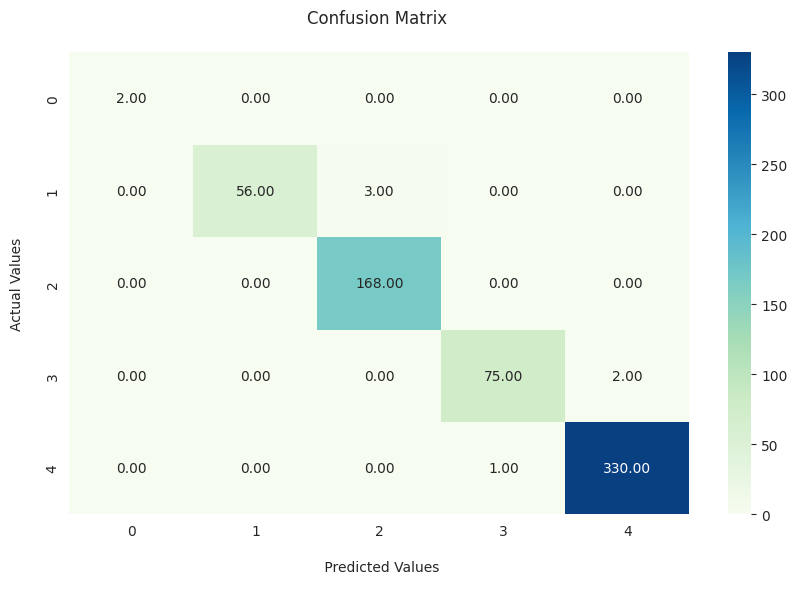

In [ ]:
best=0
name=None
y_test=df_test_12m["multi_tag_12m"]
for x in predictor_12m.model_names():
  y_pred=predictor_12m.predict(df_test_12m,model=x)
  score=classification_report(y_test, y_pred, output_dict=True)['weighted avg']["precision"]
  if score>best:
    best=score
    name=x
print(f"Chosen model: {name}, with weighted avarage of {round(best,3)}")
y_pred=predictor_12m.predict(df_test_12m,model=name)
y_test=df_test_12m["multi_tag_12m"]

print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

plt.show()

### XG Boost

Accuracy for 1m: 61.70%
Puntuación F1 test del modelo en el periodo 1m: 0.5665538369025573
Puntuación F1 train del modelo en el periodo 1m: 1
Recall del modelo en el periodo 1m: 0.6169590643274854
Precision del modelo en el periodo 1m: 0.5798729021301297
Precision Train del modelo en el periodo 1m: 0.9573859000089415



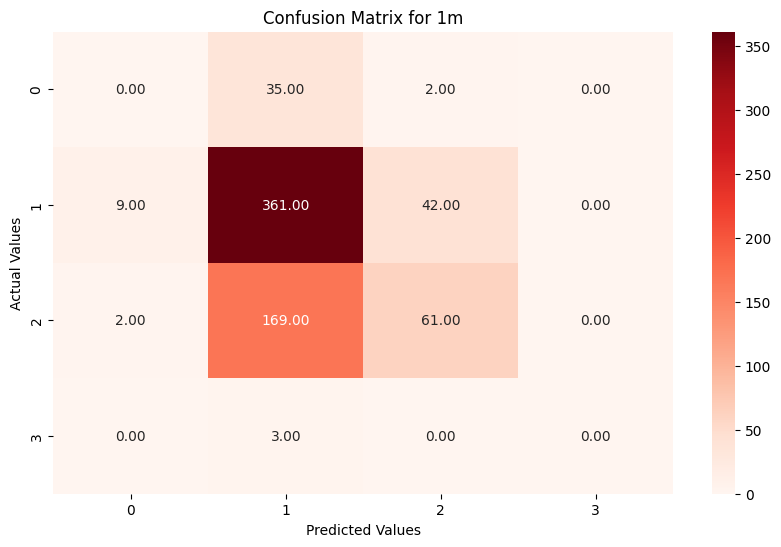

Accuracy for 3m: 34.76%
Puntuación F1 test del modelo en el periodo 3m: 0.3494888572036046
Puntuación F1 train del modelo en el periodo 3m: 1
Recall del modelo en el periodo 3m: 0.34763313609467456
Precision del modelo en el periodo 3m: 0.4364360232932269
Precision Train del modelo en el periodo 3m: 0.9859685362744672



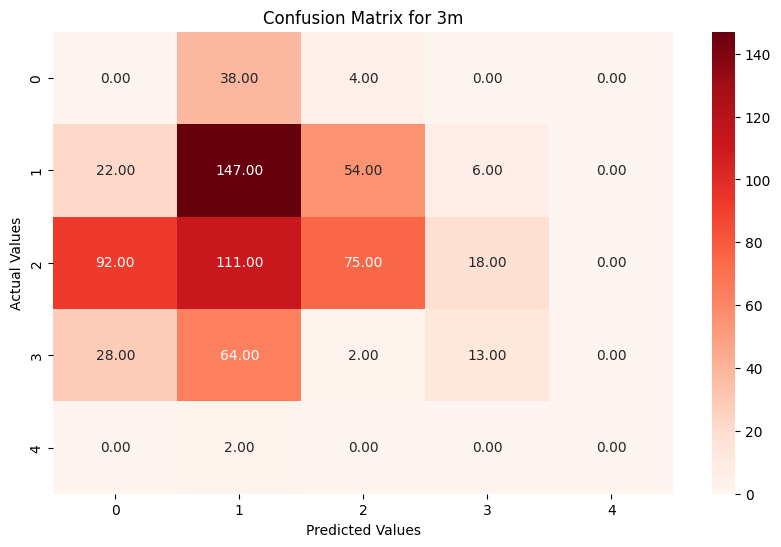

Accuracy for 6m: 31.37%
Puntuación F1 test del modelo en el periodo 6m: 0.29712690337000874
Puntuación F1 train del modelo en el periodo 6m: 1
Recall del modelo en el periodo 6m: 0.3137254901960784
Precision del modelo en el periodo 6m: 0.3743214349580479
Precision Train del modelo en el periodo 6m: 0.9407004909031561



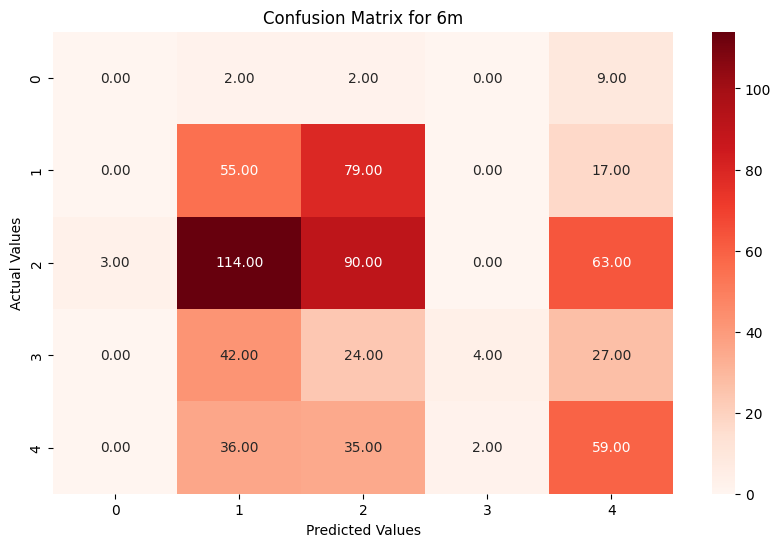

Accuracy for 12m: 0.31%
Puntuación F1 test del modelo en el periodo 12m: 1.965394319519068e-05
Puntuación F1 train del modelo en el periodo 12m: 0
Recall del modelo en el periodo 12m: 0.0031397174254317113
Precision del modelo en el periodo 12m: 9.857825511559534e-06
Precision Train del modelo en el periodo 12m: 0.13944822692931452



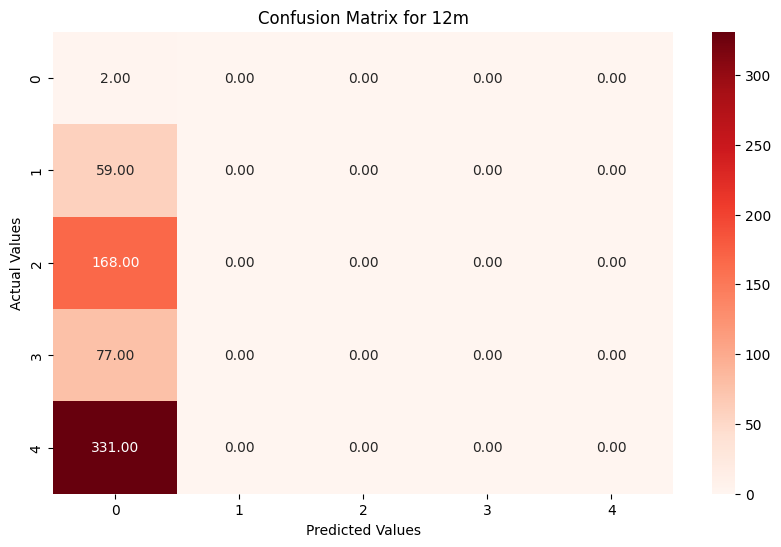

In [ ]:
# Prepare the train and test data for the current period
x_trains=[X_train_1m, X_train_3m, X_train_6m, X_train_12m]
x_tests=[X_test_1m, X_test_3m, X_test_6m, X_test_12m]
y_trains=[y_train_1m, y_train_3m, y_train_6m, y_train_12m]
y_tests=[y_test_1m, y_test_3m, y_test_6m, y_test_12m]

for idx, n in enumerate(['1m', '3m', '6m', '12m']):
    X_train = x_trains[idx]
    y_train = y_trains[idx]
    X_test = x_tests[idx]
    y_test = y_tests[idx]

    # Create DMatrix for XGBoost
    dtrain= xgb.DMatrix(X_train, label=y_train)
    dtest= xgb.DMatrix(X_test, label=y_test)

    # Set parameters for XGBoost
    params = {
      'objective': 'multi:softprob',
      'num_class': len(np.unique(y_train)),
      'min_split_gain': 0.2,
      'max_depth': 10,
      'random_seed': 40
    }

    # Train the model with early stopping
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=False)

    # Get the best iteration
    best_iteration = bst.best_iteration

    # Retrain the model with the best number of boosting rounds
    bst = xgb.train(params, dtrain, num_boost_round=best_iteration)

    # Make predictions on the test set
    y_pred = bst.predict(dtest)
    y_pred_train = bst.predict(dtrain)

    # Get the class with the highest probability
    predictions_XGBoost = np.argmax(y_pred, axis=1)
    predictions_train_XGBoost = np.argmax(y_pred_train, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions_XGBoost)
    print(f'Accuracy for {n}: {accuracy * 100.0:.2f}%')

      # Calculate F1 score
    f1 = f1_score(y_test, predictions_XGBoost, average='weighted')
    f1_train = f1_score(y_train, predictions_train_XGBoost, average='weighted')
    print(f"Puntuación F1 test del modelo en el periodo {n}: {f1}")
    print(f"Puntuación F1 train del modelo en el periodo {n}: {round(f1_train)}")

    # Calculate recall and precision
    recall = recall_score(y_test, predictions_XGBoost, average='weighted')
    precision = precision_score(y_test, predictions_XGBoost, average='weighted')
    precision_train = precision_score(y_train, predictions_train_XGBoost, average='weighted')
    print(f"Recall del modelo en el periodo {n}: {recall}")
    print(f"Precision del modelo en el periodo {n}: {precision}")
    print(f"Precision Train del modelo en el periodo {n}: {precision_train}\n")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions_XGBoost)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Reds")
    plt.title(f'Confusion Matrix for {n}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

### CatBoost

In [ ]:
params_1m = {'iterations': 4868, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass'}
params_3m = {'iterations': 2998, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass'}
params_6m = {'iterations': 2611, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass'}
params_12m ={'iterations': 4174, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass'}

Classification report for target_1m:
               precision    recall  f1-score   support

           0       0.09      0.54      0.15        37
           1       0.71      0.43      0.53       412
           2       0.43      0.39      0.41       232
           3       0.00      0.00      0.00         3

    accuracy                           0.42       684
   macro avg       0.31      0.34      0.27       684
weighted avg       0.58      0.42      0.47       684

Puntuación F1 test del modelo en el periodo target_1m: 0.468
Puntuación F1 train del modelo en el periodo target_1m: 1.0


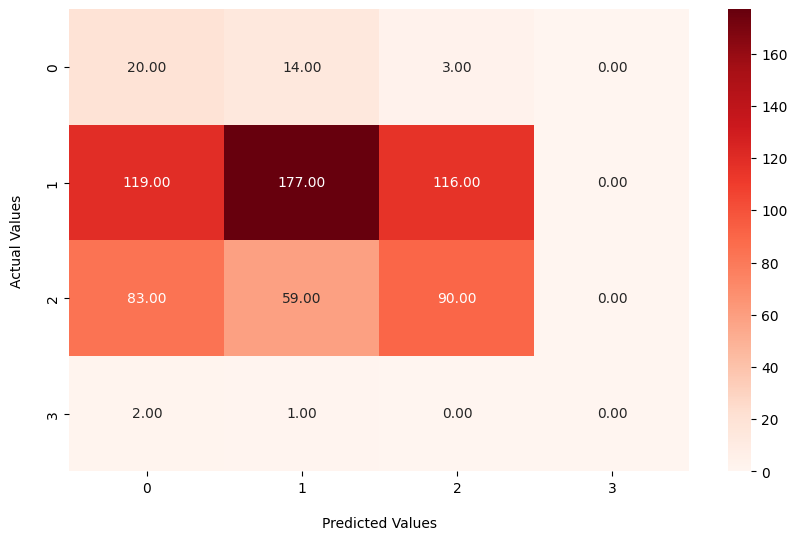

Classification report for target_3m:
               precision    recall  f1-score   support

           0       0.12      0.45      0.20        42
           1       0.48      0.52      0.50       229
           2       0.57      0.54      0.56       296
           3       0.00      0.00      0.00       107
           4       0.00      0.00      0.00         2

    accuracy                           0.44       676
   macro avg       0.24      0.30      0.25       676
weighted avg       0.42      0.44      0.43       676

Puntuación F1 test del modelo en el periodo target_3m: 0.426
Puntuación F1 train del modelo en el periodo target_3m: 0.999


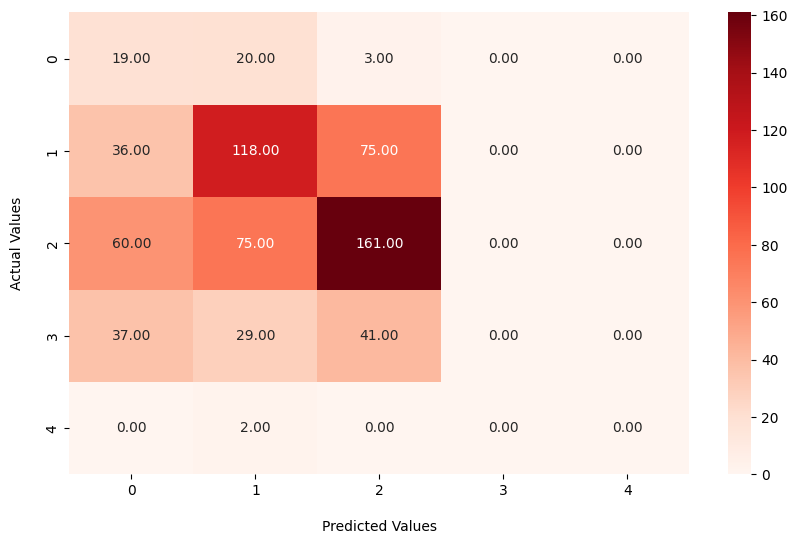

Classification report for target_6m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.11      0.23      0.15       151
           2       0.48      0.62      0.54       270
           3       0.00      0.00      0.00        97
           4       0.00      0.00      0.00       132

    accuracy                           0.31       663
   macro avg       0.12      0.17      0.14       663
weighted avg       0.22      0.31      0.25       663

Puntuación F1 test del modelo en el periodo target_6m: 0.254
Puntuación F1 train del modelo en el periodo target_6m: 0.996


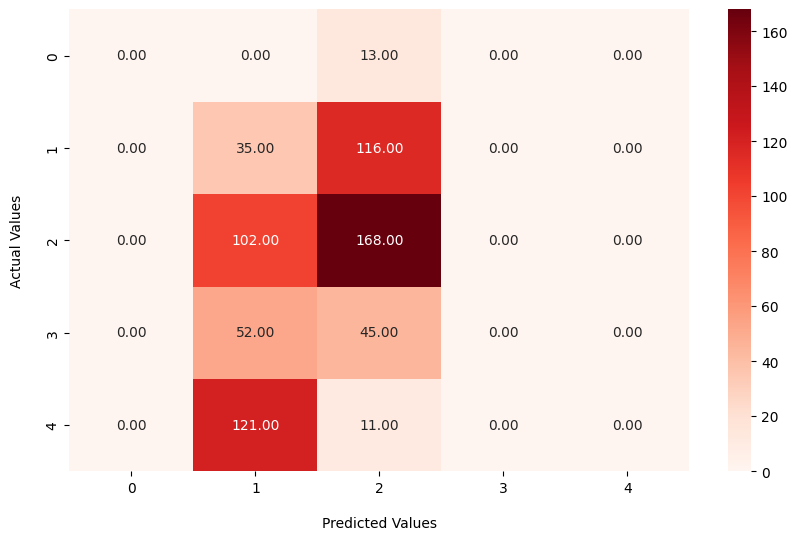

Classification report for target_12m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.17      0.07      0.10        59
           2       0.21      0.53      0.30       168
           3       0.09      0.09      0.09        77
           4       0.09      0.03      0.04       331

    accuracy                           0.17       637
   macro avg       0.11      0.14      0.10       637
weighted avg       0.13      0.17      0.12       637

Puntuación F1 test del modelo en el periodo target_12m: 0.119
Puntuación F1 train del modelo en el periodo target_12m: 1.0


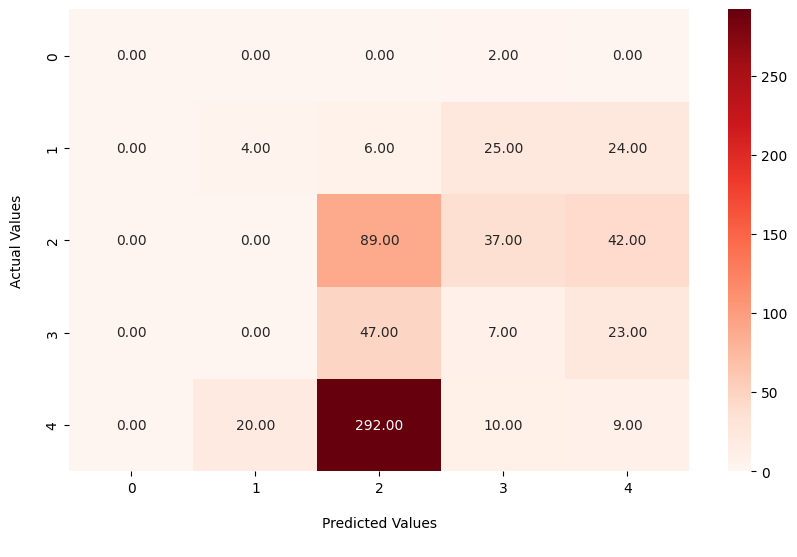

In [ ]:
x_trains=[X_train_1m,X_train_3m,X_train_6m,X_train_12m]
x_tests=[X_test_1m,X_test_3m,X_test_6m,X_test_12m]
y_trains=[y_train_1m,y_train_3m,y_train_6m,y_train_12m]
y_tests=[y_test_1m,y_test_3m,y_test_6m,y_test_12m]
params_list=[params_1m,params_3m,params_6m,params_12m]
targets=["target_1m","target_3m","target_6m","target_12m"]

for x in range(4):
  # read the dataset
  train_data = x_trains[x]
  train_labels = y_trains[x]
  test_data = x_tests[x]
  y_test= y_tests[x]

  train_pool = Pool(train_data,
                    train_labels)

  test_pool = Pool(test_data)
  # specify training parameters via map

  param = params_list[x]
  model = CatBoost(param)
  #train the model
  model.fit(train_pool,logging_level="Silent")

  preds_class = model.predict(test_pool, prediction_type='Class')

  print(f"Classification report for {targets[x]}:\n", classification_report(y_test, preds_class))

  train_pool = Pool(train_data)
  y_train=train_labels
  predictions_train=model.predict(train_pool, prediction_type='Class')
  # Calculate F1 score
  f1 = f1_score(y_test, preds_class, average='weighted')
  f1_train = f1_score(y_train, predictions_train, average='weighted')
  print(f"Puntuación F1 test del modelo en el periodo {targets[x]}: {round(f1,3)}")
  print(f"Puntuación F1 train del modelo en el periodo {targets[x]}: {round(f1_train,3)}")

  #Plot confusion matrix
  plt.figure(figsize=(10, 6))
  fx = sns.heatmap(confusion_matrix(y_test, preds_class), annot=True, fmt=".2f", cmap="Reds")
  #fx.set_title(f'Confusion Matrix for {target}')
  fx.set_xlabel('\nPredicted Values\n')
  fx.set_ylabel('Actual Values\n')
  plt.show()

In [ ]:
params_1m = {'iterations': 400, 'learning_rate': 0.01, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass',"od_type" :"Iter","od_wait":10,"od_pval":0.0001,"leaf_estimation_iterations":50,"depth":4,"bagging_temperature": 0.2}
params_3m = {'iterations': 400, 'learning_rate': 0.01, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass',"od_type" :"Iter","od_wait":10,"od_pval":0.0001,"leaf_estimation_iterations":50,"depth":4,"bagging_temperature": 0.2}
params_6m = {'iterations': 400, 'learning_rate': 0.01, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass',"od_type" :"Iter","od_wait":10,"od_pval":0.0001,"leaf_estimation_iterations":50,"depth":4,"bagging_temperature": 0.2}
params_12m ={'iterations': 400, 'learning_rate': 0.01, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'MultiClass','loss_function': 'MultiClass',"od_type" :"Iter","od_wait":10,"od_pval":0.0001,"leaf_estimation_iterations":50,"depth":4,"bagging_temperature": 0.2}

Classification report for target_1m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.60      1.00      0.75       412
           2       1.00      0.00      0.01       232
           3       0.00      0.00      0.00         3

    accuracy                           0.60       684
   macro avg       0.40      0.25      0.19       684
weighted avg       0.70      0.60      0.46       684

Puntuación F1 test del modelo en el periodo target_1m: 0.456
Puntuación F1 train del modelo en el periodo target_1m: 0.723


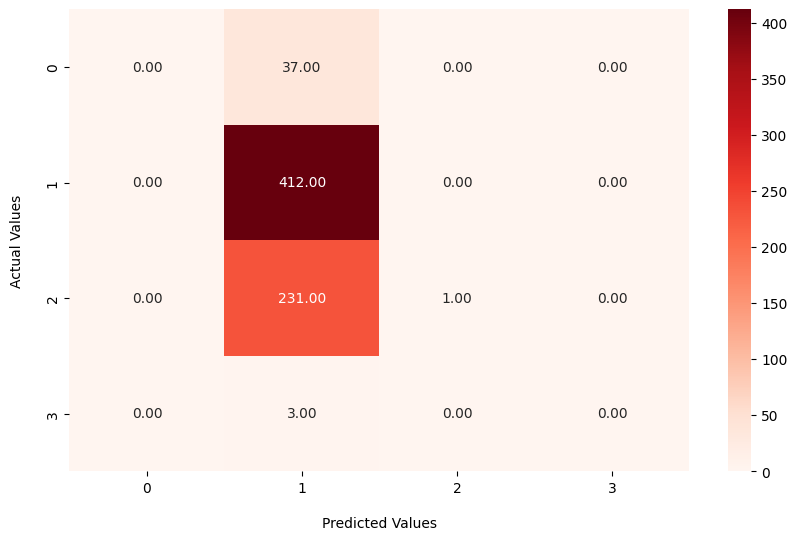

Classification report for target_3m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.41      0.65      0.51       229
           2       0.61      0.66      0.63       296
           3       0.00      0.00      0.00       107
           4       0.00      0.00      0.00         2

    accuracy                           0.51       676
   macro avg       0.20      0.26      0.23       676
weighted avg       0.41      0.51      0.45       676

Puntuación F1 test del modelo en el periodo target_3m: 0.447
Puntuación F1 train del modelo en el periodo target_3m: 0.815


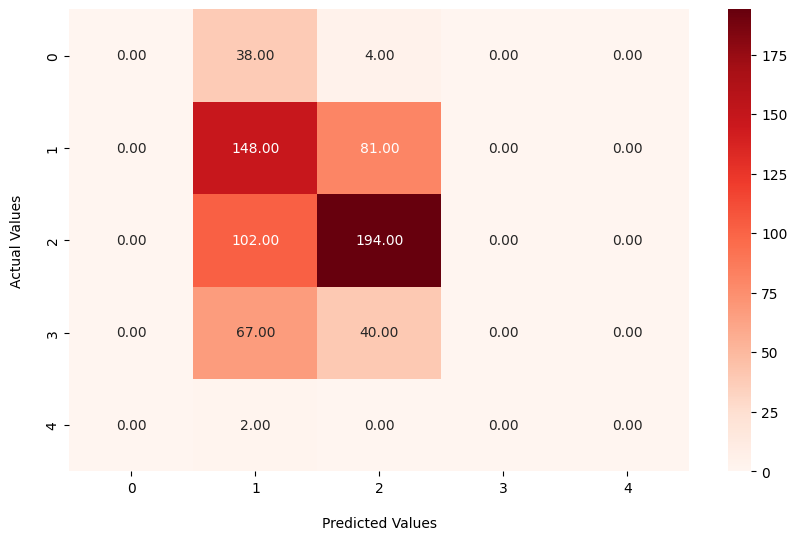

Classification report for target_6m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.17      0.40      0.24       151
           2       0.45      0.51      0.47       270
           3       0.00      0.00      0.00        97
           4       0.00      0.00      0.00       132

    accuracy                           0.30       663
   macro avg       0.12      0.18      0.14       663
weighted avg       0.22      0.30      0.25       663

Puntuación F1 test del modelo en el periodo target_6m: 0.247
Puntuación F1 train del modelo en el periodo target_6m: 0.845


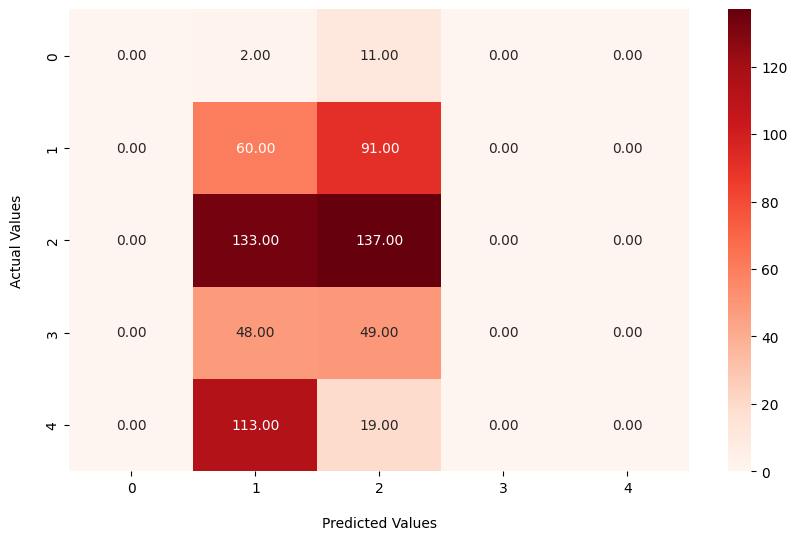

Classification report for target_12m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        59
           2       0.14      0.30      0.19       168
           3       0.00      0.00      0.00        77
           4       0.05      0.04      0.04       331

    accuracy                           0.10       637
   macro avg       0.04      0.07      0.05       637
weighted avg       0.06      0.10      0.07       637

Puntuación F1 test del modelo en el periodo target_12m: 0.073
Puntuación F1 train del modelo en el periodo target_12m: 0.887


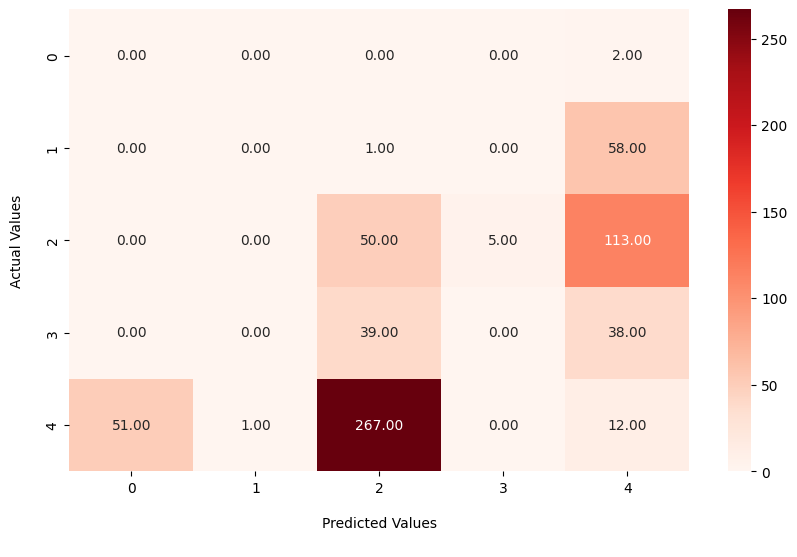

In [ ]:
x_trains=[X_train_1m,X_train_3m,X_train_6m,X_train_12m]
x_tests=[X_test_1m,X_test_3m,X_test_6m,X_test_12m]
y_trains=[y_train_1m,y_train_3m,y_train_6m,y_train_12m]
y_tests=[y_test_1m,y_test_3m,y_test_6m,y_test_12m]
params_list=[params_1m,params_3m,params_6m,params_12m]
targets=["target_1m","target_3m","target_6m","target_12m"]

for x in range(4):
  # read the dataset
  train_data = x_trains[x]
  train_labels = y_trains[x]
  test_data = x_tests[x]
  y_test= y_tests[x]

  train_pool = Pool(train_data,
                    train_labels)

  test_pool = Pool(test_data)
  # specify training parameters via map

  param = params_list[x]
  model = CatBoost(param)
  #train the model
  model.fit(train_pool,logging_level="Silent", early_stopping_rounds=10)

  preds_class = model.predict(test_pool, prediction_type='Class')

  print(f"Classification report for {targets[x]}:\n", classification_report(y_test, preds_class))

  train_pool = Pool(train_data)
  y_train=train_labels
  predictions_train=model.predict(train_pool, prediction_type='Class')
  # Calculate F1 score
  f1 = f1_score(y_test, preds_class, average='weighted')
  f1_train = f1_score(y_train, predictions_train, average='weighted')
  print(f"Puntuación F1 test del modelo en el periodo {targets[x]}: {round(f1,3)}")
  print(f"Puntuación F1 train del modelo en el periodo {targets[x]}: {round(f1_train,3)}")

  #Plot confusion matrix
  plt.figure(figsize=(10, 6))
  fx = sns.heatmap(confusion_matrix(y_test, preds_class), annot=True, fmt=".2f", cmap="Reds")
  #fx.set_title(f'Confusion Matrix for {target}')
  fx.set_xlabel('\nPredicted Values\n')
  fx.set_ylabel('Actual Values\n')
  plt.show()

### LightGBM

Precision score for 1m is: 0.5107
Training-set precision score for 1m is: 1.0000

F1 test of LightGBM for 1m: 0.5296
F1 train of LightGBM for 1m: 1.0000

Classification report for 1m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.62      0.71      0.66       412
           2       0.41      0.38      0.39       232
           3       0.00      0.00      0.00         3

    accuracy                           0.55       684
   macro avg       0.26      0.27      0.26       684
weighted avg       0.51      0.55      0.53       684



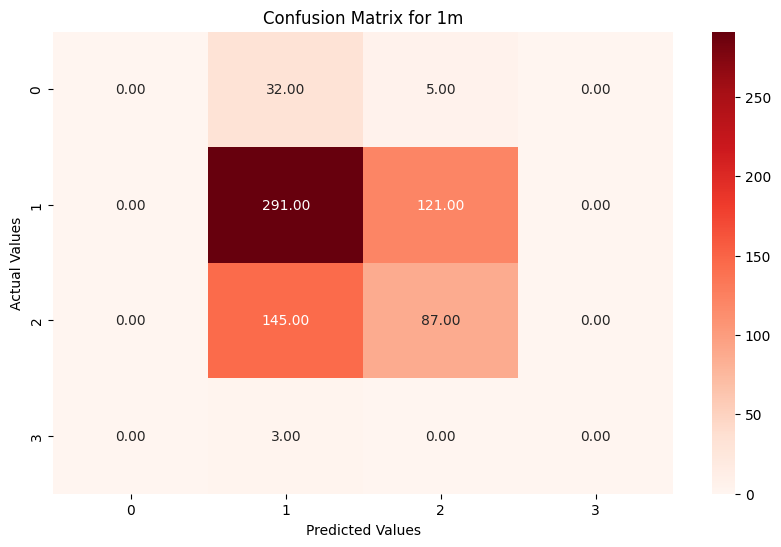

Precision score for 3m is: 0.4567
Training-set precision score for 3m is: 0.9848

F1 test of LightGBM for 3m: 0.4190
F1 train of LightGBM for 3m: 0.9848

Classification report for 3m:
               precision    recall  f1-score   support

           0       0.12      0.50      0.20        42
           1       0.45      0.52      0.48       229
           2       0.68      0.47      0.55       296
           3       0.00      0.00      0.00       107
           4       0.00      0.00      0.00         2

    accuracy                           0.41       676
   macro avg       0.25      0.30      0.25       676
weighted avg       0.46      0.41      0.42       676



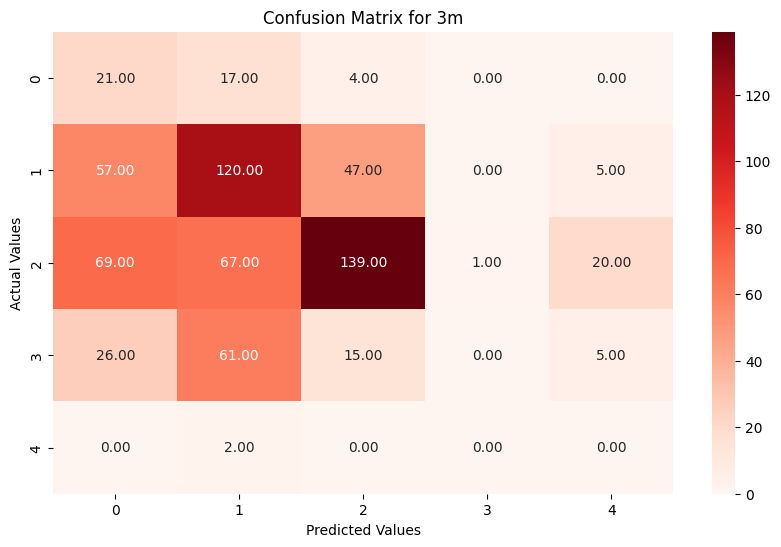

Precision score for 6m is: 0.3257
Training-set precision score for 6m is: 0.8747

F1 test of LightGBM for 6m: 0.2967
F1 train of LightGBM for 6m: 0.8740

Classification report for 6m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.22      0.52      0.31       151
           2       0.49      0.37      0.42       270
           3       0.41      0.27      0.32        97
           4       0.08      0.02      0.04       132

    accuracy                           0.31       663
   macro avg       0.24      0.24      0.22       663
weighted avg       0.33      0.31      0.30       663



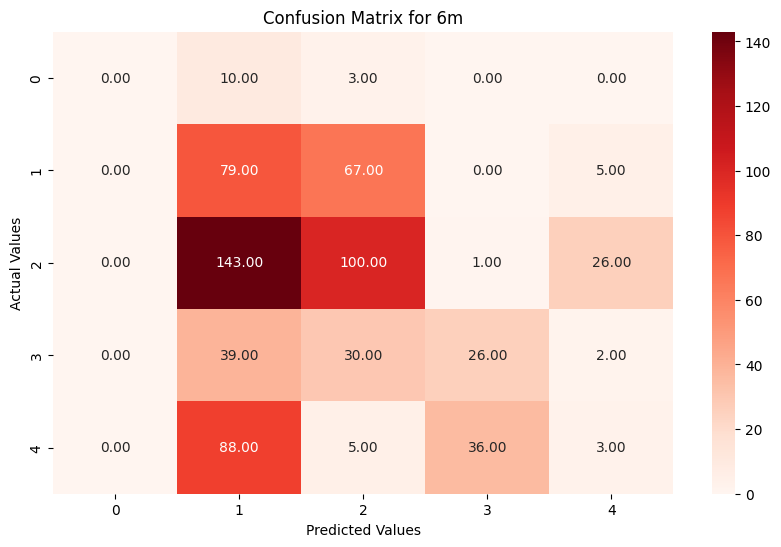

Precision score for 12m is: 0.4913
Training-set precision score for 12m is: 1.0000

F1 test of LightGBM for 12m: 0.4461
F1 train of LightGBM for 12m: 1.0000

Classification report for 12m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.18      0.41      0.25        59
           2       0.50      0.30      0.38       168
           3       0.14      0.14      0.14        77
           4       0.63      0.56      0.59       331

    accuracy                           0.42       637
   macro avg       0.29      0.28      0.27       637
weighted avg       0.49      0.42      0.45       637



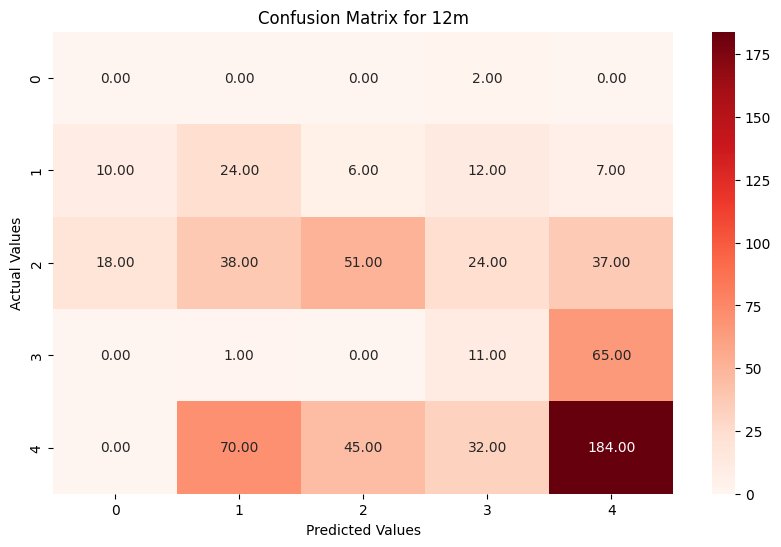

In [ ]:
params_dict = {
    '1m': {'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'num_leaves': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.6, 'verbose':-1, 'random_seed': 42},
    '3m': {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 50, 'num_leaves': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.6, 'verbose':-1, 'random_seed': 42 },
    '6m': {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 50, 'num_leaves': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.6, 'verbose':-1, 'random_seed': 42 },
    '12m': {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'verbose':-1 , 'random_seed': 42}
}
# List for each period
periods = ['1m', '3m', '6m', '12m']

#Iterate over each target (multi_tag_)
for period in periods:
    X_train = globals()[f'X_train_{period}']
    X_test = globals()[f'X_test_{period}']
    y_train = globals()[f'y_train_{period}']
    y_test = globals()[f'y_test_{period}']
    params = params_dict[period]
    #Create LGBM Classifier with specific params
    model_lgbm = lgb.LGBMClassifier(**params)
    #Train model
    model_lgbm.fit(X_train, y_train)
    # Predict results
    predictions_lgbm = model_lgbm.predict(X_test)
    predictions_lgbm_train = model_lgbm.predict(X_train)

    # Precision scores
    precision_lgbm = precision_score(y_test, predictions_lgbm, average='weighted')
    print(f"Precision score for {period} is: {precision_lgbm:.4f}")
    training_precision_lgbm = precision_score(y_train, predictions_lgbm_train, average='weighted')
    print(f"Training-set precision score for {period} is: {training_precision_lgbm:.4f}\n")

    #Additional metrics
    f1 = f1_score(y_test, predictions_lgbm, average='weighted')
    print(f"F1 test of LightGBM for {period}: {f1:.4f}")
    f1_train = f1_score(y_train, predictions_lgbm_train, average='weighted')
    print(f"F1 train of LightGBM for {period}: {f1_train:.4f}\n")

    # Classification report
    print(f"Classification report for {period}:\n", classification_report(y_test, predictions_lgbm))

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    fx = sns.heatmap(confusion_matrix(y_test, predictions_lgbm), annot=True, fmt=".2f", cmap="Reds")
    fx.set_title(f'Confusion Matrix for {period}')
    fx.set_xlabel('Predicted Values')
    fx.set_ylabel('Actual Values')
    plt.show()


### Random Forest

Precision del modelo RandomForestClassifier para 1m: 0.6541
Precision train RandomForestClassifier para 1m: 0.8082

F1 test RF para 1m: 0.5524
F1 train RF para 1m: 0.7925

Classification report for 1m:
              precision    recall  f1-score   support

           0       0.17      0.46      0.25        37
           1       0.67      0.87      0.75       412
           2       0.71      0.15      0.25       232
           3       0.00      0.00      0.00         3

    accuracy                           0.60       684
   macro avg       0.39      0.37      0.31       684
weighted avg       0.65      0.60      0.55       684

Confusion Matrix for 1m:
[[ 17  20   0   0]
 [ 41 357  14   0]
 [ 43 154  35   0]
 [  0   3   0   0]]


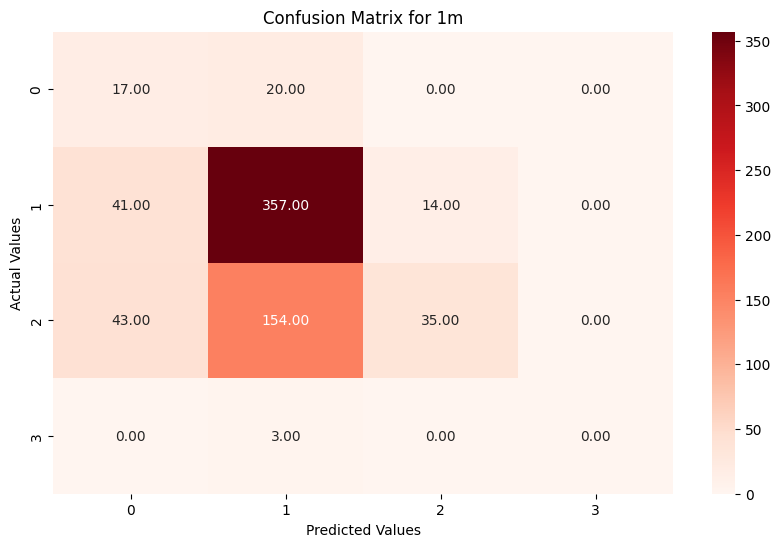

Precision del modelo RandomForestClassifier para 3m: 0.4009
Precision train RandomForestClassifier para 3m: 0.9112

F1 test RF para 3m: 0.4252
F1 train RF para 3m: 0.9109

Classification report for 3m:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.39      0.59      0.47       229
           2       0.58      0.62      0.60       296
           3       0.09      0.01      0.02       107
           4       0.00      0.00      0.00         2

    accuracy                           0.47       676
   macro avg       0.21      0.24      0.22       676
weighted avg       0.40      0.47      0.43       676

Confusion Matrix for 3m:
[[  0  38   4   0   0]
 [  0 136  93   0   0]
 [  0 102 184  10   0]
 [  0  70  36   1   0]
 [  0   2   0   0   0]]


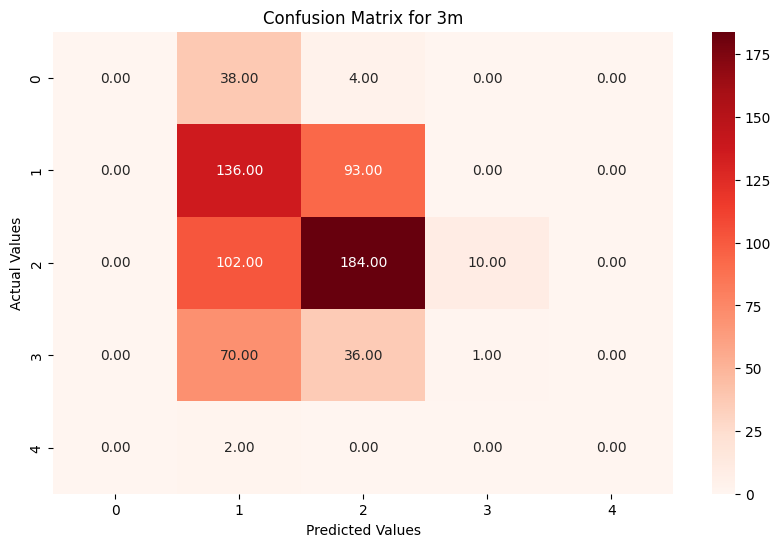

Precision del modelo RandomForestClassifier para 6m: 0.2886
Precision train RandomForestClassifier para 6m: 0.9244

F1 test RF para 6m: 0.2618
F1 train RF para 6m: 0.9243

Classification report for 6m:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.11      0.05      0.06       151
           2       0.40      0.87      0.55       270
           3       0.69      0.09      0.16        97
           4       0.00      0.00      0.00       132

    accuracy                           0.38       663
   macro avg       0.24      0.20      0.16       663
weighted avg       0.29      0.38      0.26       663

Confusion Matrix for 6m:
[[  0   0  13   0   0]
 [  0   7 144   0   0]
 [  0  35 234   1   0]
 [  0  17  71   9   0]
 [  0   7 122   3   0]]


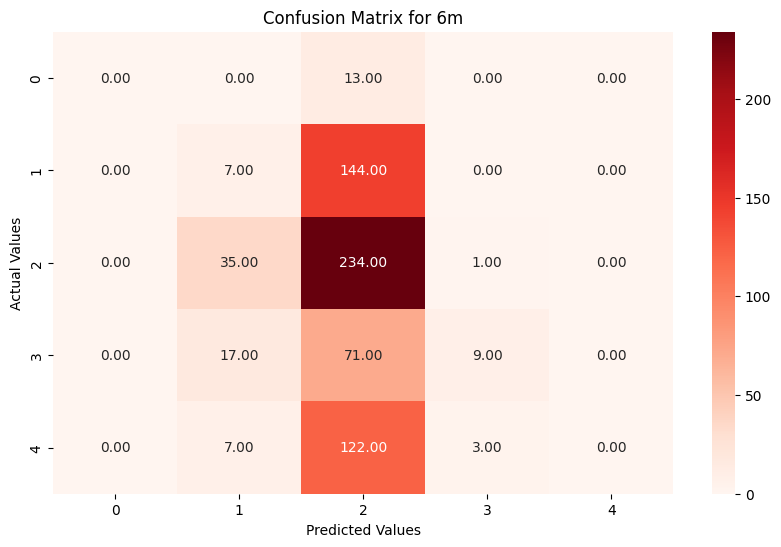

Precision del modelo RandomForestClassifier para 12m: 0.4782
Precision train RandomForestClassifier para 12m: 0.9914

F1 test RF para 12m: 0.3408
F1 train RF para 12m: 0.9913

Classification report for 12m:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.29      0.64      0.40        59
           2       0.13      0.15      0.14       168
           3       0.31      0.68      0.42        77
           4       0.73      0.29      0.42       331

    accuracy                           0.33       637
   macro avg       0.29      0.35      0.28       637
weighted avg       0.48      0.33      0.34       637

Confusion Matrix for 12m:
[[  0   2   0   0   0]
 [  0  38   0  21   0]
 [  0  51  26  77  14]
 [  0   1   3  52  21]
 [  0  40 177  18  96]]


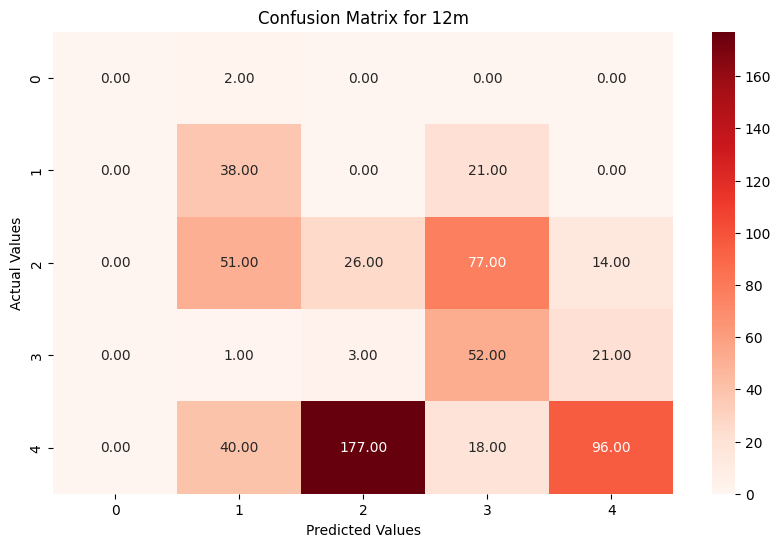

In [ ]:
#Create a model

#Define de parameters to train the models
params_dict = {
    '1m': {'n_estimators': 300, 'criterion': 'entropy', 'random_state': 42, 'bootstrap': False, 'max_leaf_nodes': 40,'n_jobs':-1},
    '3m': {'n_estimators': 300, 'criterion': 'entropy', 'random_state': 42, 'bootstrap': True, 'max_leaf_nodes': 100,'n_jobs':-1},
    '6m': {'n_estimators': 300, 'criterion': 'gini', 'random_state': 42, 'bootstrap': False, 'max_leaf_nodes': 100,'n_jobs':-1},
    '12m': {'n_estimators': 500, 'criterion': 'gini', 'random_state': 42, 'bootstrap': False, 'max_leaf_nodes': 200,'n_jobs':-1}
}

# Create a list with the periods
periods = ['1m', '3m', '6m', '12m']

#Iterate over each period
for period in periods:
    # Extract the training and test datasets for the current period
    X_train = globals()[f'X_train_{period}']
    X_test = globals()[f'X_test_{period}']
    y_train = globals()[f'y_train_{period}']
    y_test = globals()[f'y_test_{period}']
    params = params_dict[period]

    # Create the model with specific parameters
    rf_model = RandomForestClassifier(**params)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict results
    predictions = rf_model.predict(X_test)
    y_pred_train = rf_model.predict(X_train)

    # Calculate precision
    precision = precision_score(y_test, predictions, average='weighted')
    print(f"Precision del modelo RandomForestClassifier para {period}: {precision:.4f}")
    precision_train = precision_score(y_train, y_pred_train, average='weighted')
    print(f"Precision train RandomForestClassifier para {period}: {precision_train:.4f}\n")

    # Calculate aditional metrics
    f1 = f1_score(y_test, predictions, average='weighted')
    print(f"F1 test RF para {period}: {f1:.4f}")
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    print(f"F1 train RF para {period}: {f1_train:.4f}\n")

    # Create classification report and confusion matrix
    classification_rep = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f"Classification report for {period}:\n{classification_rep}")
    print(f'Confusion Matrix for {period}:')
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Reds")
    plt.title(f'Confusion Matrix for {period}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()


## Model Tuning

### Tuning for 1m Period - Random Forest

In [ ]:
# Extract the training and test datasets for the current period
X_train = X_train_1m
X_test = X_test_1m
y_train = y_train_1m
y_test = y_test_1m

# Define the hyperparameters to be tested in GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [20, 50, 70],
    'bootstrap': [True, False],
    'random_state': [42],
    'n_jobs': [-1],
    'min_impurity_decrease':[0.1,0.01,0.007]
}

# Create the RandomForestClassifier model
rf_model = RandomForestClassifier()

# Configure GridSearchCV with the model, hyperparameters, and evaluation metric
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='precision_weighted', cv=5, n_jobs=-1, verbose=2)

# Get the best model from GridSearchCV
grid_search.fit(X_train[final_features], y_train)

# Train the model with GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predict results
predictions_rf = best_rf_model.predict(X_test[final_features])
y_pred_train = best_rf_model.predict(X_train[final_features])

# Identify which parameters are being used currently
print(f"Para esta iteración se están utilizando los siguientes parametros: {param_grid}")

# Calculate precision
precision_rf = precision_score(y_test, predictions_rf, average='weighted')
print(f"Precision del mejor modelo RandomForestClassifier para 1 mes: {precision:.4f}")
precision_train_rf = precision_score(y_train, y_pred_train, average='weighted')
print(f"Precision del mejor modelo RandomForestClassifier (train) para 1 mes: {precision_train_rf:.4f}")

# Calculate additional metrics
f1 = f1_score(y_test, predictions_rf, average='weighted')
print(f"F1 test RF para 1 mes: {round(f1,3)}")
f1_train = f1_score(y_train, y_pred_train, average='weighted')
print(f"F1 train RF para 1 mes: {round(f1_train,3)}")

# Create classification report and confusion matrix
classification_rep = classification_report(y_test, predictions_rf)
conf_matrix = confusion_matrix(y_test, predictions_rf)

# Print classification report
print(f"Classification report for 1 mes:\n{classification_rep}")

# Print the confusion matrix
#print(f'Confusion Matrix for 1 mes:')
#print(conf_matrix)

# Plot the confusion matrix
#plt.figure(figsize=(10, 6))
#sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="GnBu")
#plt.title(f'Confusion Matrix for 1 mes')
#plt.xlabel('Predicted Values')
#plt.ylabel('Actual Values')
#plt.show()

# Print the best hyperparameters
print(f'Mejor combinación de hiperparámetros: {grid_search.best_params_}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

F1 test RF: 0.5054
F1 train RF: 0.5493
Precision test RF: 0.6921
Precision train RF: 0.6943

Classification report for 1m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.62      1.00      0.76       412
           2       0.94      0.07      0.14       232
           3       0.00      0.00      0.00         3

    accuracy                           0.63       684
   macro avg       0.39      0.27      0.22       684
weighted avg       0.69      0.63      0.51       684

Confusion Matrix for 1m:
[[  0  37   0   0]
 [  0 411   1   0]
 [  0 215  17   0]
 [  0   3   0   0]]


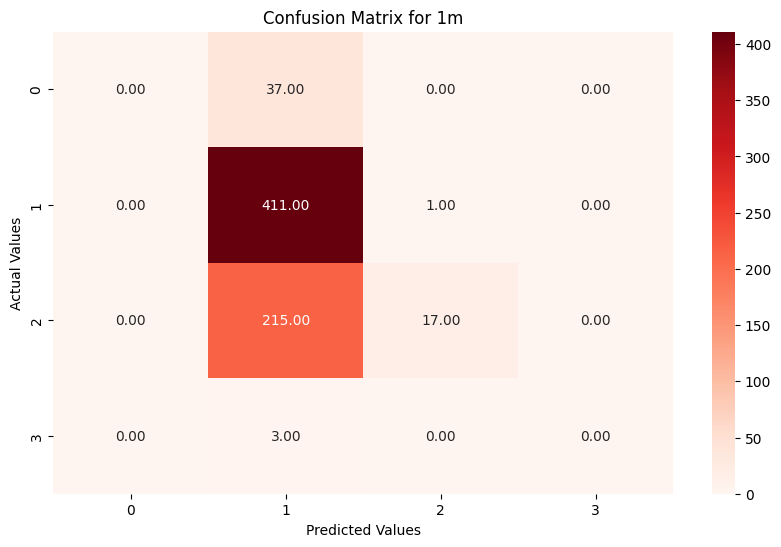

In [ ]:
# Define the specific hyperparameters
params = {
    'n_estimators': 150,
    'n_jobs': -1,
    'random_state': 42,
    'bootstrap': False,
    'criterion': 'gini',
    'max_leaf_nodes':50,
    'min_impurity_decrease':0.007,
}

# Create the RandomForestClassifier model with the specific hyperparameters
rf_model = RandomForestClassifier(**params)

# Train the model
rf_model.fit(X_train_1m, y_train_1m)

# Predict the results
predictions_rf = rf_model.predict(X_test_1m)
y_pred_train = rf_model.predict(X_train_1m)

#Calculate metrics
f1 = f1_score(y_test_1m, predictions_rf, average='weighted')
print(f"F1 test RF: {f1:.4f}")
f1_train = f1_score(y_train_1m, y_pred_train, average='weighted')
print(f"F1 train RF: {f1_train:.4f}")
precision = precision_score(y_test_1m, predictions_rf, average='weighted')
print(f"Precision test RF: {precision:.4f}")
precision_train = precision_score(y_train_1m, y_pred_train, average='weighted')
print(f"Precision train RF: {precision_train:.4f}\n")

#Print classification report
print(f"Classification report for 1m:\n", classification_report(y_test_1m, predictions_rf))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_1m, predictions_rf)
print(f'Confusion Matrix for 1m:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Reds")
plt.title(f'Confusion Matrix for 1m')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


### Tuning for 3m Period - Logistic Regression

Mejores umbrales encontrados: [100.0, 86.8250667781825, 93.82530171431983, 53.97357488448793, 100.0]
Precision with optimized thresholds (test): -0.5521
Precision with optimized thresholds (train): -0.5803
Classification report with optimized thresholds for 3m (test):
              precision    recall  f1-score   support

           0       0.40      0.10      0.15        42
           1       1.00      0.07      0.13       229
           2       0.38      0.59      0.46       296
           3       0.15      0.26      0.19       107
           4       0.00      0.00      0.00         2

    accuracy                           0.33       676
   macro avg       0.39      0.20      0.19       676
weighted avg       0.55      0.33      0.28       676

Confusion Matrix with optimized thresholds for 3m (test):
[[  4   0  36   2   0]
 [  1  16 171  41   0]
 [  5   0 174 117   0]
 [  0   0  79  28   0]
 [  0   0   2   0   0]]


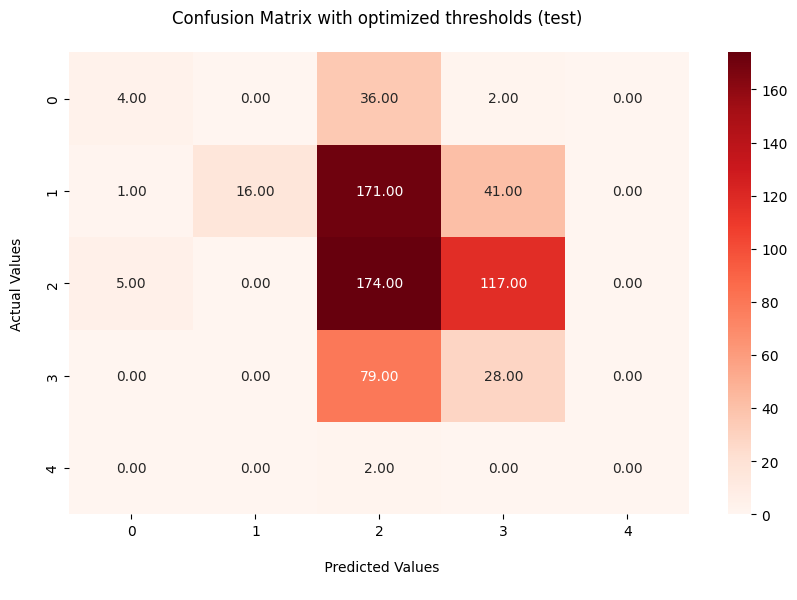

Parametros del modelo {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [ ]:
## Optimizing Thresholds considering train and test and minimizing diference between both

# Defining train and test datasets
X_train = X_train_3m
X_test = X_test_3m
y_train = y_train_3m
y_test = y_test_3m

# Defining model Parameters

params = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True,
          'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100,
          'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0,
          'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

# Creating LogisticRegression model with specified parameters
model = LogisticRegression(**params)
# Training the model
model.fit(X_train, y_train)

# Obtener las probabilidades predichas
proba_train = model.predict_proba(X_train)
proba_test = model.predict_proba(X_test)

# Defining a function to evaluate the metrics
def evaluate_thresholds(proba, y_true, thresholds):
    adjusted_proba = proba * thresholds
    y_pred = np.argmax(adjusted_proba, axis=1)
    precision = precision_score(y_true, y_pred, average='weighted')
    return -precision

# Defining space to search for optimal thresholds
space = [(0.1, 100) for _ in range(len(model.classes_))]  # Rango para cada umbral

# Objective function to evaluate optimization
def objective(thresholds, proba_train, y_train, proba_test, y_test):
    # Evaluating métrics with optimized thresholds for train
    precision_train = evaluate_thresholds(proba_train, y_train, thresholds)
    # Evaluating métrics with optimized thresholds for test
    precision_test = evaluate_thresholds(proba_test, y_test, thresholds)
    # Calculate the diference between metrics
    difference = abs(precision_train - precision_test)
    # Return a cobination of precisions and penalize for the diferences
    return (precision_train + (1.07*precision_test)) - difference**(5/2)

# Bayesian optimization to search for optimal thresholds
result = gp_minimize(partial(objective, proba_train=proba_train, y_train=y_train, proba_test=proba_test, y_test=y_test), space, n_calls=150, random_state=0)

# Obtaining the best thresholds
best_thresholds = result.x
print("Mejores umbrales encontrados:", best_thresholds)

# Evaluating metrics with optimal thresholds for test
precision_test = evaluate_thresholds(proba_test, y_test, best_thresholds)
print(f"Precision with optimized thresholds (test): {precision_test:.4f}")

# Evaluating metrics with optimal thresholds for train
precision_train = evaluate_thresholds(proba_train, y_train, best_thresholds)
print(f"Precision with optimized thresholds (train): {precision_train:.4f}")

# Calculating classification report and confussion matrix for test
classification_rep_test = classification_report(y_test, np.argmax(proba_test * best_thresholds, axis=1))
print(f"Classification report with optimized thresholds for 3m (test):\n{classification_rep_test}")

# Print of confussion matrix for test
conf_matrix_test = confusion_matrix(y_test, np.argmax(proba_test * best_thresholds, axis=1))
print(f'Confusion Matrix with optimized thresholds for 3m (test):')
print(conf_matrix_test)

# Graphing the confussion matrix
plt.figure(figsize=(10, 6))
fx = sns.heatmap(conf_matrix_test, annot=True, fmt=".2f", cmap="Reds")
fx.set_title('Confusion Matrix with optimized thresholds (test) \n')
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n')
plt.show()

# Printing the model parameters
print("Parametros del modelo", model.get_params())

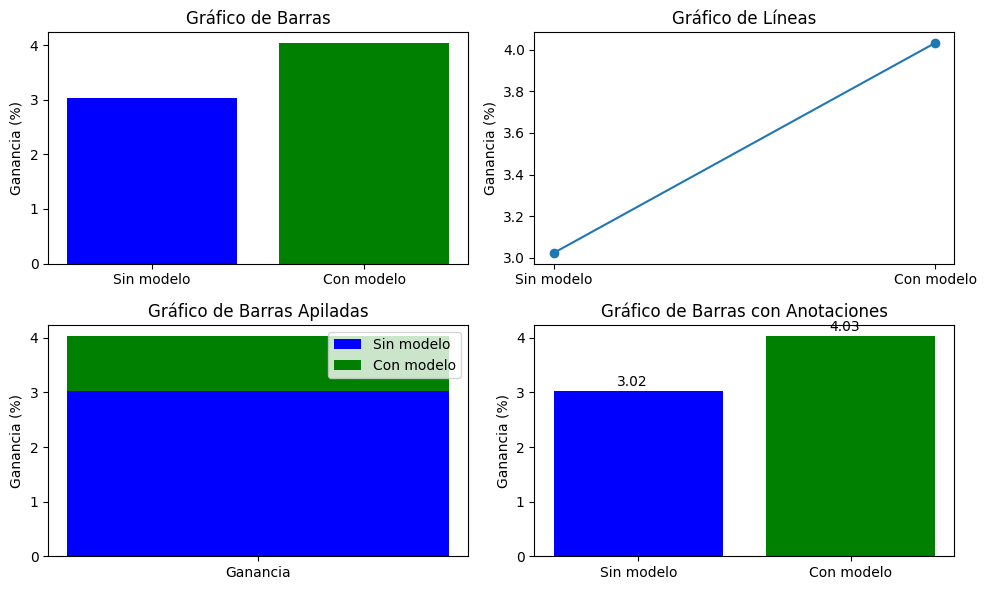

In [ ]:

# Data of % of earnings
sin_modelo = 0.030232442843393256 * 100
con_modelo = 0.04033136994478882 * 100
diferencia = con_modelo - sin_modelo

# Bar Graph
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.bar(['Sin modelo', 'Con modelo'], [sin_modelo, con_modelo], color=['blue', 'green'])
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Barras')

# Line Graph
plt.subplot(2, 2, 2)
plt.plot(['Sin modelo', 'Con modelo'], [sin_modelo, con_modelo], marker='o')
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Líneas')

# Bar graph
plt.subplot(2, 2, 3)
plt.bar(['Ganancia'], [sin_modelo], color='blue', label='Sin modelo')
plt.bar(['Ganancia'], [diferencia], bottom=[sin_modelo], color='green', label='Con modelo')
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Barras Apiladas')
plt.legend()

# Bar Graph with tags
plt.subplot(2, 2, 4)
bars = plt.bar(['Sin modelo', 'Con modelo'], [sin_modelo, con_modelo], color=['blue', 'green'])
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Barras con Anotaciones')

# Notations on graphs
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.1, round(yval, 2))

plt.tight_layout()
plt.show()

### Tuning for 6m Period - XGBoost

Accuracy for 6m: 38.16%
Recall del modelo en el periodo 6m: 0.3815987933634992
Precision del modelo en el periodo 6m: 0.40892374078365235
Precision Train del modelo en el periodo 6m: 0.8916009040019997



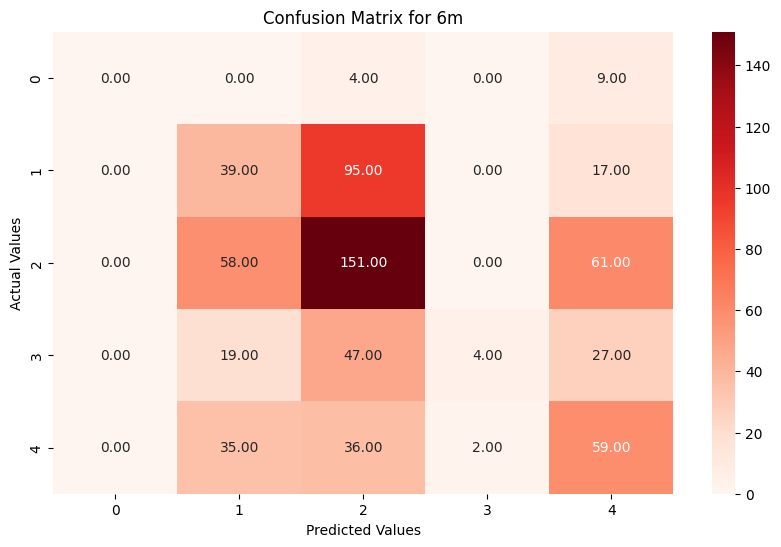

In [ ]:


x_trains=[X_train_6m]
x_tests=[X_test_6m]
y_trains=[y_train_6m]
y_tests=[y_test_6m]

for idx, n in enumerate(['6m']):
    # Prepare the train and test data for the current period
    X_train = x_trains[idx]
    y_train = y_trains[idx]
    X_test = x_tests[idx]
    y_test = y_tests[idx]

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set new parameters for XGBoost
    params = {
      'objective': 'multi:softprob',
      'num_class': len(np.unique(y_train)),
      'min_split_gain': 0.2,
      'alpha': 0.01,  # Modify alpha
      'max_depth': 6,  # Modify max_depth
      'lambda': 1,  # add lambda
      'eta': 0.1,  # Modify eta
      'gamma': 0.1,  # add gamma
      'random_seed': 42
    }

    # Train the model with early stopping
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=False)

    # Get the best iteration
    best_iteration = bst.best_iteration

    # Retrain the model with the best number of boosting rounds
    bst = xgb.train(params, dtrain, num_boost_round=best_iteration)

    # Make predictions on the test set
    y_pred = bst.predict(dtest)
    y_pred_train = bst.predict(dtrain)

    # Get the class with the highest probability as the predicted class
    predictions_xg = np.argmax(y_pred, axis=1)
    predictions_train = np.argmax(y_pred_train, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions_xg)
    print(f'Accuracy for {n}: {accuracy * 100.0:.2f}%')

    # Calculate recall and precision
    recall = recall_score(y_test, predictions_xg, average='weighted')
    precision = precision_score(y_test, predictions_xg, average='weighted')
    precision_train = precision_score(y_train, predictions_train, average='weighted')
    print(f"Recall del modelo en el periodo {n}: {recall}")
    print(f"Precision del modelo en el periodo {n}: {precision}")
    print(f"Precision Train del modelo en el periodo {n}: {precision_train}\n")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions_xg)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Reds")
    plt.title(f'Confusion Matrix for {n}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

In [ ]:
len(predictions_xg)

663

In [ ]:
df_comp_6m = df_normal.iloc[-128 - 663:-128]
df_comp_6m["Pred_6m_XGBoost"]=predictions_xg
df_comp_6m

Date  Open_USDMX   Open_Oil    Open_Gold   Open_SP500  \
2973 2021-03-01   20.787701  61.950001  1737.099976  3842.510010   
2974 2021-03-02   20.656601  60.230000  1709.400024  3903.639893   
2975 2021-03-03   20.605610  59.549999  1730.000000  3863.989990   
2976 2021-03-04   20.967360  61.080002  1706.500000  3818.530029   
2977 2021-03-05   21.130859  64.160004  1690.599976  3793.580078   
...         ...         ...        ...          ...          ...   
3637 2023-09-07   17.578899  87.540001  1917.599976  4434.549805   
3638 2023-09-08   17.577299  86.779999  1924.000000  4451.299805   
3639 2023-09-11   17.543140  87.400002  1923.000000  4480.979980   
3640 2023-09-12   17.281031  87.269997  1920.800049  4473.270020   
3641 2023-09-13   17.213400  88.750000  1910.300049  4462.649902   

      Open_1_year_MX  Open_5_year_MX  Open_10_year_MX  Open_1_year_US  \
2973            4.22           6.845            7.444           0.056   
2974            4.21           6.855            7.419           0.056   
2975            4.25           6.885            7.425           0.061   
2976            4.25           6.955            7.465           0.051   
2977            4.32           6.937            7.515           0.056   
...              ...             ...              ...             ...   
3637           11.54          10.678            9.893           5.448   
3638           11.54          10.678            9.893           5.448   
3639           11.54          10.678            9.893           5.448   
3640           11.54          10.678            9.893           5.448   
3641           11.54          10.678            9.893           5.448   

      Open_5_year_US  ...      f_12m  ProfitLoss1m  ProfitLoss3m  \
2973           1.725  ...  21.662423      0.014509      0.052479   
2974           1.719  ...  21.523719      0.014490      0.046707   
2975           1.676  ...  21.477832      0.019623      0.045486   
2976           1.671  ...  21.857103      0.036129      0.061425   
2977           1.643  ...  22.041375      0.044648      0.072785   
...              ...  ...        ...           ...           ...   
3637           2.598  ...  18.605172     -0.030413      0.027925   
3638           2.598  ...  18.603479     -0.029419      0.032043   
3639           2.598  ...  18.567326     -0.016852      0.018824   
3640           2.598  ...  18.289914     -0.026283      0.011160   
3641           2.598  ...  18.218335     -0.037297      0.005880   

      ProfitLoss6m  ProfitLoss12m  multi_tag_1m  multi_tag_3m  multi_tag_6m  \
2973      0.048777       0.053110             1             2             2   
2974      0.034928       0.051815             1             2             2   
2975      0.042874       0.041122             1             2             2   
2976      0.063075       0.058857             2             2             2   
2977      0.075861       0.068486             2             3             3   
...            ...            ...           ...           ...           ...   
3637      0.067536            NaN             0             2             2   
3638      0.068887            NaN             1             2             2   
3639      0.070543            NaN             1             1             3   
3640      0.054742            NaN             1             1             2   
3641      0.054762            NaN             0             1             2   

      multi_tag_12m  Pred_6m_XGBoost  
2973              2                2  
2974              2                2  
2975              2                2  
2976              2                2  
2977              2                2  
...             ...              ...  
3637              0                1  
3638              0                1  
3639              0                1  
3640              0                1  
3641              0                1  

[663 rows x 46 columns]

In [ ]:
media_estrategia_6m=df_comp_6m[(df_comp_6m["Pred_6m_XGBoost"]==2)|(df_comp_6m["Pred_6m_XGBoost"]==3)|(df_comp_6m["Pred_6m_XGBoost"]==4)]["ProfitLoss6m"].mean()
media_estrategia_6m

0.058509196223643097

In [ ]:
media_global_6m=df_comp_6m["ProfitLoss6m"].mean()
media_global_6m

0.059407310314485484

In [ ]:
diferencia_6m = (media_estrategia_6m/media_global_6m)-1

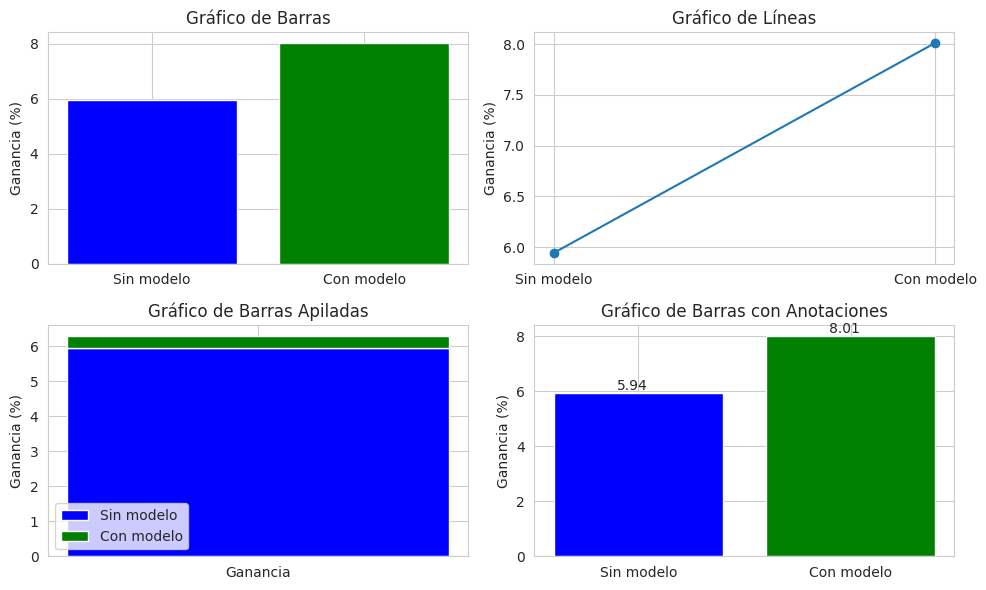

In [ ]:

# Datos de ganancias
sin_modelo = media_global_6m * 100
con_modelo = media_estrategia_6m * 100
diferencia = diferencia_6m

# Gráfico de Barras
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.bar(['Sin modelo', 'Con modelo'], [sin_modelo, con_modelo], color=['blue', 'green'])
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Barras')

# Gráfico de Líneas
plt.subplot(2, 2, 2)
plt.plot(['Sin modelo', 'Con modelo'], [sin_modelo, con_modelo], marker='o')
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Líneas')

# Gráfico de Barras Apiladas
plt.subplot(2, 2, 3)
plt.bar(['Ganancia'], [sin_modelo], color='blue', label='Sin modelo')
plt.bar(['Ganancia'], [diferencia], bottom=[sin_modelo], color='green', label='Con modelo')
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Barras Apiladas')
plt.legend()

# Gráfico de Barras con Anotaciones
plt.subplot(2, 2, 4)
bars = plt.bar(['Sin modelo', 'Con modelo'], [sin_modelo, con_modelo], color=['blue', 'green'])
plt.ylabel('Ganancia (%)')
plt.title('Gráfico de Barras con Anotaciones')

# Añadir anotaciones
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.1, round(yval, 2))

plt.tight_layout()
plt.show()

### Tuning for 12m Period - LightGBM

Precision score for 12m is: 0.5255
Training-set precision score for 12m is: 0.9926

F1 test of LightGBM for 12m: 0.4255
F1 train of LightGBM for 12m: 0.9925

Classification report for 12m:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.11      0.41      0.17        59
           2       0.67      0.35      0.45       168
           3       0.24      0.19      0.21        77
           4       0.60      0.44      0.51       331

    accuracy                           0.38       637
   macro avg       0.32      0.28      0.27       637
weighted avg       0.53      0.38      0.43       637



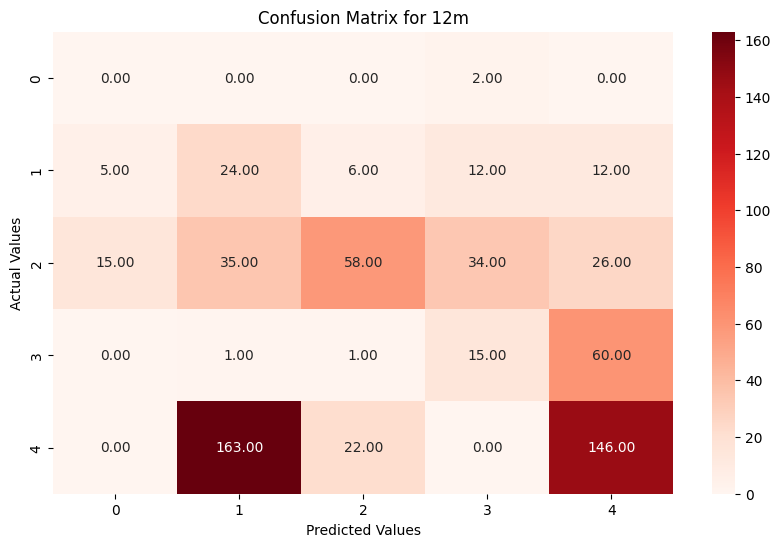

In [ ]:
params_dict = {'12m': {'learning_rate': 0.01, 'max_depth' : -1, 'num_iterations': 400 , 'min_child_samples': 20, 'num_leaves': 31, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'subsample': 1.0, 'verbose' : -1 ,'path_smooth' : 5, 'random_seed' : 42 }}

# List for each period
periods = ['12m']

#Iterate over each target (multi_tag_)
for period in periods:
    X_train = globals()[f'X_train_{period}']
    X_test = globals()[f'X_test_{period}']
    y_train = globals()[f'y_train_{period}']
    y_test = globals()[f'y_test_{period}']
    params = params_dict[period]
    #Create LGBM Classifier with specific params
    model_lgbm = lgb.LGBMClassifier(**params)
    #Train model
    model_lgbm.fit(X_train, y_train)
    # Predict results
    predictions_lgbm = model_lgbm.predict(X_test)
    predictions_lgbm_train = model_lgbm.predict(X_train)

    # Precision scores
    precision_lgbm = precision_score(y_test, predictions_lgbm, average='weighted')
    print(f"Precision score for {period} is: {precision_lgbm:.4f}")
    training_precision_lgbm = precision_score(y_train, predictions_lgbm_train, average='weighted')
    print(f"Training-set precision score for {period} is: {training_precision_lgbm:.4f}\n")

    #Additional metrics
    f1 = f1_score(y_test, predictions_lgbm, average='weighted')
    print(f"F1 test of LightGBM for {period}: {f1:.4f}")
    f1_train = f1_score(y_train, predictions_lgbm_train, average='weighted')
    print(f"F1 train of LightGBM for {period}: {f1_train:.4f}\n")

    # Classification report
    print(f"Classification report for {period}:\n", classification_report(y_test, predictions_lgbm))

    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    fx = sns.heatmap(confusion_matrix(y_test, predictions_lgbm), annot=True, fmt=".2f", cmap="Reds")
    fx.set_title(f'Confusion Matrix for {period}')
    fx.set_xlabel('Predicted Values')
    fx.set_ylabel('Actual Values')
    plt.show()

## Results

In [ ]:
len(predictions_rf)

684

In [ ]:
df_comp_1m=df_normal.iloc[-22-684:-22]
df_comp_1m["tag_predicho"]=predictions_rf
media_estrategia_1m=df_comp_1m[(df_comp_1m["tag_predicho"]==2)|(df_comp_1m["tag_predicho"]==3)|(df_comp_1m["tag_predicho"]==4)]["ProfitLoss1m"].mean()
print(f'El rendimiento con la estrategia es: {media_estrategia_1m:.4f}')
media_global_1m=df_comp_1m["ProfitLoss1m"].mean()
print(f'El rendimiento sin la estrategia es: {media_global_1m:.4f}')
print(f'El rendimiento de la estrategia vs sin estrategia es de {((media_estrategia_1m/media_global_1m)-1):.4f}')

El rendimiento con la estrategia es: 0.0335
El rendimiento sin la estrategia es: 0.0105
El rendimiento de la estrategia vs sin estrategia es de 2.2048


In [ ]:
# Locating set corresponding to test
df_comp_3m=df_normal.iloc[2701:3377,:]
#Adding predictions to dataset
df_comp_3m["tag_predicho"]=np.argmax(proba_test * best_thresholds, axis=1)
df_comp_3m
#Obtaining mean value of return using the model
media_estrategia_3m=df_comp_3m[(df_comp_3m["tag_predicho"]==3)|(df_comp_3m["tag_predicho"]==4)]["ProfitLoss3m"].mean()
media_estrategia_3m
#Obtaining avarage return with no strategy
media_global_3m=df_comp_3m["ProfitLoss3m"].mean()
media_global_3m
#Obtaining % of performance with mean metrics
(media_estrategia_3m/media_global_3m)-1

print(f'El rendimiento con la estrategia es: {media_estrategia_3m:.4f}')
print(f'El rendimiento sin la estrategia es: {media_global_3m:.4f}')
print(f'El rendimiento de la estrategia vs sin estrategia es de {((media_estrategia_3m/media_global_3m)-1):.4f}')

In [ ]:
df_comp_6m = df_normal.iloc[-128 - 663:-128]
df_comp_6m["Pred_6m_XGBoost"]=predictions_xg
media_estrategia_6m=df_comp_6m[(df_comp_6m["Pred_6m_XGBoost"]==2)|(df_comp_6m["Pred_6m_XGBoost"]==3)|(df_comp_6m["Pred_6m_XGBoost"]==4)]["ProfitLoss6m"].mean()
print(f'El rendimiento con la estrategia es: {media_estrategia_6m:.4f}')
media_global_6m=df_comp_6m["ProfitLoss6m"].mean()
print(f'El rendimiento sin la estrategia es: {media_global_6m:.4f}')
print(f'El rendimiento de la estrategia vs sin estrategia es de {((media_estrategia_6m/media_global_6m)-1):.4f}')

El rendimiento con la estrategia es: 0.0585
El rendimiento sin la estrategia es: 0.0594
El rendimiento de la estrategia vs sin estrategia es de -0.0151


In [ ]:
len(predictions_lgbm)

637

In [ ]:
df_comp_12m=df_normal.iloc[-260-637: - 260]
df_comp_12m["tag_predicho"]=predictions_lgbm
media_estrategia_12m=df_comp_12m[(df_comp_12m["tag_predicho"]==3)|(df_comp_12m["tag_predicho"]==4) ]["ProfitLoss12m"].mean()
print(f'El rendimiento con la estrategia es: {media_estrategia_12m:.4f}')
media_global_12m=df_comp_12m["ProfitLoss12m"].mean()
print(f'El rendimiento sin la estrategia es: {media_global_12m:.4f}')
print(f'El rendimiento de la estrategia vs sin estrategia es de {((media_estrategia_12m/media_global_12m)-1):.4f}')

El rendimiento con la estrategia es: 0.1243
El rendimiento sin la estrategia es: 0.1219
El rendimiento de la estrategia vs sin estrategia es de 0.0196


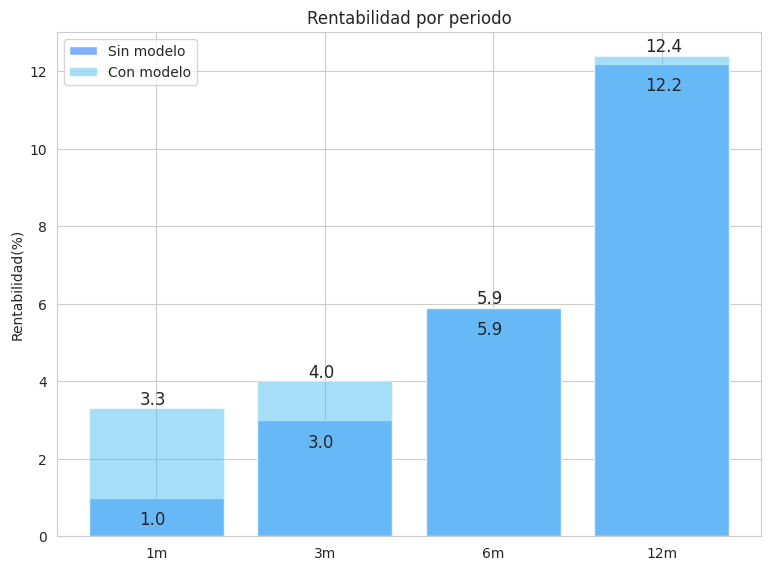

In [ ]:
#Profit data
sin_modelo_1m = round((media_global_1m * 100),1)
con_modelo_1m = round((media_estrategia_1m * 100),1)
diferencia_1m = con_modelo_1m - sin_modelo_1m

sin_modelo_3m = round((media_global_3m * 100),1)
con_modelo_3m = round((media_estrategia_3m * 100),1)
diferencia_3m = con_modelo_3m - sin_modelo_3m

sin_modelo_6m = round((media_estrategia_6m* 100),1)
con_modelo_6m = round((media_global_6m * 100),1)

sin_modelo_12m = round((media_global_12m * 100),1)
con_modelo_12m = round((media_estrategia_12m * 100),1)
diferencia_12m = con_modelo_12m - sin_modelo_12m

#Define periods
periodos = ['1m', '3m', '6m', '12m']
sin_modelo = [sin_modelo_1m, sin_modelo_3m, sin_modelo_6m, sin_modelo_12m]
con_modelo = [con_modelo_1m, con_modelo_3m, con_modelo_6m, con_modelo_12m]
diferencia = [diferencia_1m, diferencia_3m, diferencia_6m, diferencia_12m]

#Plot returns
plt.figure(figsize=(15, 11))
plt.subplot(2, 2, 4)
bars1 = plt.bar(periodos, sin_modelo, color='#80B3FF', label='Sin modelo')
bars2 = plt.bar(periodos, con_modelo, color='#4DBEEE', label='Con modelo', alpha=0.5)
plt.ylabel('Rentabilidad(%)')
plt.title('Rentabilidad por periodo')

#Add labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval - 0.7, round(yval, 2), fontsize=12)

#Adjust label position for each model
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 0.1 if yval != sin_modelo_12m else yval + 0.5, round(yval, 2), fontsize=12)

#Add legend
plt.legend()
plt.tight_layout()
plt.show()